In [ ]:
#@title ##### License { display-mode: "form" }
# Copyright 2019 DeepMind Technologies Ltd. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# OpenSpiel

* This Colab gets you started with installing OpenSpiel and its dependencies.
* OpenSpiel is a framework for reinforcement learning in games.
* The instructions are adapted from [here](https://github.com/deepmind/open_spiel/blob/master/docs/install.md).

## Install

Install OpenSpiel via pip:


In [ ]:
!pip install --upgrade open_spiel

# It's play time!

In [1]:
####

In [7]:
#!/usr/bin/env python3
"""
Standalone: runs OMWU variants on random 5x5 zero-sum games and plots results.

Variants implemented (directions d_t exactly as specified by user):
- OMWU:                d_t = 2 g_t − g_{t−1}
- OMWU-L:              d_t = (L+1) g_t − sum_{i=1}^L g_{t−i}
- OMWU-EO:             d_t = (L+1) g_t − L g_{t−1}
- OMWU-EOO:            d_t = (L+1) g_t − g_{t−1} − pending_t
                        pending_{t+1} = max(L−1,0) · g_{t−1}
- OMWU-DECAY:          d_t = α_b g_t − (α_b−1) g_{t−1}
                             + sum_{j=0}^{K_f−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
                        (ρ=1): d_t = (α_b+α_s) g_t − (α_b−1) g_{t−1} − α_s g_{t−K_f}
- OMWU-DECAY-Gt:       d_t = α_b g_t − (α_b−1) g_{t−1}
                             + sum_{j=0}^{K_f−1} α_s ρ^j (g_t − g_{t−j−1})
                        (ρ=1): d_t = (α_b + K_f α_s) g_t − α_s * sum_{j=1}^{K_f} g_{t−j}
- OMWU-KD:             per step: Δb_t = η (2 g_t − g_{t−1}); b += Δb_t
                        every K_win steps: b -= sum of the first D_drop increments from that window
- KOMWU-Cautious:      direction is 2 g_t − g_{t−1}, but step size λ_t ∈ (0, η]
                        chosen by maximizing f(λ;r_t) = (α−1) log λ + log Σ_i exp(λ r_{t,i})
                        with r_t = U_t + u_{t−1},  u_t = g_t − <g_t, x_t> · 1
                        and full-step guard if max(r_t) ≥ −β (log d)^2
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple

# ========================== CONFIG (edit me) ==========================
@dataclass
class Config:
    n_actions: int = 25                 # 5x5 game
    n_games: int = 3                   # number of random games to average
    T: int = 240000                     # iterations per game
    eta: float = 0.1                   # base step size
    L: int = 5                         # breadth for *-L, EO, EOO
    alpha_b: float = 1.0               # DECAY base weight
    alpha_s: float = 5.0               # DECAY suffix weight
    rho: float = 1.0                   # DECAY geometric factor
    Kf: int = 5                        # DECAY filter length
    K_win: int = 10                    # KD window length
    D_drop: int = 5                    # KD drop count at each window end
    cautious_alpha: float = 4.0        # Cautious (α in f(λ))
    cautious_beta: float = 70.0        # Cautious (β threshold)
    cautious_newton_iters: int = 8     # Cautious Newton steps
    cautious_newton_tol: float = 1e-12 # Cautious Newton tol
    seed: int = 1                      # RNG seed
    print_every: int = 500             # progress print freq
    plot_every: int = 100              # curve sampling freq

CFG = Config()
# =====================================================================

# ============== numerics (stable softmax, helpers) ====================
def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    s = e / np.sum(e)
    return s

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    # g_row = A y
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    # g_col = -A^T x
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)  # since ev_col = -ev_row
    exploit = 0.5 * nconv
    return nconv, exploit

# ============================ base agent ==============================
class AgentBase:
    def __init__(self, n: int, eta: float, label: str):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.b = np.zeros(n, dtype=float)
        self.x = softmax(self.b)
        self.t = 0
        self.g_prev = np.zeros(n, dtype=float)  # g_{t-1}, zero if missing
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_grad(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, t_idx: int) -> np.ndarray:
        if t_idx <= 0 or t_idx > len(self._g_hist):
            return np.zeros(self.n, dtype=float)
        return self._g_hist[t_idx - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ============================ variants ================================
class OMWU(AgentBase):
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-L(L={L})")
        self.L = int(L)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        d_t = (self.L + 1.0) * g_t - sum_past
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EO(L={L})")
        self.L = int(L)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EOO(L={L})")
        self.L = int(L)
        self.pending = np.zeros(n, dtype=float)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_grad(g_t)

class OMWU_DECAY(AgentBase):
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.alpha_b = float(alpha_b)
        self.alpha_s = float(alpha_s)
        self.rho = float(rho)
        self.Kf = int(Kf)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_DECAY_Gt(AgentBase):
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-Gt(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.alpha_b = float(alpha_b)
        self.alpha_s = float(alpha_s)
        self.rho = float(rho)
        self.Kf = int(Kf)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tjm1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_t - g_tjm1)
        d_t = base + tail
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_KD(AgentBase):
    """
    Block-window KD: per step Δb_t = η (2 g_t − g_{t−1}); after each K_win steps,
    subtract the sum of the FIRST D_drop increments from that block (drop-first).
    Then start a fresh window.
    """
    def __init__(self, n: int, eta: float, K_win: int, D_drop: int):
        super().__init__(n, eta, f"OMWU-KD(K={K_win},D={D_drop})")
        self.K_win = int(K_win)
        self.D_drop = int(D_drop)
        self._win_increments: List[np.ndarray] = []
        self._steps_in_block = 0

    def _end_block_prune(self):
        drop = min(self.D_drop, len(self._win_increments))
        if drop > 0:
            to_sub = np.sum(self._win_increments[:drop], axis=0)
            self.b -= to_sub
        self._win_increments.clear()
        self._steps_in_block = 0
        self.x = softmax(self.b)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        delta_b = self.eta * d_t
        self.b += delta_b
        self._win_increments.append(delta_b)
        self._steps_in_block += 1
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)
        if self._steps_in_block >= self.K_win:
            self._end_block_prune()

class KOMWU_Cautious(AgentBase):
    """
    Same direction as OMWU: d_t = 2 g_t − g_{t−1}, but adaptive step λ_t ∈ (0, η]
    via f(λ; r) = (α−1) log λ + log sum_i exp(λ r_i),
    with r_t = U_t + u_{t−1}, u_t = g_t − <g_t, x_t> 1.
    Full step if max(r) ≥ −β (log d)^2.
    """
    def __init__(self, n: int, eta: float, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, f"KOMWU-Cautious(α={alpha},β={beta})")
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.iters = int(iters)
        self.tol = float(tol)
        self._ones = np.ones(n, dtype=float)
        self._U = np.zeros(n, dtype=float)
        self._u_last = np.zeros(n, dtype=float)
        self._d_ref = n

    def _choose_lambda(self, r: np.ndarray) -> float:
        maxr = float(np.max(r))
        d = float(self._d_ref)
        thresh = - self.beta * (np.log(d) ** 2.0) if d > 1.0 else -self.beta
        if maxr >= thresh:
            return float(self.eta)
        eps = np.finfo(float).tiny
        lam = max((self.alpha - 1.0) / (-maxr + 1e-30), eps)
        lam = min(lam, float(self.eta))
        for _ in range(self.iters):
            z = lam * r
            m = float(np.max(z))
            e = np.exp(z - m)
            Z = float(np.sum(e))
            p = e / Z
            Er = float(p @ r)
            Er2 = float(p @ (r * r))
            Var = max(Er2 - Er * Er, 0.0)
            f1 = (self.alpha - 1.0) / lam + Er
            f2 = -(self.alpha - 1.0) / (lam * lam) + Var
            if f2 >= -1e-30:
                break
            new_lam = lam - f1 / f2
            new_lam = float(min(max(new_lam, eps), float(self.eta)))
            if abs(new_lam - lam) <= self.tol * max(1.0, lam):
                lam = new_lam
                break
            lam = new_lam
        return float(lam)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        x_t = self.x
        gt_bar = float(g_t @ x_t)
        u_t = g_t - gt_bar * self._ones
        r_t = self._U + self._u_last
        lam_t = self._choose_lambda(r_t)
        d_t = 2.0 * g_t - self.g_prev
        self.b += lam_t * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._U += u_t
        self._u_last = u_t.copy()
        self._push_grad(g_t)

# ========================== experiment harness =========================
def make_random_zero_sum_game(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(0.0, 1.0, size=(n, n)).astype(float)

def build_agents(n: int, cfg: Config) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    def pair(factory: Callable[[], AgentBase]) -> Tuple[AgentBase, AgentBase]:
        a = factory()
        b = factory()
        return a, b

    agents["OMWU"] = pair(lambda: OMWU(n, cfg.eta, "OMWU"))
    agents[f"OMWU-L(L={cfg.L})"] = pair(lambda: OMWU_L(n, cfg.eta, cfg.L))
    agents[f"OMWU-EO(L={cfg.L})"] = pair(lambda: OMWU_EO(n, cfg.eta, cfg.L))
    agents[f"OMWU-EOO(L={cfg.L})"] = pair(lambda: OMWU_EOO(n, cfg.eta, cfg.L))
    agents[f"OMWU-DECAY(αb={cfg.alpha_b},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
        lambda: OMWU_DECAY(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf)
    )
    agents[f"OMWU-DECAY-Gt(αb={cfg.alpha_b},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
        lambda: OMWU_DECAY_Gt(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf)
    )
    agents[f"OMWU-KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: OMWU_KD(n, cfg.eta, cfg.K_win, cfg.D_drop)
    )
    agents[f"KOMWU-Cautious(α={cfg.cautious_alpha},β={cfg.cautious_beta})"] = pair(
        lambda: KOMWU_Cautious(n, cfg.eta, cfg.cautious_alpha, cfg.cautious_beta,
                               cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )
    return agents

def sampling_times(cfg: Config) -> List[int]:
    # Align with logging rule: we record at t==1 and at each multiple of plot_every.
    return [1] + list(range(cfg.plot_every, cfg.T + 1, cfg.plot_every))

def run_one_game(A: np.ndarray, cfg: Config, rng: np.random.Generator):
    n = A.shape[0]
    agents = build_agents(n, cfg)

    times = sampling_times(cfg)
    records = {lbl: {"times": [], "exploit": []} for lbl in agents.keys()}

    for t in range(1, cfg.T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

            if t == 1 or (t % cfg.plot_every) == 0:
                x2 = row.next_strategy()
                y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if (t % cfg.print_every) == 0 or t == 1:
            msg = [f"t={t:6d}"]
            for lbl in agents.keys():
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Sanity: align lengths
    for lbl in records:
        if len(records[lbl]["times"]) != len(times):
            # make sure plotting won't crash; this should not trigger now
            min_len = min(len(records[lbl]["times"]), len(records[lbl]["exploit"]), len(times))
            records[lbl]["times"] = records[lbl]["times"][:min_len]
            records[lbl]["exploit"] = records[lbl]["exploit"][:min_len]

    return times, records

def aggregate_results(all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]]) -> Dict[str, Dict[str, np.ndarray]]:
    labels = list(all_runs[0][1].keys())
    # assume same times schedule for all runs
    times = np.array(all_runs[0][0], dtype=float)
    agg = {lbl: {"times": times.copy(),
                 "exploit_mean": np.zeros_like(times),
                 "exploit_std": np.zeros_like(times)} for lbl in labels}
    for lbl in labels:
        mat = []
        for times_i, rec in all_runs:
            ys = np.array(rec[lbl]["exploit"], dtype=float)
            if ys.shape[0] != times.shape[0]:
                # truncate/pad if needed (shouldn't happen with fixed sampling)
                m = min(len(ys), len(times))
                ys = ys[:m]
            mat.append(ys)
        M = np.vstack(mat)
        agg[lbl]["exploit_mean"] = M.mean(axis=0)
        agg[lbl]["exploit_std"]  = M.std(axis=0)
    return agg

def main():
    print("Config:", asdict(CFG))
    rng = np.random.default_rng(CFG.seed)
    all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]] = []
    per_game_records: List[Tuple[int, List[int], Dict[str, Dict[str, List[float]]], np.ndarray]] = []

    for g in range(1, CFG.n_games + 1):
        A = rng.normal(0.0, 1.0, size=(CFG.n_actions, CFG.n_actions)).astype(float)
        print(f"\n=== Game {g}/{CFG.n_games} (random {CFG.n_actions}x{CFG.n_actions}) ===")
        times, records = run_one_game(A, CFG, rng)
        all_runs.append((times, records))
        per_game_records.append((g, times, records, A))

    # ---------- Aggregate plot ----------
    agg = aggregate_results(all_runs)
    plt.figure(figsize=(9,6))
    for lbl, data in agg.items():
        xs = data["times"]
        ys = data["exploit_mean"]
        plt.plot(xs, ys, label=lbl)
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability (average over games)")
    plt.title(f"OMWU variants on random {CFG.n_actions}x{CFG.n_actions} zero-sum games (n={CFG.n_games})")
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1)
    plt.tight_layout()
    plt.show()

    # ---------- Individual plots, one per game ----------
    for (g, times, records, A) in per_game_records:
        plt.figure(figsize=(9,6))
        for lbl, rec in records.items():
            xs = np.array(rec["times"], dtype=float)
            ys = np.array(rec["exploit"], dtype=float)
            plt.plot(xs, ys, label=lbl)
        plt.yscale("log")
        plt.xlabel("Iterations")
        plt.ylabel("Exploitability (this game)")
        plt.title(f"Game {g}: random {CFG.n_actions}x{CFG.n_actions}")
        plt.grid(True, which="both", ls=":")
        plt.legend(fontsize=9, ncol=1)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()


Config: {'n_actions': 25, 'n_games': 3, 'T': 240000, 'eta': 0.1, 'L': 5, 'alpha_b': 1.0, 'alpha_s': 5.0, 'rho': 1.0, 'Kf': 5, 'K_win': 10, 'D_drop': 5, 'cautious_alpha': 4.0, 'cautious_beta': 70.0, 'cautious_newton_iters': 8, 'cautious_newton_tol': 1e-12, 'seed': 1, 'print_every': 500, 'plot_every': 100}

=== Game 1/3 (random 25x25) ===
[progress] t=     1  OMWU: ex=3.102e-01  OMWU-L(L=5): ex=2.887e-01  OMWU-EO(L=5): ex=2.887e-01  OMWU-EOO(L=5): ex=2.887e-01  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=2.887e-01  OMWU-DECAY-Gt(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=3.171e-01  OMWU-KD(K=10,D=5): ex=3.102e-01  KOMWU-Cautious(α=4.0,β=70.0): ex=3.102e-01
[progress] t=   500  OMWU: ex=1.570e-01  OMWU-L(L=5): ex=6.308e-02  OMWU-EO(L=5): ex=9.809e-02  OMWU-EOO(L=5): ex=6.911e-02  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=5.516e-02  OMWU-DECAY-Gt(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=7.841e-01  OMWU-KD(K=10,D=5): ex=1.087e-01  KOMWU-Cautious(α=4.0,β=70.0): ex=1.570e-01
[progress] t=  1000  OMWU: ex=1.534e-01  OMWU

KeyboardInterrupt: 

In [8]:
#######################################

Config: {'n_actions': 35, 'n_games': 1, 'T': 280000, 'eta': 0.1, 'L': 5, 'alpha_b': 1.0, 'alpha_s': 5.0, 'rho': 1.0, 'Kf': 5, 'K_win': 10, 'D_drop': 5, 'cautious_alpha': 4.0, 'cautious_beta': 70.0, 'cautious_newton_iters': 8, 'cautious_newton_tol': 1e-12, 'geo_gamma': 0.5, 'L_max': 5, 'ema_beta': 0.9, 'th_alpha_s1': 5.0, 'th_rho1': 1.0, 'th_Kf1': 5, 'th_alpha_s2': 2.0, 'th_rho2': 1.0, 'th_Kf2': 20, 'seed': 0, 'print_every': 500, 'plot_every': 100}

=== Game 1/1  seed=5874934615388537134  (random 35x35) ===
[progress] t=     1  OMWU: ex=3.164e-01  OMWU-L(L=5): ex=3.028e-01  OMWU-EO(L=5): ex=3.028e-01  OMWU-EOO(L=5): ex=3.028e-01  OMWU-KD(K=10,D=5): ex=3.164e-01  KOMWU-Cautious(α=4.0,β=70.0): ex=3.164e-01  OMWU-L+KD(L=5,K=10,D=5): ex=3.028e-01  OMWU-EO+KD(L=5,K=10,D=5): ex=3.028e-01  OMWU-EOO+KD(L=5,K=10,D=5): ex=3.028e-01  KOMWU-Cautious-L(L=5): ex=3.028e-01  KOMWU-Cautious-EO(L=5): ex=3.028e-01  KOMWU-Cautious+KD(K=10,D=5): ex=3.164e-01  OMWU-EO-Adapt(Lmax=5): ex=3.028e-01
[progress] t

/tmp/ipython-input-2750364901.py:586: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(labels))  # discrete sampling, repeats gracefully >20


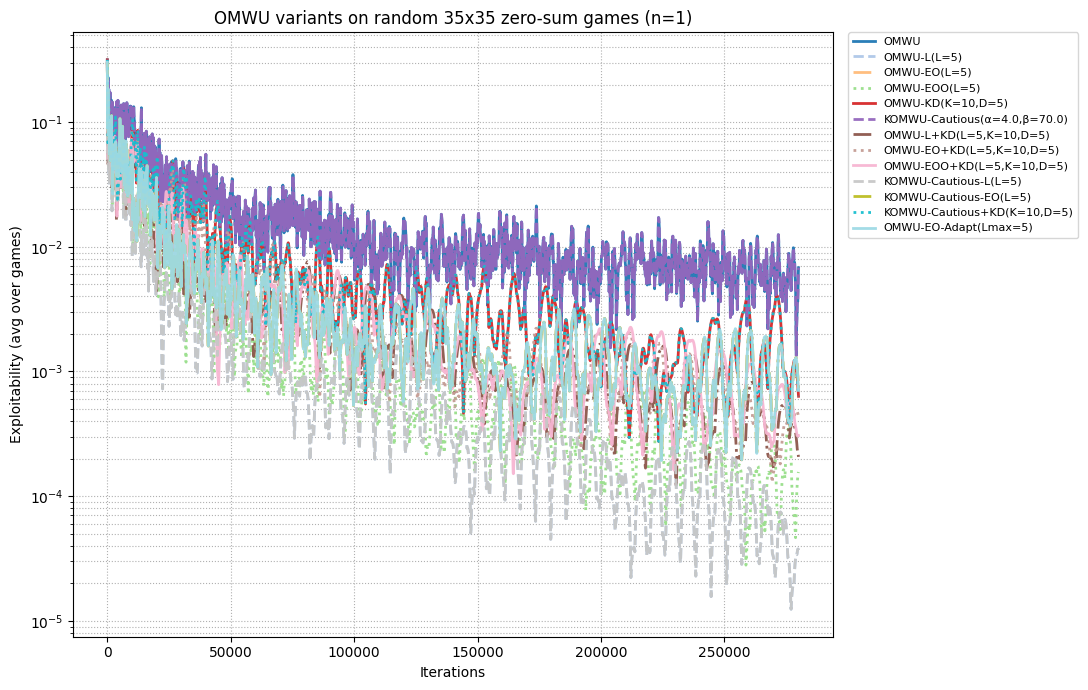

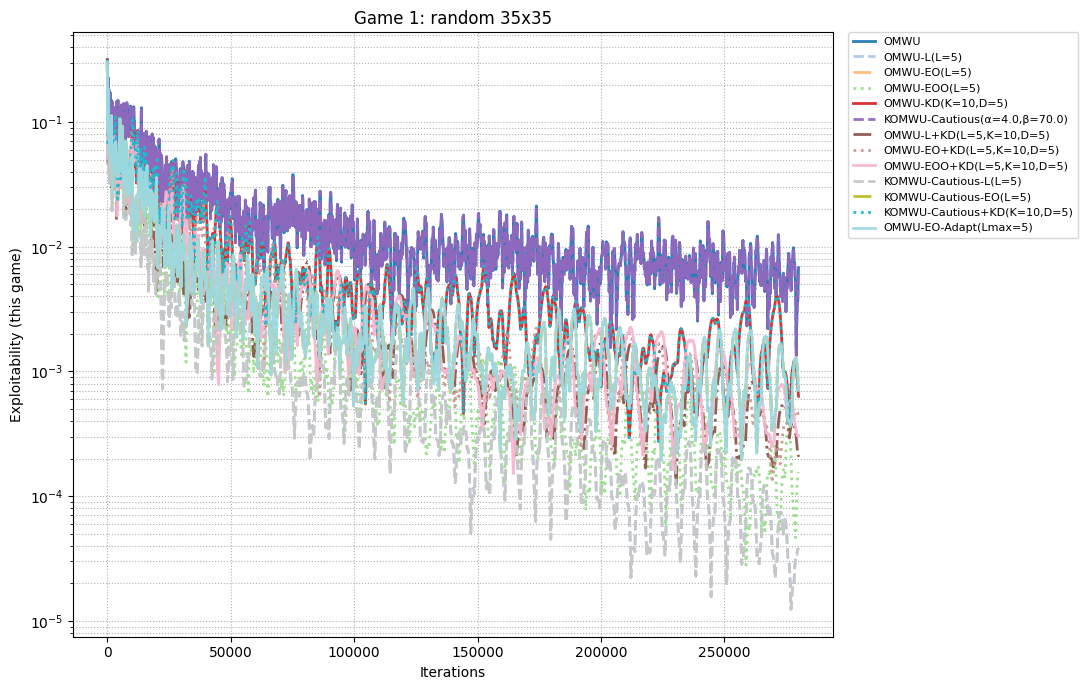

In [6]:
#!/usr/bin/env python3
"""
Standalone: OMWU family on random 5x5 zero-sum games, originals + new variants.
- DECAY-Gt variants removed per request.
- Prints the RNG seed used for each game.
- Distinct, consistent color+linestyle per variant across all plots.
- Per-game plots and an aggregate plot at the end.

Original variants (exact per user's spec, DECAY-Gt removed):
  OMWU:                d_t = 2 g_t − g_{t−1}
  OMWU-L:              d_t = (L+1) g_t − sum_{i=1}^L g_{t−i}
  OMWU-EO:             d_t = (L+1) g_t − L g_{t−1}
  OMWU-EOO:            d_t = (L+1) g_t − g_{t−1} − pending_t
                        pending_{t+1} = max(L−1,0) · g_{t−1}
  OMWU-DECAY:          d_t = α_b g_t − (α_b−1) g_{t−1}
                             + sum_{j=0}^{K_f−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
                        (ρ=1): d_t = (α_b+α_s) g_t − (α_b−1) g_{t−1} − α_s g_{t−K_f}
  OMWU-KD:             per step: Δb_t = η (2 g_t − g_{t−1}); b += Δb_t
                        every K_win steps: b -= sum of the first D_drop increments
  KOMWU-Cautious:      direction 2 g_t − g_{t−1}, adaptive step λ_t ∈ (0,η] from f(λ;r_t)

New variants included (mix & match of the same building blocks, still no DECAY-Gt):
  OMWU-DECAY-EO, OMWU-DECAY-L, OMWU-DECAY-EOO,
  KD-L, KD-EO, KD-EOO, DECAY-KD,
  KOMWU-Cautious-L, KOMWU-Cautious-EO, KOMWU-Cautious-KD,
  OMWU-EOO-Geo(γ), OMWU-EO-Adaptive(L_max),
  OMWU-EMA-BC (bias-corrected EMA tail),
  OMWU-DECAY-2H (two-horizon decay sums).
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Callable, Dict, List, Tuple

# ========================== CONFIG (edit me) ==========================
@dataclass
class Config:
    n_actions: int = 35           # 5x5 game
    n_games: int = 1             # number of random games
    T: int = 280000               # iterations per game
    eta: float = 0.1             # base step size

    # core breadth/decay defaults
    L: int = 5
    alpha_b: float = 1.0
    alpha_s: float = 5.0
    rho: float = 1.0
    Kf: int = 5

    # KD defaults
    K_win: int = 10
    D_drop: int = 5

    # cautious step defaults
    cautious_alpha: float = 4.0
    cautious_beta: float = 70.0
    cautious_newton_iters: int = 8
    cautious_newton_tol: float = 1e-12

    # extras for new variants
    geo_gamma: float = 0.5            # for OMWU-EOO-Geo
    L_max: int = 5                    # for OMWU-EO-Adaptive
    ema_beta: float = 0.9             # for OMWU-EMA-BC

    # two-horizon decay (2H)
    th_alpha_s1: float = 5.0
    th_rho1: float = 1.0
    th_Kf1: int = 5
    th_alpha_s2: float = 2.0
    th_rho2: float = 1.0
    th_Kf2: int = 20

    # logging / plotting
    seed: int = 0
    print_every: int = 500
    plot_every: int = 100

CFG = Config()
# =====================================================================

# ============== numerics (stable softmax, helpers) ====================
def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    s = e / np.sum(e)
    return s

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

# ============================ base agent ==============================
class AgentBase:
    def __init__(self, n: int, eta: float, label: str):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.b = np.zeros(n, dtype=float)
        self.x = softmax(self.b)
        self.t = 0
        self.g_prev = np.zeros(n, dtype=float)
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_grad(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, t_idx: int) -> np.ndarray:
        if t_idx <= 0 or t_idx > len(self._g_hist):
            return np.zeros(self.n, dtype=float)
        return self._g_hist[t_idx - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ============================ originals ===============================
class OMWU(AgentBase):
    def __init__(self, n: int, eta: float):
        super().__init__(n, eta, "OMWU")
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-L(L={L})")
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        d_t = (self.L + 1.0) * g_t - sum_past
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EO(L={L})")
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int):
        super().__init__(n, eta, f"OMWU-EOO(L={L})")
        self.L = int(L)
        self.pending = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_grad(g_t)

class OMWU_DECAY(AgentBase):
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.alpha_b = float(alpha_b); self.alpha_s = float(alpha_s)
        self.rho = float(rho); self.Kf = int(Kf)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

class OMWU_KD(AgentBase):
    def __init__(self, n: int, eta: float, K_win: int, D_drop: int):
        super().__init__(n, eta, f"OMWU-KD(K={K_win},D={D_drop})")
        self.K_win = int(K_win); self.D_drop = int(D_drop)
        self._win_increments: List[np.ndarray] = []; self._steps_in_block = 0
    def _end_block_prune(self):
        drop = min(self.D_drop, len(self._win_increments))
        if drop > 0:
            to_sub = np.sum(self._win_increments[:drop], axis=0)
            self.b -= to_sub
        self._win_increments.clear(); self._steps_in_block = 0
        self.x = softmax(self.b)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        delta_b = self.eta * d_t
        self.b += delta_b
        self._win_increments.append(delta_b)
        self._steps_in_block += 1
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)
        if self._steps_in_block >= self.K_win:
            self._end_block_prune()

# ======================= cautious step base/class =====================
class KOMWU_Cautious(AgentBase):
    """
    Direction: 2 g_t − g_{t−1}, step λ_t ∈ (0, η] via f(λ;r_t).
    """
    def __init__(self, n: int, eta: float, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, f"KOMWU-Cautious(α={alpha},β={beta})")
        self.alpha = float(alpha); self.beta = float(beta)
        self.iters = int(iters); self.tol = float(tol)
        self._ones = np.ones(n, dtype=float); self._U = np.zeros(n, dtype=float); self._u_last = np.zeros(n, dtype=float)
        self._d_ref = n
    def _choose_lambda(self, r: np.ndarray) -> float:
        maxr = float(np.max(r)); d = float(self._d_ref)
        thresh = - self.beta * (np.log(d) ** 2.0) if d > 1.0 else -self.beta
        if maxr >= thresh: return float(self.eta)
        eps = np.finfo(float).tiny
        lam = max((self.alpha - 1.0) / (-maxr + 1e-30), eps); lam = min(lam, float(self.eta))
        for _ in range(self.iters):
            z = lam * r; m = float(np.max(z)); e = np.exp(z - m); Z = float(np.sum(e)); p = e / Z
            Er = float(p @ r); Er2 = float(p @ (r * r)); Var = max(Er2 - Er * Er, 0.0)
            f1 = (self.alpha - 1.0) / lam + Er; f2 = -(self.alpha - 1.0) / (lam * lam) + Var
            if f2 >= -1e-30: break
            new_lam = float(min(max(lam - f1 / f2, eps), float(self.eta)))
            if abs(new_lam - lam) <= self.tol * max(1.0, lam): lam = new_lam; break
            lam = new_lam
        return float(lam)
    def _lambda_step(self, g_t: np.ndarray, base_direction: np.ndarray):
        r_t = self._U + self._u_last
        lam_t = self._choose_lambda(r_t)
        self.b += lam_t * base_direction
        self.x = softmax(self.b)
        gt_bar = float(g_t @ self.x)
        u_t = g_t - gt_bar * self._ones
        self._U += u_t; self._u_last = u_t.copy()
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self._lambda_step(g_t, d_t)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

# Cautious on EO base
class KOMWU_Cautious_EO(KOMWU_Cautious):
    def __init__(self, n: int, eta: float, L: int, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, alpha, beta, iters, tol)
        self.L = int(L); self.label = f"KOMWU-Cautious-EO(L={L})"
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        self._lambda_step(g_t, d_t)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

# Cautious on L base
class KOMWU_Cautious_L(KOMWU_Cautious):
    def __init__(self, n: int, eta: float, L: int, alpha: float, beta: float, iters: int, tol: float):
        super().__init__(n, eta, alpha, beta, iters, tol)
        self.L = int(L); self.label = f"KOMWU-Cautious-L(L={L})"
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        d_t = (self.L + 1.0) * g_t - sum_past
        self._lambda_step(g_t, d_t)
        self.g_prev = g_t.copy()
        self._push_grad(g_t)

# ================= new base/combination directions ====================
# DECAY + EO base
class OMWU_DECAY_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-EO(L={L},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.L = int(L); self.alpha_s = float(alpha_s); self.rho = float(rho); self.Kf = int(Kf)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.L + 1.0) * g_t - (self.L * self.g_prev)
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# DECAY + L base
class OMWU_DECAY_L_base(AgentBase):
    def __init__(self, n: int, eta: float, L: int, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-L(L={L},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.L = int(L); self.alpha_s = float(alpha_s); self.rho = float(rho); self.Kf = int(Kf)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        sum_past = np.zeros(self.n, dtype=float)
        for i in range(1, self.L + 1):
            sum_past += self._get_g(self.t - i)
        base = (self.L + 1.0) * g_t - sum_past
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# DECAY + EOO base
class OMWU_DECAY_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, alpha_s: float, rho: float, Kf: int):
        super().__init__(n, eta, f"OMWU-DECAY-EOO(L={L},αs={alpha_s},ρ={rho},Kf={Kf})")
        self.L = int(L); self.alpha_s = float(alpha_s); self.rho = float(rho); self.Kf = int(Kf)
        self.pending = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.L + 1.0) * g_t - self.g_prev - self.pending
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy(); self.pending = new_pending; self._push_grad(g_t)

# EOO with geometric pending
class OMWU_EOO_Geo(AgentBase):
    def __init__(self, n: int, eta: float, L: int, gamma: float):
        super().__init__(n, eta, f"OMWU-EOO-Geo(L={L},γ={gamma})")
        self.L = int(L); self.gamma = float(gamma)
        self.pending = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.L + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.pending = self.gamma * self.pending + max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# Adaptive EO breadth
class OMWU_EO_Adaptive(AgentBase):
    def __init__(self, n: int, eta: float, L_max: int):
        super().__init__(n, eta, f"OMWU-EO-Adapt(Lmax={L_max})")
        self.L_max = int(L_max)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        align = float(g_t @ self.g_prev)
        L_t = self.L_max if align >= 0.0 else 1
        d_t = (L_t + 1.0) * g_t - (L_t * self.g_prev)
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# Bias-corrected EMA tail (not DECAY-Gt)
class OMWU_EMA_BC(AgentBase):
    """
    EMA S_t = β S_{t-1} + (1-β) g_t, debiased Ŝ_t = S_t / (1-β^t).
    d_t = α_b g_t − (α_b−1) g_{t−1} + α_s (Ŝ_t − g_t).
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, beta: float):
        super().__init__(n, eta, f"OMWU-EMA-BC(αb={alpha_b},αs={alpha_s},β={beta})")
        self.alpha_b = float(alpha_b); self.alpha_s = float(alpha_s); self.beta = float(beta)
        self.S = np.zeros(n, dtype=float)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        self.S = self.beta * self.S + (1.0 - self.beta) * g_t
        debias = 1.0 - (self.beta ** self.t)
        S_hat = self.S / max(debias, 1e-30)
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self.alpha_s * (S_hat - g_t)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# Two-horizon decay: sum of two finite-diff tails
class OMWU_DECAY_2H(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1}
          + sum_{j=0}^{Kf1−1} α_s1 ρ1^j (g_{t−j} − g_{t−j−1})
          + sum_{j=0}^{Kf2−1} α_s2 ρ2^j (g_{t−j} − g_{t−j−1})
    """
    def __init__(self, n: int, eta: float, alpha_b: float,
                 alpha_s1: float, rho1: float, Kf1: int,
                 alpha_s2: float, rho2: float, Kf2: int):
        super().__init__(n, eta,
            f"OMWU-DECAY-2H(αb={alpha_b}; αs1={alpha_s1},ρ1={rho1},K1={Kf1}; αs2={alpha_s2},ρ2={rho2},K2={Kf2})")
        self.alpha_b = float(alpha_b)
        self.alpha_s1 = float(alpha_s1); self.rho1 = float(rho1); self.Kf1 = int(Kf1)
        self.alpha_s2 = float(alpha_s2); self.rho2 = float(rho2); self.Kf2 = int(Kf2)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = np.zeros(self.n, dtype=float)
        for j in range(0, self.Kf1):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s1 * (self.rho1 ** j)) * (g_tj - g_tj1)
        for j in range(0, self.Kf2):
            g_tj  = self._get_g(self.t - j) if j > 0 else g_t
            g_tj1 = self._get_g(self.t - j - 1)
            tail += (self.alpha_s2 * (self.rho2 ** j)) * (g_tj - g_tj1)
        d_t = base + tail
        self.b += self.eta * d_t; self.x = softmax(self.b)
        self.g_prev = g_t.copy(); self._push_grad(g_t)

# ====================== KD wrapper for any agent ======================
class KDWrapper(AgentBase):
    """
    Wrap any AgentBase and apply KD pruning on its logits.
    We capture per-step Δb by diffing inner.b before/after.
    """
    def __init__(self, inner_factory: Callable[[], AgentBase], K_win: int, D_drop: int, label_prefix: str):
        inner = inner_factory()
        super().__init__(inner.n, inner.eta, f"{label_prefix}+KD(K={K_win},D={D_drop})")
        self.inner = inner
        self.K_win = int(K_win); self.D_drop = int(D_drop)
        self._win_increments: List[np.ndarray] = []; self._steps_in_block = 0
    def next_strategy(self) -> np.ndarray: return self.inner.next_strategy()
    def observe_gradient(self, g_t: np.ndarray):
        b_before = self.inner.b.copy()
        self.inner.observe_gradient(g_t)
        delta_b = self.inner.b - b_before
        self._win_increments.append(delta_b); self._steps_in_block += 1
        if self._steps_in_block >= self.K_win:
            drop = min(self.D_drop, len(self._win_increments))
            if drop > 0:
                to_sub = np.sum(self._win_increments[:drop], axis=0)
                self.inner.b -= to_sub
                self.inner.x = softmax(self.inner.b)
            self._win_increments.clear(); self._steps_in_block = 0

# ========================== experiment harness ========================
def make_random_zero_sum_game(n: int, rng: np.random.Generator) -> np.ndarray:
    return rng.normal(0.0, 1.0, size=(n, n)).astype(float)

def build_agents(n: int, cfg: Config) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}
    def pair(factory: Callable[[], AgentBase]) -> Tuple[AgentBase, AgentBase]:
        a = factory(); b = factory(); return a, b

    # originals (DECAY-Gt removed)
    agents["OMWU"] = pair(lambda: OMWU(n, cfg.eta))
    agents[f"OMWU-L(L={cfg.L})"] = pair(lambda: OMWU_L(n, cfg.eta, cfg.L))
    agents[f"OMWU-EO(L={cfg.L})"] = pair(lambda: OMWU_EO(n, cfg.eta, cfg.L))
    agents[f"OMWU-EOO(L={cfg.L})"] = pair(lambda: OMWU_EOO(n, cfg.eta, cfg.L))
    # agents[f"OMWU-DECAY(αb={cfg.alpha_b},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )
    agents[f"OMWU-KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: OMWU_KD(n, cfg.eta, cfg.K_win, cfg.D_drop)
    )
    agents[f"KOMWU-Cautious(α={cfg.cautious_alpha},β={cfg.cautious_beta})"] = pair(
        lambda: KOMWU_Cautious(n, cfg.eta, cfg.cautious_alpha, cfg.cautious_beta,
                               cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )

    ###########D0
    # new combos (all DECAY-Gt references removed)
    # agents[f"OMWU-DECAY-EO(L={cfg.L},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY_EO(n, cfg.eta, cfg.L, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )
    # agents[f"OMWU-DECAY-L(L={cfg.L},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY_L_base(n, cfg.eta, cfg.L, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )
    # agents[f"OMWU-DECAY-EOO(L={cfg.L},αs={cfg.alpha_s},ρ={cfg.rho},Kf={cfg.Kf})"] = pair(
    #     lambda: OMWU_DECAY_EOO(n, cfg.eta, cfg.L, cfg.alpha_s, cfg.rho, cfg.Kf)
    # )

    # # KD wrappers for other bases
    agents[f"OMWU-L+KD(L={cfg.L},K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: OMWU_L(n, cfg.eta, cfg.L), cfg.K_win, cfg.D_drop, f"OMWU-L(L={cfg.L})")
    )
    agents[f"OMWU-EO+KD(L={cfg.L},K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: OMWU_EO(n, cfg.eta, cfg.L), cfg.K_win, cfg.D_drop, f"OMWU-EO(L={cfg.L})")
    )
    agents[f"OMWU-EOO+KD(L={cfg.L},K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: OMWU_EOO(n, cfg.eta, cfg.L), cfg.K_win, cfg.D_drop, f"OMWU-EOO(L={cfg.L})")
    )
    # agents[f"OMWU-DECAY+KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
    #     lambda: KDWrapper(lambda: OMWU_DECAY(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.rho, cfg.Kf),
    #                       cfg.K_win, cfg.D_drop, "OMWU-DECAY")
    # )

    ###########D9

    # cautious on other bases
    agents[f"KOMWU-Cautious-L(L={cfg.L})"] = pair(
        lambda: KOMWU_Cautious_L(n, cfg.eta, cfg.L, cfg.cautious_alpha, cfg.cautious_beta,
                                 cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )
    agents[f"KOMWU-Cautious-EO(L={cfg.L})"] = pair(
        lambda: KOMWU_Cautious_EO(n, cfg.eta, cfg.L, cfg.cautious_alpha, cfg.cautious_beta,
                                  cfg.cautious_newton_iters, cfg.cautious_newton_tol)
    )
    agents[f"KOMWU-Cautious+KD(K={cfg.K_win},D={cfg.D_drop})"] = pair(
        lambda: KDWrapper(lambda: KOMWU_Cautious(n, cfg.eta, cfg.cautious_alpha, cfg.cautious_beta,
                                                 cfg.cautious_newton_iters, cfg.cautious_newton_tol),
                          cfg.K_win, cfg.D_drop, "KOMWU-Cautious")
    )

    # # geo pending / adaptive EO / EMA-BC / two-horizon
    # agents[f"OMWU-EOO-Geo(L={cfg.L},γ={cfg.geo_gamma})"] = pair(
    #     lambda: OMWU_EOO_Geo(n, cfg.eta, cfg.L, cfg.geo_gamma)
    # )
    agents[f"OMWU-EO-Adapt(Lmax={cfg.L_max})"] = pair(
        lambda: OMWU_EO_Adaptive(n, cfg.eta, cfg.L_max)
    )
    # agents[f"OMWU-EMA-BC(β={cfg.ema_beta})"] = pair(
    #     lambda: OMWU_EMA_BC(n, cfg.eta, cfg.alpha_b, cfg.alpha_s, cfg.ema_beta)
    # )
    # agents["OMWU-DECAY-2H"] = pair(
    #     lambda: OMWU_DECAY_2H(n, cfg.eta, cfg.alpha_b,
    #                           cfg.th_alpha_s1, cfg.th_rho1, cfg.th_Kf1,
    #                           cfg.th_alpha_s2, cfg.th_rho2, cfg.th_Kf2)
    # )
    return agents

def sampling_times(cfg: Config) -> List[int]:
    return [1] + list(range(cfg.plot_every, cfg.T + 1, cfg.plot_every))

def run_one_game(A: np.ndarray, cfg: Config):
    agents = build_agents(A.shape[0], cfg)
    times = sampling_times(cfg)
    records = {lbl: {"times": [], "exploit": []} for lbl in agents.keys()}

    for t in range(1, cfg.T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy(); y = col.next_strategy()
            g_row = row_grad(A, y); g_col = col_grad(A, x)
            row.observe_gradient(g_row); col.observe_gradient(g_col)
            if t == 1 or (t % cfg.plot_every) == 0:
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t); records[lbl]["exploit"].append(ex)
        if (t % cfg.print_every) == 0 or t == 1:
            msg = [f"t={t:6d}"]
            for lbl in agents.keys():
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # align lengths (safety)
    Tref = len(times)
    for lbl in records:
        if len(records[lbl]["times"]) != Tref:
            m = min(len(records[lbl]["times"]), len(records[lbl]["exploit"]), Tref)
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]
    return times, records

# ---------- plotting helpers: consistent styles across figures ----------
def make_style_map(labels: List[str]):
    # Build a long, distinct palette and rotate linestyles for extra separation.
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab20', len(labels))  # discrete sampling, repeats gracefully >20
    linestyles = ['-', '--', '-.', ':']
    style_map = {}
    for i, lbl in enumerate(labels):
        color = cmap(i)
        ls = linestyles[i % len(linestyles)]
        style_map[lbl] = dict(color=color, linestyle=ls, linewidth=2.0, alpha=0.95)
    return style_map

def plot_aggregate(all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]], style_map: Dict[str, dict], cfg: Config):
    labels = list(all_runs[0][1].keys())
    times = np.array(all_runs[0][0], dtype=float)
    # aggregate
    agg_mean = {lbl: [] for lbl in labels}
    for lbl in labels:
        mat = []
        for _, rec in all_runs:
            ys = np.array(rec[lbl]["exploit"], dtype=float)
            m = min(len(ys), len(times))
            mat.append(ys[:m])
        M = np.vstack(mat)
        agg_mean[lbl] = M.mean(axis=0)

    plt.figure(figsize=(11, 7))
    for lbl in labels:
        ys = agg_mean[lbl]
        style = style_map[lbl]
        plt.plot(times[:len(ys)], ys, label=lbl, **style)
    plt.yscale("log")
    plt.xlabel("Iterations"); plt.ylabel("Exploitability (avg over games)")
    plt.title(f"OMWU variants on random {cfg.n_actions}x{cfg.n_actions} zero-sum games (n={cfg.n_games})")
    plt.grid(True, which="both", ls=":")
    # larger legend outside the plot area for readability
    plt.legend(fontsize=8, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

def plot_per_game(per_game: List[Tuple[int, List[int], Dict[str, Dict[str, List[float]]], np.ndarray]], style_map: Dict[str, dict], cfg: Config):
    for (g, times, records, A) in per_game:
        plt.figure(figsize=(11, 7))
        for lbl, rec in records.items():
            xs = np.array(rec["times"], dtype=float)
            ys = np.array(rec["exploit"], dtype=float)
            style = style_map[lbl]
            plt.plot(xs, ys, label=lbl, **style)
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (this game)")
        plt.title(f"Game {g}: random {cfg.n_actions}x{cfg.n_actions}")
        plt.grid(True, which="both", ls=":")
        plt.legend(fontsize=8, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
        plt.tight_layout()
        plt.show()

# =============================== main =================================
def main():
    print("Config:", asdict(CFG))
    base_rng = np.random.default_rng(CFG.seed)
    all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]] = []
    per_game: List[Tuple[int, List[int], Dict[str, Dict[str, List[float]]], np.ndarray]] = []

    for g in range(1, CFG.n_games + 1):
        game_seed = int(base_rng.integers(0, 2**63 - 1))
        game_rng = np.random.default_rng(game_seed)
        A = make_random_zero_sum_game(CFG.n_actions, game_rng)
        print(f"\n=== Game {g}/{CFG.n_games}  seed={game_seed}  (random {CFG.n_actions}x{CFG.n_actions}) ===")
        times, records = run_one_game(A, CFG)
        all_runs.append((times, records))
        per_game.append((g, times, records, A))

    # Build a consistent style map (based on first run's labels)
    labels = list(all_runs[0][1].keys())
    style_map = make_style_map(labels)

    # Aggregate + per-game plots
    plot_aggregate(all_runs, style_map, CFG)
    plot_per_game(per_game, style_map, CFG)

if __name__ == "__main__":
    main()


In [7]:
######################################################
######################################################

GlobalConfig: {'n_games_per_type': 3, 'T': 4001, 'print_every': 500, 'plot_every': 100, 'seed': 0, 'dtype': 'float64'}
VariantConfig: {'OMWU': {'eta': 0.7}, 'OMWU-L': {'eta': 0.3, 'L': 3}, 'OMWU-EO': {'eta': 0.3, 'L': 3}, 'OMWU-EOO': {'eta': 0.3, 'L': 3}, 'OMWU-DECAY': {'eta': 0.3, 'alpha_b': 1.0, 'alpha_s': 3.0, 'rho': 1.0, 'Kf': 4}}

=== random_5  |  game 1/3  |  seed=5874934615388537134  |  n=5 ===
[progress] t=     1  OMWU: ex=2.874e-01  OMWU-L(L=3): ex=3.033e-01  OMWU-EO(L=3): ex=3.033e-01  OMWU-EOO(L=3): ex=3.033e-01  OMWU-DECAY(αb=1.0,αs=3.0,ρ=1.0,Kf=4): ex=3.033e-01
[progress] t=   500  OMWU: ex=8.279e-08  OMWU-L(L=3): ex=2.396e-11  OMWU-EO(L=3): ex=3.771e-07  OMWU-EOO(L=3): ex=1.861e-10  OMWU-DECAY(αb=1.0,αs=3.0,ρ=1.0,Kf=4): ex=1.904e-01
[progress] t=  1000  OMWU: ex=1.685e-13  OMWU-L(L=3): ex=3.005e-15  OMWU-EO(L=3): ex=4.614e-12  OMWU-EOO(L=3): ex=3.095e-15  OMWU-DECAY(αb=1.0,αs=3.0,ρ=1.0,Kf=4): ex=2.545e-01
[progress] t=  1500  OMWU: ex=4.191e-15  OMWU-L(L=3): ex=3.067e-15 

/tmp/ipython-input-836999885.py:385: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


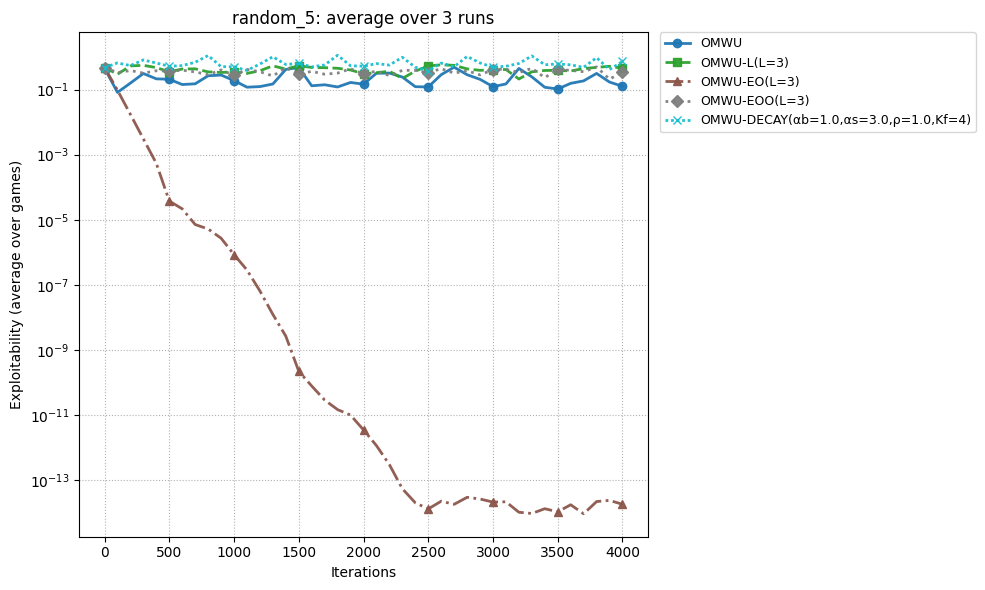

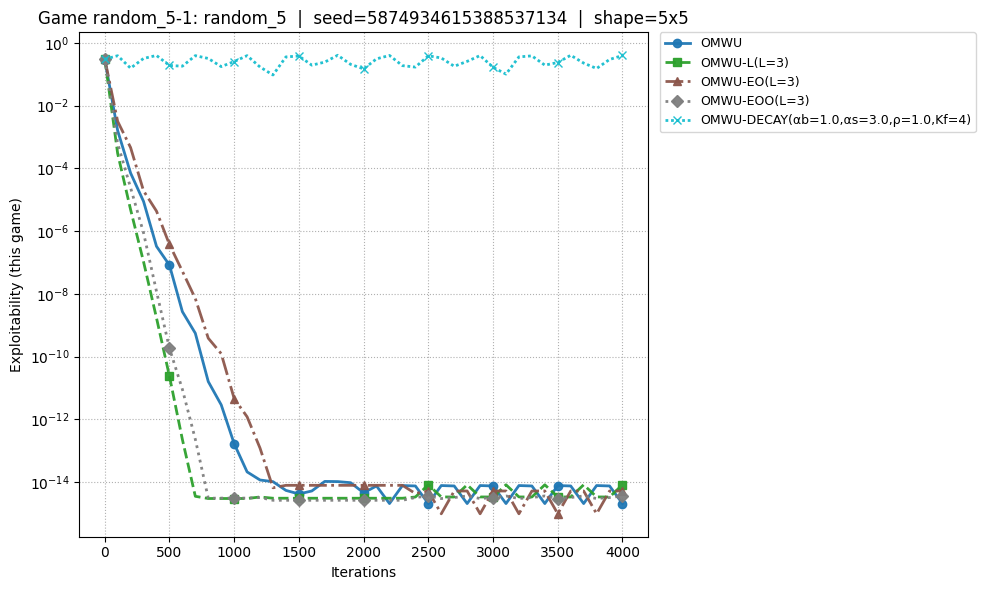

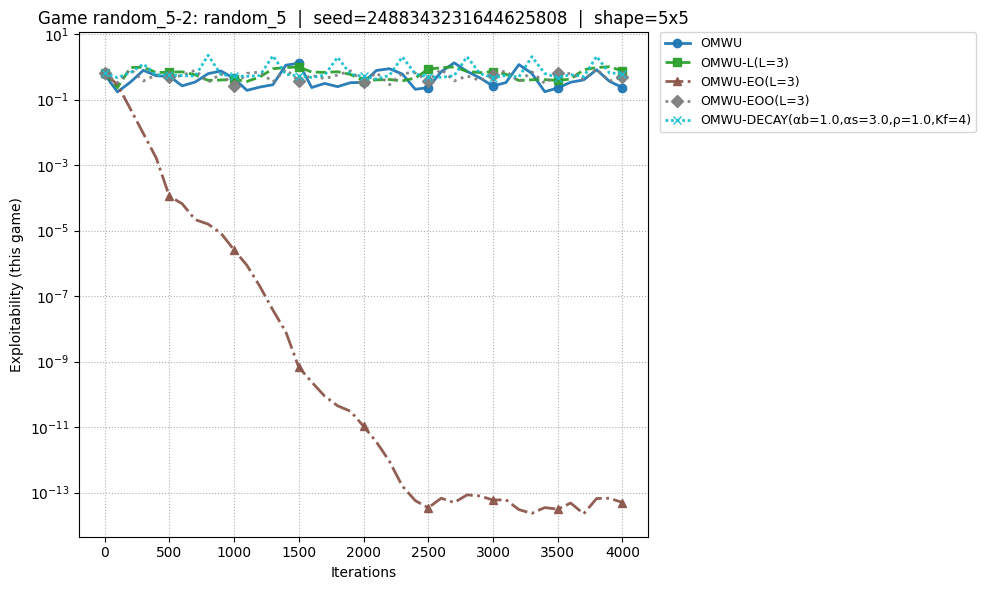

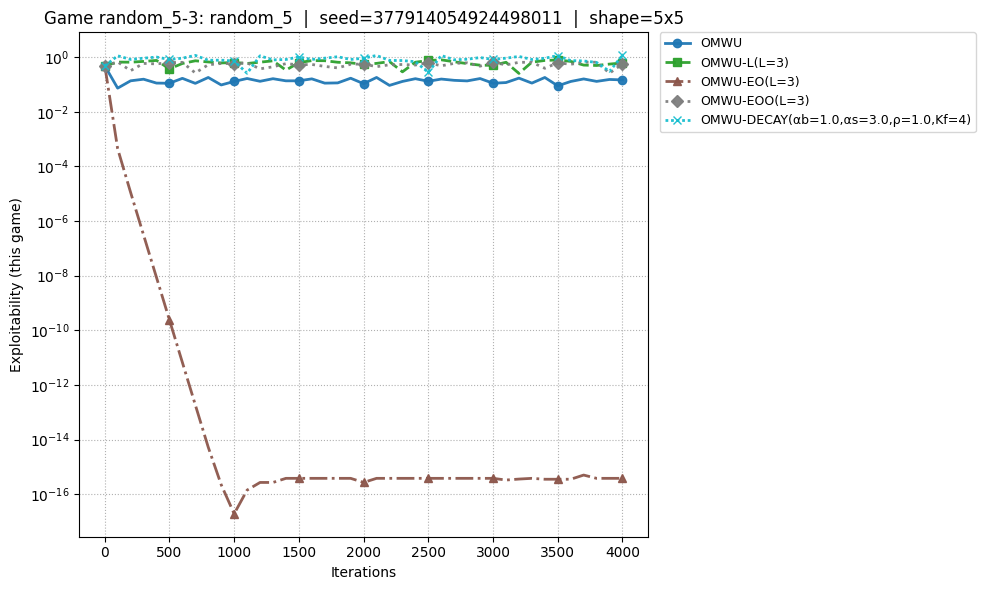

In [54]:
#!/usr/bin/env python3
"""
OMWU / L / EO / EOO / DECAY on five zero-sum game types.
- Per-variant hyperparameters (η, L, α_b, α_s, ρ, K_f) are independently configurable.
- Prints progress (with seeds), per-game plots, and an aggregate plot.
- Distinct color+linestyle per variant, consistent across figures.

Game types included:
  1) biased_rps_3    (3x3 biased Rock–Paper–Scissors)
  2) rpsls_5         (5x5 Rock–Paper–Scissors–Lizard–Spock ; non-vanilla RPS)
  3) cyclic_5        (5x5 cyclic / Shapley-style)
  4) lowrank_5       (5x5 low-rank, structured)
  5) random_5        (5x5 Gaussian random)

Row payoff = A; Column payoff = -A.
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Callable

# ========================= USER CONFIG (edit me) =========================

@dataclass
class GlobalConfig:
    # how many different instances (seeds) per game type
    n_games_per_type: int = 3
    # iterations per run
    T: int = 4001
    # logging / sampling
    print_every: int = 500
    plot_every: int = 100
    # master RNG seed
    seed: int = 0
    # numeric dtype
    dtype: str = "float64"  # "float64" or "longdouble"

GC = GlobalConfig()

# Per-variant independent hyperparameters.
# You can change η for each variant separately and (where applicable) L, α_b, α_s, ρ, K_f.
VARIANT_CFG = {
    "OMWU":        {"eta": 0.7},
    "OMWU-L":      {"eta": 0.3, "L": 3},
    "OMWU-EO":     {"eta": 0.3, "L": 3},
    "OMWU-EOO":    {"eta": 0.3, "L": 3},
    "OMWU-DECAY":  {"eta": 0.3, "alpha_b": 1.0, "alpha_s": 3.0, "rho": 1.0, "Kf": 4},
}

# Which game types to run (from the five defined below)
GAME_TYPES = ["random_5"] #["biased_rps_3"] #, "rpsls_5", "cyclic_5", "lowrank_5", "random_5"]

# ========================================================================


# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    s = e / np.sum(e)
    return s

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit


# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        # a general gradient history (most recent at end); we use helpers to fetch safely
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, t_idx_from_1: int) -> np.ndarray:
        # t_idx_from_1==len(_g_hist) → last
        if t_idx_from_1 <= 0 or t_idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[t_idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError


# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window sums after using
        self._histL.insert(0, g_t.copy())
        self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop()
            self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ------------------------------ OMWU-EO -----------------------------------

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EO(L={L})", DTYPE)
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - (self.DTYPE(self.L) * self.g_prev)
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)


# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        # history indices: current step has index self.t after we increment in observe_gradient
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)


# ============================== game zoo =================================

def make_biased_rps_3(delta: float = 0.2) -> np.ndarray:
    """
    3x3 biased RPS: base antisymmetric, one edge boosted by (1+delta).
      R beats S: +1
      P beats R: +1
      S beats P: +(1+delta)  <-- bias
    """
    A = np.array([[0.0, -1.0, +1.0],
                  [+1.0, 0.0, -(1.0 + delta)],
                  [-(1.0), +(1.0 + delta), 0.0]], dtype=float)
    return A

def make_rpsls_5() -> np.ndarray:
    """
    5x5 Rock–Paper–Scissors–Lizard–Spock (non-vanilla RPS), antisymmetric with +1/-1 outcomes.
    Order: 0=Rock,1=Paper,2=Scissors,3=Lizard,4=Spock
    Edges (winner→loser): R>S,L ; P>R,Sp ; S>P,L ; L>Sp,P ; Sp>S,R
    """
    n = 5
    A = np.zeros((n, n), dtype=float)
    wins = [(0,2),(0,3),(1,0),(1,4),(2,1),(2,3),(3,4),(3,1),(4,2),(4,0)]
    for i,j in wins:
        A[i,j] = +1.0
        A[j,i] = -1.0
    return A

def make_cyclic_5(strength: float = 1.0) -> np.ndarray:
    """
    5x5 cyclic (Shapley-style): i beats (i+1) mod 5 by +strength, loses to (i-1) by -strength.
    Others 0. Antisymmetric band matrix.
    """
    n = 5
    A = np.zeros((n, n), dtype=float)
    for i in range(n):
        A[i, (i+1) % n] = +strength
        A[(i+1) % n, i] = -strength
    return A

def make_lowrank_5(rank: int = 2, scale: float = 1.0, rng=None) -> np.ndarray:
    """
    5x5 low-rank (U V^T), then antisymmetrized to ensure zero-sum skew part dominates.
    """
    if rng is None:
        rng = np.random.default_rng()
    U = rng.normal(0.0, scale, size=(5, rank))
    V = rng.normal(0.0, scale, size=(5, rank))
    M = U @ V.T
    A = (M - M.T) / 2.0  # antisymmetric part
    return A

def make_random_5(scale: float = 1.0, rng=None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng()
    A = rng.normal(0.0, scale, size=(5, 5))
    return A

def gen_game(game_type: str, rng: np.random.Generator) -> np.ndarray:
    if game_type == "biased_rps_3":
        return make_biased_rps_3(delta=0.2)
    elif game_type == "rpsls_5":
        return make_rpsls_5()
    elif game_type == "cyclic_5":
        return make_cyclic_5(strength=1.0)
    elif game_type == "lowrank_5":
        return make_lowrank_5(rank=2, scale=1.0, rng=rng)
    elif game_type == "random_5":
        return make_random_5(scale=1.0, rng=rng)
    else:
        raise ValueError(f"Unknown game_type: {game_type}")


# ============================ experiment core =============================

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

def make_agents(n: int, DTYPE, variant_cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    # Build symmetrical row/col agent pairs for each variant, with its own hyperparams
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = variant_cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = variant_cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO
    p = variant_cfg["OMWU-EO"]
    agents[f"OMWU-EO(L={p['L']})"] = (OMWU_EO(n, p["eta"], p["L"], DTYPE), OMWU_EO(n, p["eta"], p["L"], DTYPE))

    # OMWU-EOO
    p = variant_cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = variant_cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )

    return agents

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int, agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    times = sampling_times(T, plot_every)
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy()
                y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # align lengths (safety)
    Tref = len(times)
    for lbl in records:
        if len(records[lbl]["times"]) != Tref:
            m = min(len(records[lbl]["times"]), len(records[lbl]["exploit"]), Tref)
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]
    return times, records


# =============================== plotting =================================

def make_style_map(labels: List[str]):
    # 5 variants → tab10 gives distinct colors; rotate linestyles to be extra clear
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.0, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5)
    return style_map

def plot_aggregate(all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]], style_map, title: str):
    labels = list(all_runs[0][1].keys())
    times = np.array(all_runs[0][0], dtype=float)
    agg_mean = {lbl: [] for lbl in labels}

    for lbl in labels:
        mat = []
        for _, rec in all_runs:
            ys = np.array(rec[lbl]["exploit"], dtype=float)
            m = min(len(ys), len(times))
            mat.append(ys[:m])
        M = np.vstack(mat)
        agg_mean[lbl] = M.mean(axis=0)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        ys = np.array(agg_mean[lbl], dtype=float)
        plt.plot(times[:len(ys)], ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations"); plt.ylabel("Exploitability (average over games)")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

def plot_per_game(per_game_runs, style_map):
    for (idx, game_type, seed, times, records, A) in per_game_runs:
        plt.figure(figsize=(10, 6))
        for lbl, rec in records.items():
            xs = np.array(rec["times"], dtype=float)
            ys = np.array(rec["exploit"], dtype=float)
            plt.plot(xs, ys, label=lbl, **style_map[lbl])
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (this game)")
        plt.title(f"Game {idx}: {game_type}  |  seed={seed}  |  shape={A.shape[0]}x{A.shape[1]}")
        plt.grid(True, which="both", ls=":")
        plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
        plt.tight_layout()
        plt.show()


# ================================= main ===================================

def main():
    print("GlobalConfig:", asdict(GC))
    print("VariantConfig:", VARIANT_CFG)

    DTYPE = get_dtype(GC.dtype)
    base_rng = np.random.default_rng(GC.seed)

    all_runs: List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]] = []
    per_game_runs = []

    all_labels = None  # capture once for consistent styling
    for gtype in GAME_TYPES:
        for j in range(1, GC.n_games_per_type + 1):
            game_seed = int(base_rng.integers(0, 2**63 - 1))
            rng = np.random.default_rng(game_seed)
            A = gen_game(gtype, rng)
            n = A.shape[0]

            # build fresh agents for this game (per-variant settings)
            agents = make_agents(n, DTYPE, VARIANT_CFG)

            # record labels (same across runs)
            if all_labels is None:
                all_labels = list(agents.keys())

            print(f"\n=== {gtype}  |  game {j}/{GC.n_games_per_type}  |  seed={game_seed}  |  n={n} ===")
            times, records = run_one_game(A, GC.T, GC.plot_every, GC.print_every, agents)
            all_runs.append((times, records))
            per_game_runs.append((f"{gtype}-{j}", gtype, game_seed, times, records, A))

    # Consistent styling across all figs
    style_map = make_style_map(all_labels)

    # Aggregate plot per game type (avg over its runs)
    # Group runs by game type
    from collections import defaultdict
    grouped: Dict[str, List[Tuple[List[int], Dict[str, Dict[str, List[float]]]]]] = defaultdict(list)
    for (idx, gtype, seed, times, records, A) in per_game_runs:
        grouped[gtype].append((times, records))

    for gtype, runs in grouped.items():
        plot_aggregate(runs, style_map, title=f"{gtype}: average over {len(runs)} runs")

    # Per-game plots
    plot_per_game(per_game_runs, style_map)


if __name__ == "__main__":
    main()


In [55]:
##################################################
##################################################

Config: {'T': 12000, 'print_every': 500, 'plot_every': 100, 'seed': 0, 'dtype': 'float64', 'n': 5, 'random_scale': 1.0}
Variant hyperparameters: {'OMWU': {'eta': 1.0}, 'OMWU-EO': {'eta': 0.5, 'L': 3}, 'OMWU-EOO': {'eta': 0.1, 'L': 5}, 'OMWU-L': {'eta': 0.1, 'L': 5}, 'OMWU-DECAY': {'eta': 0.1, 'alpha_b': 1.0, 'alpha_s': 4.0, 'rho': 1.0, 'Kf': 5}}
[info] Single random game generated  |  seed=0  |  shape=(5, 5)
[progress] t=     1  OMWU: ex=1.073e-01  OMWU-L(L=5): ex=2.260e-01  OMWU-EO(L=3): ex=1.073e-01  OMWU-EOO(L=5): ex=2.260e-01  OMWU-DECAY(αb=1.0,αs=4.0,ρ=1.0,Kf=5): ex=2.441e-01
[progress] t=   500  OMWU: ex=8.427e-03  OMWU-L(L=5): ex=1.137e-02  OMWU-EO(L=3): ex=1.018e-02  OMWU-EOO(L=5): ex=1.182e-02  OMWU-DECAY(αb=1.0,αs=4.0,ρ=1.0,Kf=5): ex=1.099e-02
[progress] t=  1000  OMWU: ex=6.292e-03  OMWU-L(L=5): ex=2.274e-02  OMWU-EO(L=3): ex=5.264e-03  OMWU-EOO(L=5): ex=2.595e-02  OMWU-DECAY(αb=1.0,αs=4.0,ρ=1.0,Kf=5): ex=1.998e-02
[progress] t=  1500  OMWU: ex=3.411e-03  OMWU-L(L=5): ex=6.2

/tmp/ipython-input-512593248.py:263: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


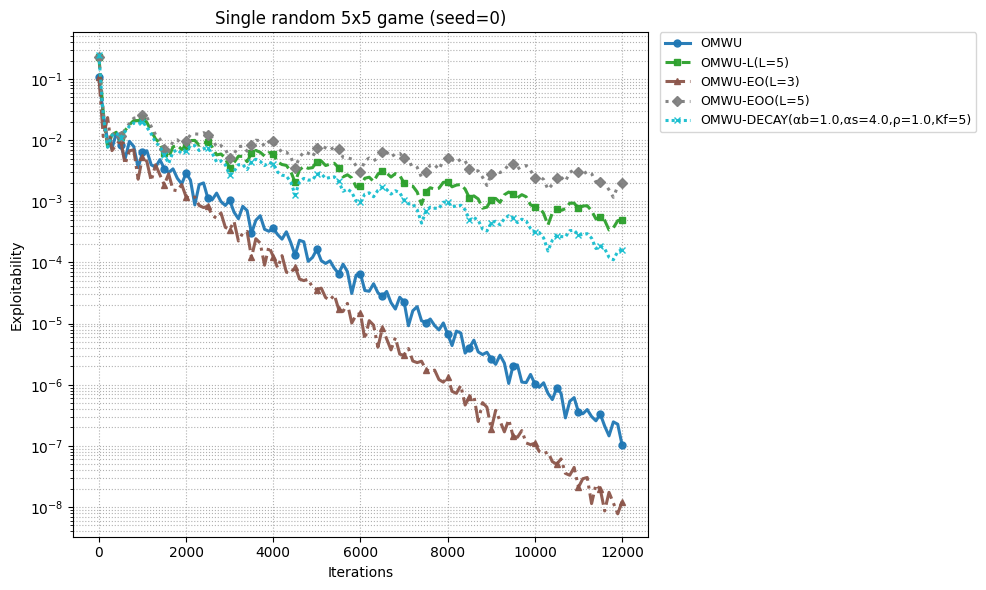

In [95]:
#!/usr/bin/env python3
"""
Single run on one random 5x5 zero-sum game:
  - Variants: OMWU, OMWU-L, OMWU-EO, OMWU-EOO, OMWU-DECAY
  - Independent hyperparameters per variant (eta, L, alpha_b, alpha_s, rho, Kf)
  - Progress printing + one plot at the end
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

# ========================= USER CONFIG (edit me) =========================

@dataclass
class Config:
    T: int = 12000               # iterations
    print_every: int = 500       # console progress
    plot_every: int = 100        # sampling for curves
    seed: int = 0                # RNG seed for the single random game
    dtype: str = "float64"       # "float64" or "longdouble"
    n: int = 5                   # game size (n x n)
    random_scale: float = 1.0    # std-dev for random payoff entries

CFG = Config()

# Per-variant independent hyperparameters
VARIANT_CFG = {
    "OMWU":        {"eta": 1.0}, # 1.05 breaks this
    # "OMWU-EO":     {"eta": 0.67, "L": 2}, # BEST 1.3333
    "OMWU-EO":     {"eta": 0.50, "L": 3},   # BEST 1.5
    # "OMWU-EO":     {"eta": 0.1, "L": 10},   #
    "OMWU-EOO":    {"eta": 0.10, "L": 5},
    "OMWU-L":      {"eta": 0.10, "L": 5},
    "OMWU-DECAY":  {"eta": 0.10, "alpha_b": 1.0, "alpha_s": 4.0, "rho": 1.0, "Kf": 5},
}

# ========================================================================

# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    return e / np.sum(e)

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, idx_from_1: int) -> np.ndarray:
        if idx_from_1 <= 0 or idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window after using it
        self._histL.insert(0, g_t.copy()); self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop(); self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EO -----------------------------------

class OMWU_EO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EO(L={L})", DTYPE)
        self.L = int(L)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - (self.DTYPE(self.L) * self.g_prev)
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)

# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ============================== game maker ================================

def make_random_zero_sum(n: int, scale: float, rng: np.random.Generator) -> np.ndarray:
    """
    Single random zero-sum game for the row player:
      Row payoff = A; Column payoff = -A.
    """
    A = rng.normal(0.0, scale, size=(n, n))
    return A

# ============================ experiment core =============================

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int,
                 agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Length alignment (safety)
    t_ref = None
    for lbl in records:
        if t_ref is None:
            t_ref = len(records[lbl]["times"])
        else:
            m = min(t_ref, len(records[lbl]["times"]), len(records[lbl]["exploit"]))
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]

    return records

# =============================== plotting =================================

def make_style_map(labels: List[str]):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.2, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5, markersize=5)
    return style_map

def plot_single(records, title: str):
    labels = list(records.keys())
    style_map = make_style_map(labels)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        xs = np.array(records[lbl]["times"], dtype=float)
        ys = np.array(records[lbl]["exploit"], dtype=float)
        plt.plot(xs, ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ================================= main ===================================

def make_agents(n: int, DTYPE, cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO
    p = cfg["OMWU-EO"]
    agents[f"OMWU-EO(L={p['L']})"] = (OMWU_EO(n, p["eta"], p["L"], DTYPE), OMWU_EO(n, p["eta"], p["L"], DTYPE))

    # OMWU-EOO
    p = cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )
    return agents

def main():
    print("Config:", asdict(CFG))
    print("Variant hyperparameters:", VARIANT_CFG)
    DTYPE = get_dtype(CFG.dtype)
    rng = np.random.default_rng(CFG.seed)

    # Build one random game (row payoff A, col payoff -A)
    A = make_random_zero_sum(CFG.n, CFG.random_scale, rng)
    print(f"[info] Single random game generated  |  seed={CFG.seed}  |  shape={A.shape}")

    # Build agents (per-variant hyperparameters)
    agents = make_agents(CFG.n, DTYPE, VARIANT_CFG)

    # Run
    records = run_one_game(A, CFG.T, CFG.plot_every, CFG.print_every, agents)

    # Plot
    plot_single(records, title=f"Single random {CFG.n}x{CFG.n} game (seed={CFG.seed})")

if __name__ == "__main__":
    main()


In [96]:
#########################################
###########################################

Config: {'T': 20000, 'print_every': 500, 'plot_every': 10, 'seed': 53, 'dtype': 'float64', 'n': 8, 'random_scale': 1.0}
Variant hyperparameters: {'OMWU': {'eta': 1.0}, 'OMWU-L': {'eta': 0.51, 'L': 2}, 'OMWU-EO': {'eta': 0.67, 'alpha': 2.0}, 'OMWU-EOO': {'eta': 0.34, 'L': 3}, 'OMWU-DECAY': {'eta': 0.5, 'alpha_b': 1.0, 'alpha_s': 2.0, 'rho': 0.5, 'Kf': 2}}
[info] Single random game generated  |  seed=53  |  shape=(8, 8)
[progress] t=     1  OMWU: ex=3.654e-01  OMWU-L(L=2): ex=3.880e-01  OMWU-EO(α=2.0): ex=3.650e-01  OMWU-EOO(L=3): ex=3.979e-01  OMWU-DECAY(αb=1.0,αs=2.0,ρ=0.5,Kf=2): ex=3.897e-01
[progress] t=   500  OMWU: ex=8.198e-02  OMWU-L(L=2): ex=1.272e-01  OMWU-EO(α=2.0): ex=6.816e-02  OMWU-EOO(L=3): ex=1.602e-01  OMWU-DECAY(αb=1.0,αs=2.0,ρ=0.5,Kf=2): ex=1.028e-01
[progress] t=  1000  OMWU: ex=7.766e-02  OMWU-L(L=2): ex=1.621e-01  OMWU-EO(α=2.0): ex=8.853e-02  OMWU-EOO(L=3): ex=1.545e-01  OMWU-DECAY(αb=1.0,αs=2.0,ρ=0.5,Kf=2): ex=1.015e-01
[progress] t=  1500  OMWU: ex=5.968e-02  OMW

/tmp/ipython-input-2667240662.py:288: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


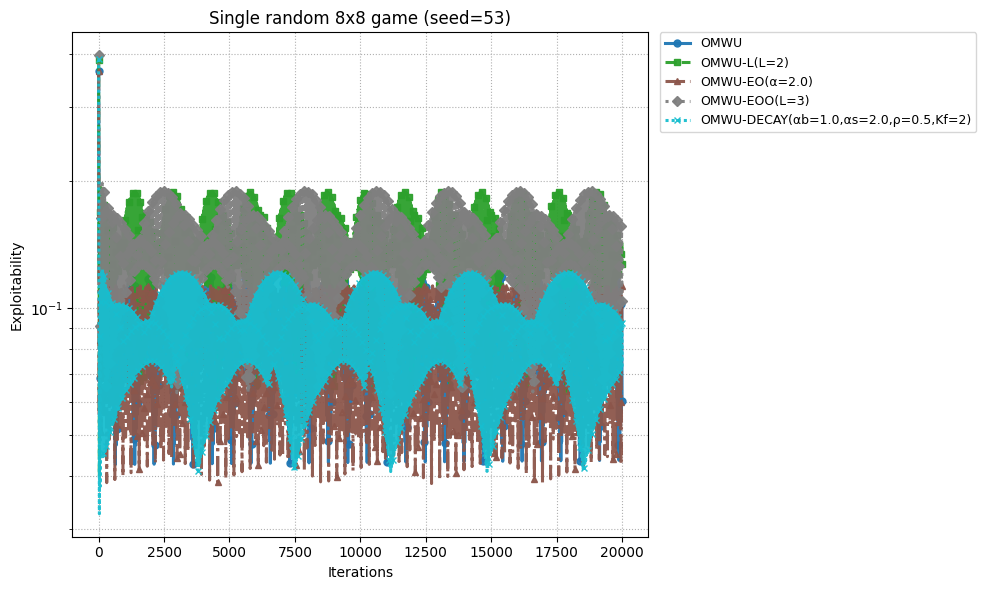

In [14]:
#!/usr/bin/env python3
"""
Single run on one random 5x5 zero-sum game:
  - Variants: OMWU, OMWU-L, OMWU-EO (now with fractional alpha), OMWU-EOO, OMWU-DECAY
  - Independent hyperparameters per variant (eta, L/alpha, alpha_b, alpha_s, rho, Kf)
  - Progress printing + one plot at the end
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

# ========================= USER CONFIG (edit me) =========================

# "OMWU-EO":     {"eta": 0.67, "L": 2}, # BEST 1.3333
    # "OMWU-EO":     {"eta": 0.50, "L": 3},   # BEST 1.5

@dataclass
class Config:
    T: int = 20000               # iterations
    print_every: int = 500       # console progress
    plot_every: int = 10        # sampling for curves
    seed: int = 53               # RNG seed for the single random game
    dtype: str = "float64"       # "float64" or "longdouble"
    n: int = 8                   # game size (n x n)
    random_scale: float = 1.0    # std-dev for random payoff entries

CFG = Config()

# Per-variant independent hyperparameters
# NOTE: OMWU-EO now supports fractional alpha via key "alpha".
#       If "alpha" is absent but "L" is present, we use alpha=float(L) for backward-compat.

# "OMWU-EO":     {"eta": 0.67, "L": 2}, # BEST 1.3333
# "OMWU-EO":     {"eta": 0.50, "L": 3},   # BEST 1.5
VARIANT_CFG = {
    "OMWU":        {"eta": 1.0},
    "OMWU-L":      {"eta": 0.51, "L": 2},
    # Examples for EO alpha:
    #   alpha=0.5 -> 1.5*g_t - 0.5*g_{t-1}
    #   alpha=1.2 -> 2.2*g_t - 1.2*g_{t-1}
    "OMWU-EO":     {"eta": 0.67, "alpha": 2.0}, # BEST
    # "OMWU-EOO":    {"eta": 0.51, "L": 2},
    "OMWU-EOO":    {"eta": 0.34, "L": 3},
    "OMWU-DECAY":  {"eta": 0.50, "alpha_b": 1.0, "alpha_s": 2.0, "rho": 0.5, "Kf": 2},
}

# ========================================================================

# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    return e / np.sum(e)

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, idx_from_1: int) -> np.ndarray:
        if idx_from_1 <= 0 or idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window after using it
        self._histL.insert(0, g_t.copy()); self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop(); self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EO (fractional alpha) ----------------

class OMWU_EO(AgentBase):
    """
    EO with fractional alpha:
      d_t = (1 + alpha) * g_t - alpha * g_{t-1}
           = 1 * g_t + alpha * (g_t - g_{t-1})
    If 'alpha' not provided, but 'L' is, uses alpha = float(L) (backward compatible).
    """
    def __init__(self, n: int, eta: float, alpha: float | None = None, L: int | None = None, DTYPE=None):
        # Resolve alpha (fractional allowed). If only L given, alpha = float(L).
        if alpha is None and L is None:
            raise ValueError("OMWU_EO requires 'alpha' (float) or 'L' (int/float).")
        if alpha is None:
            alpha = float(L)
        self.alpha = float(alpha)
        label = f"OMWU-EO(α={self.alpha})" if (alpha is not None) else f"OMWU-EO(L={L})"
        super().__init__(n, eta, label, DTYPE)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        a = self.DTYPE(self.alpha)
        d_t = (a + 1.0) * g_t - a * self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)

# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ============================== game maker ================================

def make_random_zero_sum(n: int, scale: float, rng: np.random.Generator) -> np.ndarray:
    """
    Single random zero-sum game for the row player:
      Row payoff = A; Column payoff = -A.
    """
    # A = rng.random(size=(n, n)) * scale # Changed from rng.normal
    A = rng.normal(0.0, scale, size=(n, n))
    return A

# ============================ experiment core =============================

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int,
                 agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Length alignment (safety)
    t_ref = None
    for lbl in records:
        if t_ref is None:
            t_ref = len(records[lbl]["times"])
        else:
            m = min(t_ref, len(records[lbl]["times"]), len(records[lbl]["exploit"]))
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]

    return records

# =============================== plotting =================================

def make_style_map(labels: List[str]):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.2, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5, markersize=5)
    return style_map

def plot_single(records, title: str):
    labels = list(records.keys())
    style_map = make_style_map(labels)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        xs = np.array(records[lbl]["times"], dtype=float)
        ys = np.array(records[lbl]["exploit"], dtype=float)
        plt.plot(xs, ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ================================= main ===================================

def make_agents(n: int, DTYPE, cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO (fractional alpha)
    p = cfg["OMWU-EO"]
    # Determine alpha (prefer p['alpha'] if present; else use float(L))
    alpha = float(p["alpha"]) if ("alpha" in p) else float(p["L"])
    eo_label = f"OMWU-EO(α={alpha})"
    agents[eo_label] = (OMWU_EO(n, p["eta"], alpha=alpha, DTYPE=DTYPE),
                        OMWU_EO(n, p["eta"], alpha=alpha, DTYPE=DTYPE))

    # OMWU-EOO
    p = cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )
    return agents

def main():
    print("Config:", asdict(CFG))
    print("Variant hyperparameters:", VARIANT_CFG)
    DTYPE = get_dtype(CFG.dtype)
    rng = np.random.default_rng(CFG.seed)

    # Build one random game (row payoff A, col payoff -A)
    A = make_random_zero_sum(CFG.n, CFG.random_scale, rng)
    print(f"[info] Single random game generated  |  seed={CFG.seed}  |  shape={A.shape}")

    # Build agents (per-variant hyperparameters)
    agents = make_agents(CFG.n, DTYPE, VARIANT_CFG)

    # Run
    records = run_one_game(A, CFG.T, CFG.plot_every, CFG.print_every, agents)

    # Plot
    plot_single(records, title=f"Single random {CFG.n}x{CFG.n} game (seed={CFG.seed})")

if __name__ == "__main__":
    main()

In [15]:
#####################################
########################################

Config: {'T': 132500, 'print_every': 500, 'plot_every': 100, 'seed': 101313, 'dtype': 'float64', 'n': 25, 'random_scale': 1.0, 'game_type': 'random_skew'}
Variant hyperparameters: {'OMWU': {'eta': 1.0}, 'OMWU-L': {'eta': 0.5, 'L': 4}, 'OMWU-EO': {'eta': 0.65, 'L': 4}, 'OMWU-EOO': {'eta': 0.5, 'L': 4}, 'OMWU-DECAY': {'eta': 0.1, 'alpha_b': 1.0, 'alpha_s': 5.0, 'rho': 1.0, 'Kf': 5}}
[info] Single random_skew game  |  seed=101313  |  shape=(25, 25)
[progress] t=     1  OMWU: ex=8.235e-02  OMWU-L(L=4): ex=8.199e-02  OMWU-EO(L=4): ex=8.144e-02  OMWU-EOO(L=4): ex=8.199e-02  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=8.335e-02
[progress] t=   500  OMWU: ex=2.453e-02  OMWU-L(L=4): ex=7.685e-03  OMWU-EO(L=4): ex=9.221e-03  OMWU-EOO(L=4): ex=8.397e-03  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=4.174e-02
[progress] t=  1000  OMWU: ex=1.364e-02  OMWU-L(L=4): ex=4.567e-03  OMWU-EO(L=4): ex=1.190e-02  OMWU-EOO(L=4): ex=6.518e-03  OMWU-DECAY(αb=1.0,αs=5.0,ρ=1.0,Kf=5): ex=3.576e-02
[progress] t=  1500  O

/tmp/ipython-input-186742370.py:332: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(labels))


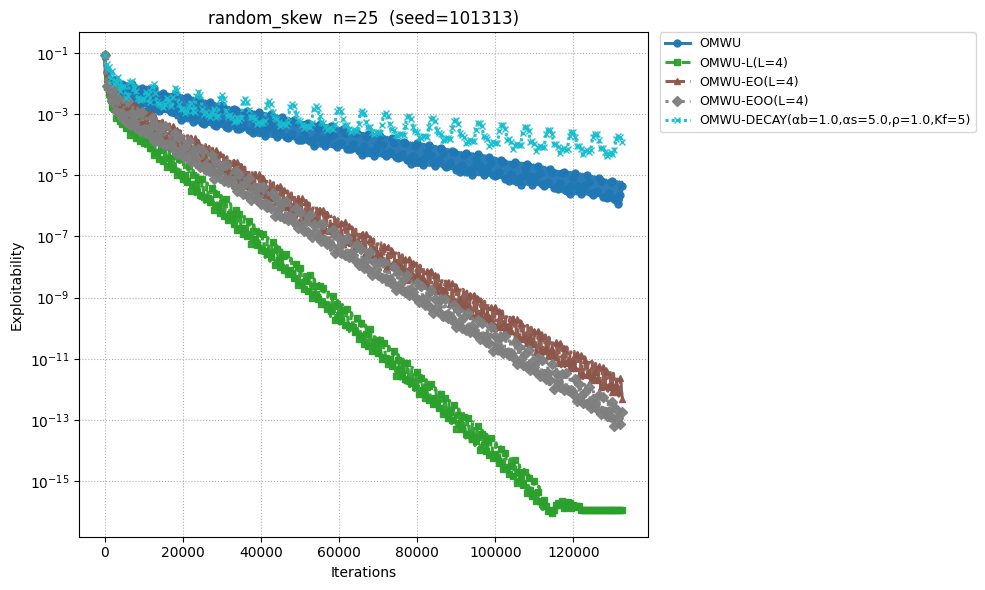

In [47]:
#!/usr/bin/env python3
"""
Single run on one random n×n zero-sum game:
  - Variants: OMWU, OMWU-L, OMWU-EO (integer L), OMWU-EOO, OMWU-DECAY
  - Independent hyperparameters per variant (eta, L, alpha_b, alpha_s, rho, Kf)
  - Progress printing + one plot at the end
  - Multiple random game generators selectable via CFG.game_type

Game types (medium→hard):
  - "random_skew"        : A = (M - M^T)/2 (purely antisymmetric)
  - "lowrank_skew"       : antisymmetric low-rank core + small noise
  - "cyclic_perturbed"   : cyclic band antisymmetric + noise
  - "block_antisym"      : 2-block directed structure, antisymmetrized
  - "illcond_skew"       : antisymmetric with ill-conditioned row/col scaling
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

# ========================= USER CONFIG (edit me) =========================

@dataclass
class Config:
    T: int = 132500               # iterations
    print_every: int = 500       # console progress
    plot_every: int = 100        # sampling for curves
    seed: int = 101313                # RNG seed for the single random game
    dtype: str = "float64"       # "float64" or "longdouble"
    n: int = 25                   # game size (n x n)
    random_scale: float = 1.0    # std-dev for random entries (base scale)
    game_type: str = "random_skew"  # choose from the list in the module docstring

CFG = Config()

# Per-variant independent hyperparameters
# NOTE: EO is back to integer L: d_t = (L+1)g_t - L g_{t-1}
VARIANT_CFG = {
    "OMWU":        {"eta": 1.0},
    "OMWU-L":      {"eta": 0.5, "L": 4},
    "OMWU-EO":     {"eta": 0.65, "L": 4},    # integer L optimism (round number)
    "OMWU-EOO":    {"eta": 0.5, "L": 4},
    "OMWU-DECAY":  {"eta": 0.10, "alpha_b": 1.0, "alpha_s": 5.0, "rho": 1.0, "Kf": 5},
}

# ========================================================================

# ============================ numerics helpers ===========================

def get_dtype(name: str):
    if name == "float64":
        return np.float64
    elif name == "longdouble":
        return np.longdouble
    raise ValueError("dtype must be 'float64' or 'longdouble'")

def softmax(b: np.ndarray) -> np.ndarray:
    z = b - np.max(b)
    e = np.exp(z)
    return e / np.sum(e)

def row_grad(A: np.ndarray, y: np.ndarray) -> np.ndarray:
    return A @ y

def col_grad(A: np.ndarray, x: np.ndarray) -> np.ndarray:
    return -(A.T @ x)

def best_response_value_row(A: np.ndarray, y: np.ndarray) -> float:
    return float(np.max(A @ y))

def best_response_value_col(A: np.ndarray, x: np.ndarray) -> float:
    return float(np.max(-(A.T @ x)))

def nashconv_and_exploit(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    ev_row = float(x @ (A @ y))
    br_row = best_response_value_row(A, y)
    br_col = best_response_value_col(A, x)
    nconv = (br_row - ev_row) + (br_col + ev_row)
    exploit = 0.5 * nconv
    return nconv, exploit

def sampling_times(T: int, plot_every: int) -> List[int]:
    return [1] + list(range(plot_every, T + 1, plot_every))

# ================================ agents =================================

class AgentBase:
    def __init__(self, n: int, eta: float, label: str, DTYPE):
        self.n = n
        self.eta = float(eta)
        self.label = label
        self.DTYPE = DTYPE
        self.b = np.zeros(n, dtype=DTYPE)
        self.x = softmax(self.b)
        self.g_prev = np.zeros(n, dtype=DTYPE)
        self.t = 0
        self._g_hist: List[np.ndarray] = []

    def next_strategy(self) -> np.ndarray:
        return self.x

    def _push_g(self, g: np.ndarray):
        self._g_hist.append(g.copy())

    def _get_g(self, idx_from_1: int) -> np.ndarray:
        if idx_from_1 <= 0 or idx_from_1 > len(self._g_hist):
            return np.zeros(self.n, dtype=self.DTYPE)
        return self._g_hist[idx_from_1 - 1]

    def observe_gradient(self, g_t: np.ndarray):
        raise NotImplementedError

# ------------------------------ OMWU --------------------------------------

class OMWU(AgentBase):
    def __init__(self, n: int, eta: float, DTYPE):
        super().__init__(n, eta, "OMWU", DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = 2.0 * g_t - self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-L ------------------------------------

class OMWU_L(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-L(L={L})", DTYPE)
        self.L = int(L)
        self._histL: List[np.ndarray] = []
        self._sumL = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = (self.DTYPE(self.L) + 1.0) * g_t - self._sumL
        d_t = base
        # update window after using it
        self._histL.insert(0, g_t.copy()); self._sumL += g_t
        if len(self._histL) > self.L:
            old = self._histL.pop(); self._sumL -= old
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EO (integer L) -----------------------

class OMWU_EO(AgentBase):
    """
    EO with *integer* breadth L:
      d_t = (L + 1) * g_t - L * g_{t-1}
    """
    def __init__(self, n: int, eta: float, L: int, DTYPE=None):
        self.L = int(L)
        super().__init__(n, eta, f"OMWU-EO(L={self.L})", DTYPE)

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        L = self.DTYPE(self.L)
        d_t = (L + 1.0) * g_t - L * self.g_prev
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ------------------------------ OMWU-EOO ----------------------------------

class OMWU_EOO(AgentBase):
    def __init__(self, n: int, eta: float, L: int, DTYPE):
        super().__init__(n, eta, f"OMWU-EOO(L={L})", DTYPE)
        self.L = int(L)
        self.pending = np.zeros(n, dtype=DTYPE)
    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        d_t = (self.DTYPE(self.L) + 1.0) * g_t - self.g_prev - self.pending
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        new_pending = max(self.L - 1, 0) * self.g_prev
        self.g_prev = g_t.copy()
        self.pending = new_pending
        self._push_g(g_t)

# ------------------------------ OMWU-DECAY --------------------------------

class OMWU_DECAY(AgentBase):
    """
    d_t = α_b g_t − (α_b−1) g_{t−1} + sum_{j=0}^{Kf−1} α_s ρ^j (g_{t−j} − g_{t−j−1})
    g_{t-k} := 0 if missing.
    """
    def __init__(self, n: int, eta: float, alpha_b: float, alpha_s: float, rho: float, Kf: int, DTYPE):
        label = f"OMWU-DECAY(αb={alpha_b},αs={alpha_s},ρ={rho},Kf={Kf})"
        super().__init__(n, eta, label, DTYPE)
        self.alpha_b = DTYPE(alpha_b)
        self.alpha_s = DTYPE(alpha_s)
        self.rho = DTYPE(rho)
        self.Kf = int(Kf)

    def _finite_diff_tail(self, g_t: np.ndarray) -> np.ndarray:
        if self.Kf <= 0:
            return np.zeros_like(g_t)
        tail = np.zeros_like(g_t)
        zeros = np.zeros_like(g_t)
        for j in range(self.Kf):
            g_tj  = g_t if j == 0 else (self._get_g(self.t - j) if (self.t - j) >= 1 else zeros)
            g_tjm1 = self._get_g(self.t - j - 1) if (self.t - j - 1) >= 1 else zeros
            tail += (self.alpha_s * (self.rho ** j)) * (g_tj - g_tjm1)
        return tail

    def observe_gradient(self, g_t: np.ndarray):
        self.t += 1
        base = self.alpha_b * g_t - (self.alpha_b - 1.0) * self.g_prev
        tail = self._finite_diff_tail(g_t)
        d_t = base + tail
        self.b += self.DTYPE(self.eta) * d_t
        self.x = softmax(self.b)
        self.g_prev = g_t.copy()
        self._push_g(g_t)

# ============================== game makers ===============================

def make_random_skew(n: int, scale: float, rng: np.random.Generator) -> np.ndarray:
    """Pure antisymmetric: A = (M - M^T)/2."""
    M = rng.normal(0.0, scale, size=(n, n))
    return 2.2*(M - M.T) / 12.0

def make_lowrank_skew(n: int, rank: int, noise_scale: float, rng: np.random.Generator) -> np.ndarray:
    """Low-rank antisymmetric core + small noise."""
    U = rng.normal(0.0, 1.0, size=(n, rank))
    V = rng.normal(0.0, 1.0, size=(n, rank))
    core = U @ V.T
    A = (core - core.T) / 12.0
    A += rng.normal(0.0, noise_scale, size=(n, n)) * 0.212  # gentle noise
    A = (A - A.T) / 1.0
    return A

def make_cyclic_perturbed(n: int, base_strength: float, noise_scale: float, rng: np.random.Generator) -> np.ndarray:
    """Cyclic band antisymmetric with random perturbations."""
    A = np.zeros((n, n))
    for i in range(n):
        A[i, (i+1) % n] = base_strength
        A[(i+1) % n, i] = -base_strength
    A += rng.normal(0.0, noise_scale, size=(n, n))
    A = (A - A.T) / 2.0
    return A

def make_block_antisym(n: int, strength: float, noise_scale: float, rng: np.random.Generator) -> np.ndarray:
    """Two-block directed structure, then antisymmetrize."""
    if n < 4:
        raise ValueError("block_antisym requires n >= 4")
    A = rng.normal(0.0, noise_scale, size=(n, n))
    mid = n // 2
    # push block 0 -> block 1 positively, reverse negative
    A[:mid, mid:] += strength
    A[mid:, :mid] -= strength
    A = (A - A.T) / 2.0
    return A

def make_illcond_skew(n: int, scale: float, cond: float, rng: np.random.Generator) -> np.ndarray:
    """Antisymmetric with ill-conditioned scaling: A' = S A S, diag(S) logspaced."""
    M = rng.normal(0.0, scale, size=(n, n))
    A = (M - M.T) / 2.0
    svals = np.logspace(0.0, np.log10(cond), num=n)  # from 1 to cond
    S = np.diag(svals)
    A = S @ A @ S
    A = (A - A.T) / 2.0
    return A

def gen_game(game_type: str, n: int, rng: np.random.Generator, base_scale: float) -> np.ndarray:
    gt = game_type.lower()
    if gt == "random_skew":
        return make_random_skew(n, base_scale, rng)
    elif gt == "lowrank_skew":
        return make_lowrank_skew(n, rank=max(2, n//3), noise_scale=base_scale, rng=rng)
    elif gt == "cyclic_perturbed":
        return make_cyclic_perturbed(n, base_strength=1.0, noise_scale=0.5 * base_scale, rng=rng)
    elif gt == "block_antisym":
        return make_block_antisym(n, strength=1.0, noise_scale=0.25 * base_scale, rng=rng)
    elif gt == "illcond_skew":
        return make_illcond_skew(n, scale=base_scale, cond=20.0, rng=rng)
    else:
        raise ValueError(f"Unknown game_type '{game_type}'. "
                         f"Choose one of: random_skew, lowrank_skew, cyclic_perturbed, block_antisym, illcond_skew")

# ============================ experiment core =============================

def run_one_game(A: np.ndarray, T: int, plot_every: int, print_every: int,
                 agents: Dict[str, Tuple[AgentBase, AgentBase]]):
    records = {lbl: {"times": [], "exploit": []} for lbl in agents}

    for t in range(1, T + 1):
        for lbl, (row, col) in agents.items():
            x = row.next_strategy()
            y = col.next_strategy()
            g_row = row_grad(A, y)
            g_col = col_grad(A, x)
            row.observe_gradient(g_row)
            col.observe_gradient(g_col)

        if t == 1 or (t % plot_every) == 0:
            for lbl, (row, col) in agents.items():
                x2 = row.next_strategy(); y2 = col.next_strategy()
                _, ex = nashconv_and_exploit(A, x2, y2)
                records[lbl]["times"].append(t)
                records[lbl]["exploit"].append(ex)

        if t == 1 or (t % print_every) == 0:
            msg = [f"t={t:6d}"]
            for lbl in agents:
                ex = records[lbl]["exploit"][-1] if records[lbl]["exploit"] else float('nan')
                msg.append(f"{lbl}: ex={ex:.3e}")
            print("[progress]", "  ".join(msg))

    # Length alignment (safety)
    t_ref = None
    for lbl in records:
        if t_ref is None:
            t_ref = len(records[lbl]["times"])
        else:
            m = min(t_ref, len(records[lbl]["times"]), len(records[lbl]["exploit"]))
            records[lbl]["times"] = records[lbl]["times"][:m]
            records[lbl]["exploit"] = records[lbl]["exploit"][:m]

    return records

# =============================== plotting =================================

def make_style_map(labels: List[str]):
    import matplotlib.cm as cm
    cmap = cm.get_cmap('tab10', len(labels))
    linestyles = ['-', '--', '-.', ':', (0, (1, 1))]
    markers = ['o', 's', '^', 'D', 'x']
    style_map = {}
    for i, lbl in enumerate(labels):
        style_map[lbl] = dict(color=cmap(i), linestyle=linestyles[i % len(linestyles)],
                              linewidth=2.2, alpha=0.95, marker=markers[i % len(markers)],
                              markevery=5, markersize=5)
    return style_map

def plot_single(records, title: str):
    labels = list(records.keys())
    style_map = make_style_map(labels)

    plt.figure(figsize=(10, 6))
    for lbl in labels:
        xs = np.array(records[lbl]["times"], dtype=float)
        ys = np.array(records[lbl]["exploit"], dtype=float)
        plt.plot(xs, ys, label=lbl, **style_map[lbl])
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Exploitability")
    plt.title(title)
    plt.grid(True, which="both", ls=":")
    plt.legend(fontsize=9, ncol=1, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

# ================================= main ===================================

def make_agents(n: int, DTYPE, cfg: Dict[str, Dict]) -> Dict[str, Tuple[AgentBase, AgentBase]]:
    agents: Dict[str, Tuple[AgentBase, AgentBase]] = {}

    # OMWU
    p = cfg["OMWU"]
    agents["OMWU"] = (OMWU(n, p["eta"], DTYPE), OMWU(n, p["eta"], DTYPE))

    # OMWU-L
    p = cfg["OMWU-L"]
    agents[f"OMWU-L(L={p['L']})"] = (OMWU_L(n, p["eta"], p["L"], DTYPE), OMWU_L(n, p["eta"], p["L"], DTYPE))

    # OMWU-EO (integer L)
    p = cfg["OMWU-EO"]
    agents[f"OMWU-EO(L={p['L']})"] = (OMWU_EO(n, p["eta"], p["L"], DTYPE), OMWU_EO(n, p["eta"], p["L"], DTYPE))

    # OMWU-EOO
    p = cfg["OMWU-EOO"]
    agents[f"OMWU-EOO(L={p['L']})"] = (OMWU_EOO(n, p["eta"], p["L"], DTYPE), OMWU_EOO(n, p["eta"], p["L"], DTYPE))

    # OMWU-DECAY
    p = cfg["OMWU-DECAY"]
    lab = f"OMWU-DECAY(αb={p['alpha_b']},αs={p['alpha_s']},ρ={p['rho']},Kf={p['Kf']})"
    agents[lab] = (
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
        OMWU_DECAY(n, p["eta"], p["alpha_b"], p["alpha_s"], p["rho"], p["Kf"], DTYPE),
    )
    return agents

def main():
    print("Config:", asdict(CFG))
    print("Variant hyperparameters:", VARIANT_CFG)
    DTYPE = get_dtype(CFG.dtype)
    rng = np.random.default_rng(CFG.seed)

    # Build one random game of the chosen type (row payoff A, col payoff -A)
    A = gen_game(CFG.game_type, CFG.n, rng, CFG.random_scale)
    print(f"[info] Single {CFG.game_type} game  |  seed={CFG.seed}  |  shape={A.shape}")

    # Build agents (per-variant hyperparameters)
    agents = make_agents(CFG.n, DTYPE, VARIANT_CFG)

    # Run
    records = run_one_game(A, CFG.T, CFG.plot_every, CFG.print_every, agents)

    # Plot
    plot_single(records, title=f"{CFG.game_type}  n={CFG.n}  (seed={CFG.seed})")

if __name__ == "__main__":
    main()


In [48]:
###############################################
###############################################

In [17]:
###############################


=== Random EFG built ===
  players           : 2
  P0 infosets       : 7
  P1 infosets       : 3
  P0 sequences      : 19 (root=18)
  P1 sequences      : 8 (root=7)
  payoff nnz        : 54
  notes             : Random EFG (two-player zero-sum).

[KOMWU] t=     1  exploit=3.018273e-01  eta=4.00e-01
[KOMWU] t=   500  exploit=1.211383e-03  eta=4.00e-01
[KOMWU] t=  1000  exploit=1.200220e-04  eta=4.00e-01
[KOMWU] t=  1500  exploit=1.402650e-05  eta=4.00e-01
[KOMWU] t=  2000  exploit=1.679188e-06  eta=4.00e-01
[KOMWU] t=  2500  exploit=2.032425e-07  eta=4.00e-01
[KOMWU] t=  3000  exploit=2.473203e-08  eta=4.00e-01
[KOMWU] t=  3500  exploit=3.017034e-09  eta=4.00e-01
[KOMWU] t=  4000  exploit=3.684555e-10  eta=4.00e-01
[KOMWU] t=  4500  exploit=4.502007e-11  eta=4.00e-01
[KOMWU] t=  5000  exploit=5.502043e-12  eta=4.00e-01
[KOMWU] t=  5500  exploit=6.724898e-13  eta=4.00e-01
[KOMWU] t=  6000  exploit=8.221201e-14  eta=4.00e-01
[KOMWU] t=  6500  exploit=1.004752e-14  eta=4.00e-01
[KOMWU] t= 

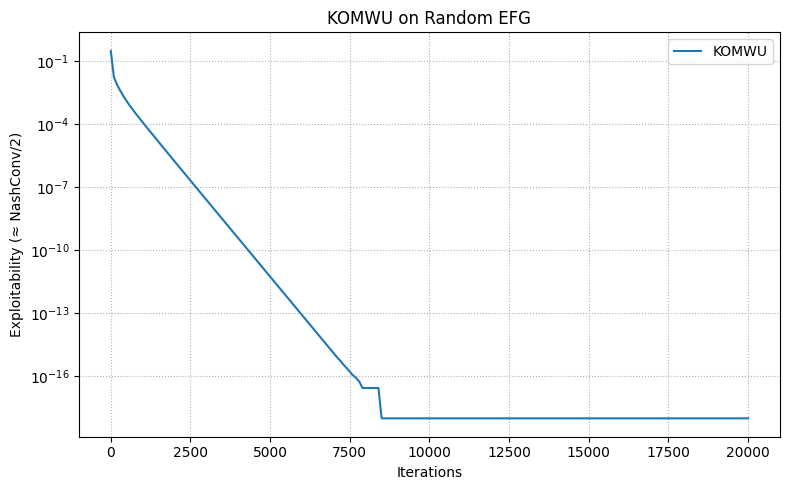

In [19]:
#@title KOMWU on Treeplex + Random EFG (library code)
# Colab-safe, single-file implementation.
from __future__ import annotations
import math, sys
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt

# =============== numerics helpers ===============
def get_dtype(precision: str):
    if precision not in {"normal","precise"}:
        raise ValueError("precision must be 'normal' or 'precise'")
    return np.float64 if precision == "normal" else np.longdouble

def logsumexp_np(v: np.ndarray) -> np.floating:
    # Stable log-sum-exp
    m = np.max(v)
    return m + np.log(np.sum(np.exp(v - m)))

# =============== Treeplex data structure ===============
class Treeplex:
    class Infoset:
        __slots__ = ("start_sequence_id","end_sequence_id","parent_sequence_id","infoset_id")
        def __init__(self, start_seq: int, end_seq: int, parent_seq: int, infoset_id: int):
            self.start_sequence_id  = int(start_seq)
            self.end_sequence_id    = int(end_seq)
            self.parent_sequence_id = int(parent_seq)
            self.infoset_id         = int(infoset_id)

    def __init__(self, infosets: List["Treeplex.Infoset"], n_sequences_hint: Optional[int]=None):
        self.infosets: List[Treeplex.Infoset] = infosets
        self.n_infosets = len(infosets)

        if self.n_infosets == 0:
            self.root_sequence_id = 0
            self.n_sequences = 1
            self.children = [[]]
            return

        self.root_sequence_id = max(ifs.parent_sequence_id for ifs in infosets)
        if n_sequences_hint is None:
            max_action_seq = max(ifs.end_sequence_id for ifs in infosets)
            self.n_sequences = max(self.root_sequence_id, max_action_seq) + 1
        else:
            self.n_sequences = int(n_sequences_hint)

        # For each parent sequence, which infosets sprout from it?
        self.children: List[List[Treeplex.Infoset]] = [[] for _ in range(self.n_sequences)]
        for ifs in infosets:
            self.children[ifs.parent_sequence_id].append(ifs)

    def is_sf_strategy(self, x: np.ndarray) -> bool:
        # Sequence-form feasibility: x >= 0; x[root]=1; flow conservation at each infoset
        if not np.all(x >= 0): return False
        if abs(float(x[self.root_sequence_id]) - 1.0) > 1e-9: return False
        for ifs in self.infosets:
            s = -float(x[ifs.parent_sequence_id])
            for seq in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                s += float(x[seq])
            if abs(s) > 1e-9:
                return False
        return True

    def best_response_value(self, gradient: np.ndarray) -> float:
        # DP: add max child value to the parent sequence's gradient
        g = np.asarray(gradient, dtype=gradient.dtype).copy()
        for ifs in self.infosets:  # infosets must be in bottom-up order
            sl = g[ifs.start_sequence_id:ifs.end_sequence_id+1]
            g[ifs.parent_sequence_id] += np.max(sl)
        return float(g[self.root_sequence_id])

# =============== KOMWU core (OMWU direction on treeplex) ===============
class Komwu:
    """
    KOMWU on a Treeplex (sequence-form) with the entropic treeplex map.
    Update direction (OMWU): d_t = 2 g_t - g_{t-1}
    Strategy map: treeplex log-partition recursion in log-space.
    """
    def __init__(self, tpx: Treeplex, eta: float = 0.3, dtype=None):
        self.tpx  = tpx
        self.eta  = float(eta)
        self.dtype = np.float64 if dtype is None else dtype

        self.last_gradient = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.b             = np.zeros(self.tpx.n_sequences, dtype=self.dtype)  # "logits" on sequences

        self._prepare_topo_orders()
        self._compute_x()

        # regret diagnostics (optional)
        self.sum_gradients = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.sum_ev        = self.dtype(0.0)

    def next_strategy(self) -> np.ndarray:
        return self.x

    def regret(self) -> float:
        return self.tpx.best_response_value(self.sum_gradients) - float(self.sum_ev)

    def observe_gradient(self, gradient: np.ndarray):
        g_t = np.asarray(gradient, dtype=self.dtype)
        self.sum_gradients += g_t
        self.sum_ev += float(np.dot(g_t, self.next_strategy()))

        d_t = self.dtype(2.0) * g_t - self.last_gradient
        self.b += self.dtype(self.eta) * d_t
        self._compute_x()
        self.last_gradient = g_t

    # ----- topology for bottom-up (K) and top-down (y) passes -----
    def _prepare_topo_orders(self):
        # Map each sequence to its owning infoset (if any)
        seq_owner = {}
        for ifs in self.tpx.infosets:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                seq_owner[s] = ifs.infoset_id

        # Build adjacency between infosets via parent sequence ownership
        adj = [[] for _ in range(self.tpx.n_infosets)]
        roots = []
        for ifs in self.tpx.infosets:
            ps = ifs.parent_sequence_id
            if ps in seq_owner:
                adj[seq_owner[ps]].append(ifs.infoset_id)
            else:
                roots.append(ifs.infoset_id)

        # post-order DFS (children -> parent)
        seen = [False]*self.tpx.n_infosets
        post = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]:
                dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in range(self.tpx.n_infosets):
            if not seen[i]: dfs(i)

        id2if = {ifs.infoset_id: ifs for ifs in self.tpx.infosets}
        self._post_infosets = [id2if[i] for i in post]   # bottom-up order

    def _compute_x(self):
        # Bottom-up: compute K_j(b) = log sum_a exp( b_{ja} + sum_child K )
        K_j = [None] * self.tpx.n_infosets
        for ifs in self._post_infosets:  # children -> parent
            terms = []
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                terms.append(self.b[s] + child_sum)
            K_j[ifs.infoset_id] = logsumexp_np(np.asarray(terms, dtype=self.dtype))

        # Top-down: y propagation; y_root = 0; x = exp(y)
        y = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        for ifs in reversed(self._post_infosets):  # parent -> children
            Kj = K_j[ifs.infoset_id]
            y_parent = y[ifs.parent_sequence_id]
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                y[s] = y_parent + self.b[s] + child_sum - Kj

        self.x = np.exp(y)
        # Safety: exact feasibility should hold; tolerate tiny drift
        if not self.tpx.is_sf_strategy(self.x):
            # Normalize locally per infoset to project tiny drift
            for ifs in self.tpx.infosets:
                parent = ifs.parent_sequence_id
                sl = slice(ifs.start_sequence_id, ifs.end_sequence_id + 1)
                ssum = float(np.sum(self.x[sl]))
                if ssum > 0:
                    self.x[sl] *= float(self.x[parent]) / ssum
            self.x[self.tpx.root_sequence_id] = 1.0

# =============== EFG primitives ===============
@dataclass
class PayoffEntry:
    payoffs: List[float]     # [u0, u1]
    chanceFactor: float      # product of chance probabilities on path
    sequences: List[int]     # [seq0, seq1] (last sequence indices; root allowed)

class Game:
    def __init__(self, tpxs: List[Treeplex], entries: List[PayoffEntry]):
        self.tpxs = tpxs
        self.payoff_matrix_entries = entries
        self.n_players = len(tpxs)
        self.payoff_matrix_nnz = len(entries)
        self.notes = "Random EFG (two-player zero-sum)."

    def utility_gradient(self, player: int, strategies: Dict[int, np.ndarray]) -> np.ndarray:
        grad = np.zeros(self.tpxs[player].n_sequences, dtype=strategies[player].dtype)
        # Underflow on off-reach products is fine; do not abort
        with np.errstate(under='ignore'):
            for e in self.payoff_matrix_entries:
                reach = e.chanceFactor
                for p in range(self.n_players):
                    if p != player:
                        reach *= strategies[p][e.sequences[p]]
                grad[e.sequences[player]] += e.payoffs[player] * reach
        return grad

# =============== Random EFG Builder (chance + infosets) ===============
class RandomEFGBuilder:
    """
    Two-player zero-sum random EFG with chance nodes and information sets.
    We assign one infoset per decision node (perfect information by default).
    """
    def __init__(self,
                 depth: int = 4,
                 branch_min: int = 2,
                 branch_max: int = 3,
                 chance_every: int = 2,
                 chance_branches: int = 2,
                 stop_prob: float = 0.0,
                 seed: int = 0,
                 dtype=np.float64):
        self.depth = int(depth)
        self.branch_min = int(branch_min)
        self.branch_max = int(branch_max)
        self.chance_every = int(chance_every)
        self.chance_branches = int(chance_branches)
        self.stop_prob = float(stop_prob)
        self.rng = np.random.default_rng(seed)
        self.dtype = dtype

        self.next_seq = [0, 0]
        self.infosets: List[List[Tuple[int,int,int]]] = [[], []]  # per player: (start,end,parent)
        self.entries: List[PayoffEntry] = []

    def _rand_actions(self) -> int:
        return int(self.rng.integers(self.branch_min, self.branch_max + 1))

    def _rand_payoff(self) -> float:
        return float(self.rng.uniform(-1.0, 1.0))  # zero-sum in [-1,1]

    def _should_stop(self, depth: int) -> bool:
        if depth >= self.depth: return True
        if self.stop_prob > 0.0 and self.rng.random() < self.stop_prob: return True
        return False

    def _node_type(self, depth: int) -> str:
        # Insert chance layers regularly; otherwise alternate players
        if self.chance_every > 0 and (depth % (self.chance_every + 1) == 0):
            return "chance"
        return "p0" if (depth % 2 == 0) else "p1"

    def _chance_outcomes(self) -> Tuple[np.ndarray, int]:
        k = max(2, self.chance_branches)
        probs = self.rng.random(k)
        probs /= probs.sum()
        return probs.astype(self.dtype), k

    def _new_infoset(self, p: int, parent_seq: int, n_actions: int) -> Tuple[int,int,int]:
        start = self.next_seq[p]
        end   = start + n_actions - 1
        self.next_seq[p] += n_actions
        self.infosets[p].append((start, end, parent_seq))
        return (start, end, parent_seq)

    def _build(self, depth: int, last_seq0: int, last_seq1: int, chance_weight: float):
        if self._should_stop(depth):
            u = self._rand_payoff()
            self.entries.append(PayoffEntry(
                payoffs=[u, -u],
                chanceFactor=chance_weight,
                sequences=[last_seq0, last_seq1]
            ))
            return

        kind = self._node_type(depth)
        if kind == "chance":
            probs, k = self._chance_outcomes()
            for j in range(k):
                self._build(depth+1, last_seq0, last_seq1, chance_weight * float(probs[j]))
            return

        p = 0 if kind == "p0" else 1
        nA = self._rand_actions()
        start, end, _ = self._new_infoset(p, parent_seq=(last_seq0 if p==0 else last_seq1), n_actions=nA)
        for s in range(start, end+1):
            if p == 0:
                self._build(depth+1, s, last_seq1, chance_weight)
            else:
                self._build(depth+1, last_seq0, s, chance_weight)

    def _finalize_treeplex(self, p: int) -> Treeplex:
        max_seq = max([end for (start,end,parent) in self.infosets[p]], default=-1)
        root_seq_id = max_seq + 1

        fixed = []
        for (start,end,parent) in self.infosets[p]:
            parent_fixed = root_seq_id if (parent == -1) else parent
            fixed.append((start,end,parent_fixed))

        provisionals = [Treeplex.Infoset(s,e,parent,idx) for idx,(s,e,parent) in enumerate(fixed)]

        # Build seq_owner to detect parent infosets
        seq_owner: Dict[int,int] = {}
        for ifs in provisionals:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                seq_owner[s] = ifs.infoset_id

        # adjacency over infosets
        adj: Dict[int,List[int]] = {ifs.infoset_id: [] for ifs in provisionals}
        roots: List[int] = []
        for ifs in provisionals:
            ps = ifs.parent_sequence_id
            if ps in seq_owner:
                adj[seq_owner[ps]].append(ifs.infoset_id)
            else:
                roots.append(ifs.infoset_id)

        # post-order
        seen = {i: False for i in adj.keys()}
        post: List[int] = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]:
                dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in list(adj.keys()):
            if not seen[i]: dfs(i)

        id_map = {old_id: new_id for new_id, old_id in enumerate(post)}
        infosets_sorted = []
        for old_id in post:
            ifs = provisionals[old_id]
            infosets_sorted.append(
                Treeplex.Infoset(ifs.start_sequence_id, ifs.end_sequence_id, ifs.parent_sequence_id, id_map[old_id])
            )
        # Build final treeplex
        return Treeplex(infosets_sorted, n_sequences_hint=root_seq_id+1)

    def build(self) -> Game:
        # Start recursion at depth 0 with "no last action" → parent placeholder -1
        self._build(depth=0, last_seq0=-1, last_seq1=-1, chance_weight=1.0)

        tpx0 = self._finalize_treeplex(0)
        tpx1 = self._finalize_treeplex(1)

        # Fix any -1 terminal references to actual root ids
        r0, r1 = tpx0.root_sequence_id, tpx1.root_sequence_id
        for e in self.entries:
            if e.sequences[0] == -1: e.sequences[0] = r0
            if e.sequences[1] == -1: e.sequences[1] = r1

        return Game([tpx0, tpx1], self.entries)

# =============== metrics & runner helpers ===============
def nash_conv_and_ev(game: Game, x: Dict[int,np.ndarray]) -> Tuple[float,float,float]:
    g0 = game.utility_gradient(0, x)
    g1 = game.utility_gradient(1, x)
    ev0 = float(np.dot(g0, x[0]))
    ev1 = float(np.dot(g1, x[1]))
    br0 = float(game.tpxs[0].best_response_value(g0))
    br1 = float(game.tpxs[1].best_response_value(g1))
    nconv = (br0 - ev0) + (br1 - ev1)
    return nconv, 0.5 * max(nconv, 0.0), ev0  # exploitability = NashConv/2, clamp at 0

def run_komwu_random_efg(
    depth=5, branch_min=2, branch_max=3,
    chance_every=2, chance_branches=3, stop_prob=0.0,
    eta=0.4, T=20000, precision="precise",
    seed=0, print_every=500, plot_every=100
):
    DTYPE = get_dtype(precision)
    # Strict on overflow / invalid; ignore harmless underflow (off-reach paths)
    np.seterr(over='raise', divide='raise', invalid='raise', under='ignore')

    builder = RandomEFGBuilder(
        depth=depth, branch_min=branch_min, branch_max=branch_max,
        chance_every=chance_every, chance_branches=chance_branches,
        stop_prob=stop_prob, seed=seed, dtype=DTYPE
    )
    game = builder.build()

    print(f"=== Random EFG built ===")
    print(f"  players           : {game.n_players}")
    print(f"  P0 infosets       : {game.tpxs[0].n_infosets}")
    print(f"  P1 infosets       : {game.tpxs[1].n_infosets}")
    print(f"  P0 sequences      : {game.tpxs[0].n_sequences} (root={game.tpxs[0].root_sequence_id})")
    print(f"  P1 sequences      : {game.tpxs[1].n_sequences} (root={game.tpxs[1].root_sequence_id})")
    print(f"  payoff nnz        : {game.payoff_matrix_nnz}")
    print(f"  notes             : {game.notes}")
    print(f"========================\n")

    row = Komwu(game.tpxs[0], eta=float(eta), dtype=DTYPE)
    col = Komwu(game.tpxs[1], eta=float(eta), dtype=DTYPE)

    times, exploits = [], []
    for t in range(1, T + 1):
        strategies = {0: row.next_strategy(), 1: col.next_strategy()}
        g0 = game.utility_gradient(0, strategies)
        g1 = game.utility_gradient(1, strategies)

        row.observe_gradient(g0)
        col.observe_gradient(g1)

        if (t % plot_every) == 0 or t == 1:
            strategies = {0: row.next_strategy(), 1: col.next_strategy()}
            nc, ex, _ = nash_conv_and_ev(game, strategies)
            times.append(t); exploits.append(ex)

        if (t % print_every) == 0 or t == 1:
            ex = exploits[-1] if exploits else float('nan')
            print(f"[KOMWU] t={t:6d}  exploit={ex:.6e}  eta={eta:.2e}")

    # Plot
    if times:
        y = np.maximum(np.asarray(exploits, dtype=float), 1e-18)
        plt.figure(figsize=(8,5))
        plt.plot(np.asarray(times, dtype=float), y, label="KOMWU")
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (≈ NashConv/2)")
        plt.title("KOMWU on Random EFG")
        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"times": np.asarray(times), "exploit": np.asarray(exploits)}


#@title Run KOMWU on a random EFG (tweak params)
depth = 4             #@param {type:"integer"}
branch_min = 2        #@param {type:"integer"}
branch_max = 3        #@param {type:"integer"}
chance_every = 2      #@param {type:"integer"}
chance_branches = 3   #@param {type:"integer"}
stop_prob = 0.0       #@param {type:"number"}

eta = 0.4             #@param {type:"number"}
T = 20000             #@param {type:"integer"}
precision = "precise" #@param ["normal","precise"]
seed = 0              #@param {type:"integer"}
print_every = 500     #@param {type:"integer"}
plot_every = 100      #@param {type:"integer"}

out = run_komwu_random_efg(
    depth=depth, branch_min=branch_min, branch_max=branch_max,
    chance_every=chance_every, chance_branches=chance_branches, stop_prob=stop_prob,
    eta=eta, T=T, precision=precision, seed=seed,
    print_every=print_every, plot_every=plot_every
)


=== Random EFG built ===
  players           : 2
  P0 infosets       : 4
  P1 infosets       : 4
  P0 sequences      : 15 (root=14)
  P1 sequences      : 14 (root=13)
  payoff nnz        : 990
  notes             : Random EFG (two-player zero-sum).

[OMWU|OMWU] t=     1  exploit=9.536633e-02  nashconv=1.907327e-01
[OMWU|OMWU] t=   500  exploit=2.035693e-02  nashconv=4.071387e-02
[OMWU|OMWU] t=  1000  exploit=1.528121e-02  nashconv=3.056241e-02
[OMWU|OMWU] t=  1500  exploit=3.426224e-02  nashconv=6.852447e-02
[OMWU|OMWU] t=  2000  exploit=1.700199e-02  nashconv=3.400397e-02
[OMWU|OMWU] t=  2500  exploit=1.137468e-02  nashconv=2.274936e-02
[OMWU|OMWU] t=  3000  exploit=2.645882e-02  nashconv=5.291764e-02
[OMWU|OMWU] t=  3500  exploit=2.297992e-02  nashconv=4.595984e-02
[OMWU|OMWU] t=  4000  exploit=3.629554e-03  nashconv=7.259108e-03
[OMWU|OMWU] t=  4500  exploit=2.674581e-02  nashconv=5.349162e-02
[OMWU|OMWU] t=  5000  exploit=2.060734e-02  nashconv=4.121468e-02
[OMWU|OMWU] t=  5500  ex

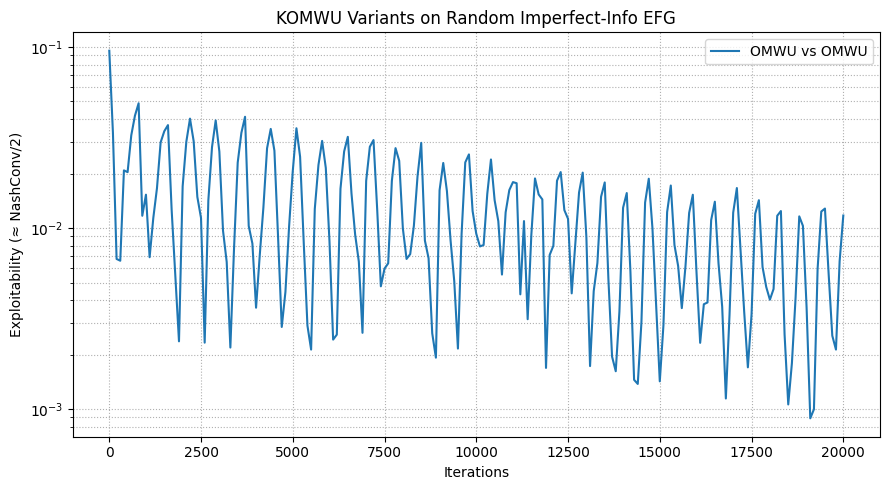

In [24]:
#@title KOMWU (Treeplex) + Variants on Random Imperfect-Info EFGs — Single-File Colab
#@markdown - Generates random EFGs with **chance** and **imperfect information** (nodes merged into infosets).
#@markdown - Implements **KOMWU** + **EO / EOO / L / DECAY** variants.
#@markdown - Tweak **ALL** hyperparameters below (infoset mode, variant, η, L, α, α_b/α_s, ρ, Kf, etc.).
from __future__ import annotations

import sys, math
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt

# =============== numerics ===============
def get_dtype(precision: str):
    if precision not in {"normal","precise"}:
        raise ValueError("precision must be 'normal' or 'precise'")
    return np.float64 if precision == "normal" else np.longdouble

def logsumexp_np(v: np.ndarray) -> np.floating:
    m = np.max(v)
    return m + np.log(np.sum(np.exp(v - m)))

# =============== Treeplex structure ===============
class Treeplex:
    class Infoset:
        __slots__ = ("start_sequence_id","end_sequence_id","parent_sequence_id","infoset_id")
        def __init__(self, start_seq: int, end_seq: int, parent_seq: int, infoset_id: int):
            self.start_sequence_id  = int(start_seq)
            self.end_sequence_id    = int(end_seq)
            self.parent_sequence_id = int(parent_seq)
            self.infoset_id         = int(infoset_id)

    def __init__(self, infosets: List["Treeplex.Infoset"], n_sequences_hint: Optional[int]=None):
        self.infosets: List[Treeplex.Infoset] = infosets
        self.n_infosets = len(infosets)
        if self.n_infosets == 0:
            self.root_sequence_id = 0
            self.n_sequences = 1
            self.children = [[]]
            return

        self.root_sequence_id = max(ifs.parent_sequence_id for ifs in infosets)
        if n_sequences_hint is None:
            max_action_seq = max(ifs.end_sequence_id for ifs in infosets)
            self.n_sequences = max(self.root_sequence_id, max_action_seq) + 1
        else:
            self.n_sequences = int(n_sequences_hint)

        # For each parent sequence, which infosets sprout from it?
        self.children: List[List[Treeplex.Infoset]] = [[] for _ in range(self.n_sequences)]
        for ifs in infosets:
            self.children[ifs.parent_sequence_id].append(ifs)

    def is_sf_strategy(self, x: np.ndarray) -> bool:
        if not np.all(x >= 0): return False
        if abs(float(x[self.root_sequence_id]) - 1.0) > 1e-9: return False
        for ifs in self.infosets:
            s = -float(x[ifs.parent_sequence_id])
            for seq in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                s += float(x[seq])
            if abs(s) > 1e-9:
                return False
        return True

    def best_response_value(self, gradient: np.ndarray) -> float:
        g = np.asarray(gradient, dtype=gradient.dtype).copy()
        # infosets are bottom-up (children -> parent)
        for ifs in self.infosets:
            sl = g[ifs.start_sequence_id:ifs.end_sequence_id+1]
            g[ifs.parent_sequence_id] += np.max(sl)
        return float(g[self.root_sequence_id])

# =============== KOMWU base + variants ===============
class KomwuBase:
    """
    Base class for treeplex KOMWU-like solvers.
    Subclasses implement _direction(g_t) → d_t.
    """
    def __init__(self, tpx: Treeplex, eta: float = 0.3, dtype=None):
        self.tpx = tpx
        self.eta = float(eta)
        self.dtype = np.float64 if dtype is None else dtype
        self.b = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.last_gradient = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self._hist: List[np.ndarray] = []  # g_{t-1}, g_{t-2}, ... (most recent first)
        self._prepare_topo_order()
        self._compute_x()
        self.sum_gradients = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.sum_ev = self.dtype(0.0)

    def next_strategy(self) -> np.ndarray:
        return self.x

    def regret(self) -> float:
        return self.tpx.best_response_value(self.sum_gradients) - float(self.sum_ev)

    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def observe_gradient(self, gradient: np.ndarray):
        g_t = np.asarray(gradient, dtype=self.dtype)
        self.sum_gradients += g_t
        self.sum_ev += float(np.dot(g_t, self.next_strategy()))

        d_t = self._direction(g_t)
        self.b += self.dtype(self.eta) * d_t
        self._compute_x()

        self._hist.insert(0, g_t.copy())
        if len(self._hist) > 128:  # cap history
            self._hist.pop()
        self.last_gradient = g_t

    def _get_hist(self, k: int, default: Optional[np.ndarray]=None) -> np.ndarray:
        if k < len(self._hist): return self._hist[k]
        if default is None:
            return np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        return default

    def _prepare_topo_order(self):
        # Build bottom-up order over infosets for treeplex softmax
        seq_owner = {}
        for ifs in self.tpx.infosets:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                seq_owner[s] = ifs.infoset_id

        adj = [[] for _ in range(self.tpx.n_infosets)]
        roots = []
        for ifs in self.tpx.infosets:
            ps = ifs.parent_sequence_id
            if ps in seq_owner:
                adj[seq_owner[ps]].append(ifs.infoset_id)
            else:
                roots.append(ifs.infoset_id)

        seen = [False]*self.tpx.n_infosets
        post = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]:
                dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in range(self.tpx.n_infosets):
            if not seen[i]: dfs(i)

        id2if = {ifs.infoset_id: ifs for ifs in self.tpx.infosets}
        self._post_infosets = [id2if[i] for i in post]

    def _compute_x(self):
        # Bottom-up: K_j(b)
        K_j = [None] * self.tpx.n_infosets
        for ifs in self._post_infosets:
            terms = []
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                terms.append(self.b[s] + child_sum)
            K_j[ifs.infoset_id] = logsumexp_np(np.asarray(terms, dtype=self.dtype))
        # Top-down: y, then x = exp(y)
        y = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        for ifs in reversed(self._post_infosets):
            Kj = K_j[ifs.infoset_id]
            y_parent = y[ifs.parent_sequence_id]
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                y[s] = y_parent + self.b[s] + child_sum - Kj
        self.x = np.exp(y)

        # safety projection if tiny drift shows up
        if not self.tpx.is_sf_strategy(self.x):
            for ifs in self.tpx.infosets:
                parent = ifs.parent_sequence_id
                sl = slice(ifs.start_sequence_id, ifs.end_sequence_id + 1)
                ssum = float(np.sum(self.x[sl]))
                if ssum > 0:
                    self.x[sl] *= float(self.x[parent]) / ssum
            self.x[self.tpx.root_sequence_id] = 1.0

# ---- Variants ----
class KomwuOMWU(KomwuBase):
    # d_t = 2 g_t - g_{t-1}
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self._get_hist(0)
        return self.dtype(2.0) * g_t - g_tm1

class KomwuEO(KomwuBase):
    """
    Extra Optimism.
    Two equivalent parameterizations:
      - alpha (float ≥ 1): d_t = alpha * g_t - (alpha-1) * g_{t-1}
      - L (int ≥ 1):       d_t = (L+1) * g_t - L * g_{t-1}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, alpha: Optional[float]=None, L: Optional[int]=None, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.alpha = alpha
        self.L = L
        if self.alpha is None and self.L is None:
            self.alpha = 2.0
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self._get_hist(0)
        if self.L is not None:
            return self.dtype(self.L+1) * g_t - self.dtype(self.L) * g_tm1
        alpha = self.dtype(self.alpha if self.alpha is not None else 2.0)
        return alpha * g_t - (alpha - self.dtype(1.0)) * g_tm1

class KomwuEOO(KomwuBase):
    """
    Staggered extra optimism:
      d_t = (L+1) g_t − g_{t−1} − pending_t
      pending_{t+1} = max(L−1, 0) * g_{t−1}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: int=2, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = int(max(1, L))
        self._pending = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self._get_hist(0)
        d = self.dtype(self.L+1) * g_t - g_tm1 - self._pending
        self._pending = self.dtype(max(self.L-1, 0)) * g_tm1
        return d

class KomwuL(KomwuBase):
    """
    Windowed form:
      d_t = (L+1) g_t − ∑_{i=1}^L g_{t−i}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: int=2, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = int(max(1, L))
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        acc = np.zeros_like(g_t)
        for i in range(1, self.L+1):
            acc += self._get_hist(i-1)  # g_{t-i}
        return self.dtype(self.L+1) * g_t - acc

class KomwuDECAY(KomwuBase):
    """
    DECAY (finite-tap increments):
      d_t = alpha_b * g_t + alpha_s * sum_{j=0..Kf-1} w_j * (g_{t-j} - g_{t-j-1})
    where weights w_j are either:
      - 'geom' with rho in [0,1):   w_j ∝ (1-rho) rho^j  (normalized if normalize=True)
      - 'uniform':                  w_j = 1/Kf
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3,
                 alpha_b: float=1.0, alpha_s: float=2.0, rho: float=1.0, Kf: int=2,
                 scheme: str="uniform", normalize: bool=True, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.alpha_b = self.dtype(alpha_b)
        self.alpha_s = self.dtype(alpha_s)
        self.rho = float(rho)
        self.Kf = int(max(0, Kf))
        self.scheme = scheme
        self.normalize = normalize
        self._build_weights()

    def _build_weights(self):
        if self.Kf <= 0:
            self._w = np.zeros(0, dtype=self.dtype); return
        if self.scheme == "geom" and 0.0 <= self.rho < 1.0:
            w = np.array([(1.0 - self.rho) * (self.rho ** j) for j in range(self.Kf)], dtype=float)
            if self.normalize:
                s = w.sum()
                if s > 0: w = w / s
        else:
            w = np.ones(self.Kf, dtype=float) / float(self.Kf)
        self._w = np.asarray(w, dtype=self.dtype)

    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.alpha_b * g_t
        if self.Kf > 0 and len(self._w) == self.Kf:
            zeros = np.zeros_like(g_t)
            inc = np.zeros_like(g_t)
            for j in range(self.Kf):
                g_t_minus_j   = g_t if j == 0 else self._get_hist(j-1, zeros)
                g_t_minus_jm1 = self._get_hist(j, zeros)
                inc += self._w[j] * (g_t_minus_j - g_t_minus_jm1)
            d = d + self.alpha_s * inc
        return d

# =============== EFG primitives ===============
@dataclass
class PayoffEntry:
    payoffs: List[float]     # [u0, u1]
    chanceFactor: float
    sequences: List[int]     # [seq0, seq1]

class Game:
    def __init__(self, tpxs: List[Treeplex], entries: List[PayoffEntry]):
        self.tpxs = tpxs
        self.payoff_matrix_entries = entries
        self.n_players = len(tpxs)
        self.payoff_matrix_nnz = len(entries)
        self.notes = "Random EFG (two-player zero-sum)."

    def utility_gradient(self, player: int, strategies: Dict[int, np.ndarray]) -> np.ndarray:
        grad = np.zeros(self.tpxs[player].n_sequences, dtype=strategies[player].dtype)
        with np.errstate(under='ignore'):  # harmless off-reach underflow
            for e in self.payoff_matrix_entries:
                reach = e.chanceFactor
                for p in range(self.n_players):
                    if p != player:
                        reach *= strategies[p][e.sequences[p]]
                grad[e.sequences[player]] += e.payoffs[player] * reach
        return grad

# =============== Random EFG builder with imperfect info ===============
class RandomEFGBuilder:
    """
    Two-player zero-sum random EFG with chance + information sets.
    Imperfect information is introduced by *sharing* an infoset across
    multiple decision nodes that have the same player's *parent sequence*.

    infosets_mode:
      - "perfect"   → new infoset at every node (no sharing).
      - "imperfect" → always share by (player, parent_seq).
      - "mixed"     → share with probability merge_prob (per visit).
    """
    def __init__(self,
                 depth: int = 4,
                 branch_min: int = 2,
                 branch_max: int = 3,
                 chance_every: int = 2,
                 chance_branches: int = 2,
                 stop_prob: float = 0.0,
                 infosets_mode: str = "imperfect",
                 merge_prob: float = 0.5,
                 seed: int = 0,
                 dtype=np.float64):
        self.depth = int(depth)
        self.branch_min = int(branch_min)
        self.branch_max = int(branch_max)
        self.chance_every = int(chance_every)
        self.chance_branches = int(chance_branches)
        self.stop_prob = float(stop_prob)
        self.infosets_mode = infosets_mode
        self.merge_prob = float(merge_prob)
        self.rng = np.random.default_rng(seed)
        self.dtype = dtype

        self.next_seq = [0, 0]
        self.infosets: List[List[Tuple[int,int,int]]] = [[], []]  # (start,end,parent)
        self.registry: List[Dict[int, Tuple[int,int,int]]] = [dict(), dict()]
        self.entries: List[PayoffEntry] = []

    def _rand_actions(self) -> int:
        return int(self.rng.integers(self.branch_min, self.branch_max + 1))

    def _rand_payoff(self) -> float:
        return float(self.rng.uniform(-1.0, 1.0))

    def _should_stop(self, depth: int) -> bool:
        if depth >= self.depth: return True
        if self.stop_prob > 0.0 and self.rng.random() < self.stop_prob: return True
        return False

    def _node_type(self, depth: int) -> str:
        if self.chance_every > 0 and (depth % (self.chance_every + 1) == 0):
            return "chance"
        return "p0" if (depth % 2 == 0) else "p1"

    def _chance_outcomes(self) -> Tuple[np.ndarray, int]:
        k = max(2, self.chance_branches)
        probs = self.rng.random(k)
        probs /= probs.sum()
        return probs.astype(self.dtype), k

    def _should_share(self) -> bool:
        if self.infosets_mode == "imperfect": return True
        if self.infosets_mode == "perfect":   return False
        return bool(self.rng.random() < self.merge_prob)

    def _get_or_create_infoset(self, p: int, parent_seq: int) -> Tuple[int,int,int]:
        # Reuse existing infoset if sharing is chosen and present
        if self._should_share() and (parent_seq in self.registry[p]):
            start, end, nA = self.registry[p][parent_seq]
            return start, end, parent_seq
        # Create a new infoset with fresh action block
        nA = self._rand_actions()
        start = self.next_seq[p]
        end   = start + nA - 1
        self.next_seq[p] += nA
        self.infosets[p].append((start, end, parent_seq))
        if self.infosets_mode in {"imperfect","mixed"}:
            self.registry[p][parent_seq] = (start, end, nA)
        return start, end, parent_seq

    def _build(self, depth: int, last_seq0: int, last_seq1: int, chance_weight: float):
        if self._should_stop(depth):
            u = self._rand_payoff()
            self.entries.append(PayoffEntry(
                payoffs=[u, -u],
                chanceFactor=chance_weight,
                sequences=[last_seq0, last_seq1]
            ))
            return

        kind = self._node_type(depth)
        if kind == "chance":
            probs, k = self._chance_outcomes()
            for j in range(k):
                self._build(depth+1, last_seq0, last_seq1, chance_weight * float(probs[j]))
            return

        p = 0 if kind == "p0" else 1
        parent_seq = last_seq0 if p == 0 else last_seq1
        start, end, _ = self._get_or_create_infoset(p, parent_seq=parent_seq)
        for s in range(start, end+1):
            if p == 0:
                self._build(depth+1, s, last_seq1, chance_weight)
            else:
                self._build(depth+1, last_seq0, s, chance_weight)

    def _finalize_treeplex(self, p: int) -> Treeplex:
        max_seq = max([end for (start,end,parent) in self.infosets[p]], default=-1)
        root_seq_id = max_seq + 1

        fixed = []
        for (start,end,parent) in self.infosets[p]:
            parent_fixed = root_seq_id if (parent == -1) else parent
            fixed.append((start,end,parent_fixed))

        # Provisional infosets with ids
        provisionals = [Treeplex.Infoset(s,e,parent,idx) for idx,(s,e,parent) in enumerate(fixed)]

        # Build adjacency: parent-infoset (via parent sequence) → child-infoset
        seq_owner: Dict[int,int] = {}
        for ifs in provisionals:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                seq_owner[s] = ifs.infoset_id
        adj: Dict[int,List[int]] = {ifs.infoset_id: [] for ifs in provisionals}
        roots: List[int] = []
        for ifs in provisionals:
            ps = ifs.parent_sequence_id
            if ps in seq_owner:
                adj[seq_owner[ps]].append(ifs.infoset_id)
            else:
                roots.append(ifs.infoset_id)

        # Post-order DFS (children -> parent)
        seen = {i: False for i in adj.keys()}
        post: List[int] = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]:
                dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in list(adj.keys()):
            if not seen[i]: dfs(i)

        # Reindex infosets in bottom-up order
        id_map = {old: new for new, old in enumerate(post)}
        infosets_sorted: List[Treeplex.Infoset] = []
        for old_id in post:
            ifs = provisionals[old_id]
            infosets_sorted.append(
                Treeplex.Infoset(ifs.start_sequence_id, ifs.end_sequence_id, ifs.parent_sequence_id, id_map[old_id])
            )
        return Treeplex(infosets_sorted, n_sequences_hint=root_seq_id+1)

    def build(self) -> Game:
        self._build(depth=0, last_seq0=-1, last_seq1=-1, chance_weight=1.0)

        tpx0 = self._finalize_treeplex(0)
        tpx1 = self._finalize_treeplex(1)

        # Replace terminal -1 with actual root sequence ids
        r0, r1 = tpx0.root_sequence_id, tpx1.root_sequence_id
        for e in self.entries:
            if e.sequences[0] == -1: e.sequences[0] = r0
            if e.sequences[1] == -1: e.sequences[1] = r1

        return Game([tpx0, tpx1], self.entries)

# =============== metrics, solver factory, runner ===============
def nash_conv_and_ev(game: Game, x: Dict[int,np.ndarray]) -> Tuple[float,float,float]:
    g0 = game.utility_gradient(0, x)
    g1 = game.utility_gradient(1, x)
    ev0 = float(np.dot(g0, x[0]))
    ev1 = float(np.dot(g1, x[1]))
    br0 = float(game.tpxs[0].best_response_value(g0))
    br1 = float(game.tpxs[1].best_response_value(g1))
    nc = (br0 - ev0) + (br1 - ev1)
    return nc, 0.5 * max(nc, 0.0), ev0  # exploitability = NashConv/2

def make_solver(variant: str, tpx: Treeplex, eta: float, DTYPE,
                L: Optional[int]=None, alpha: Optional[float]=None,
                alpha_b: Optional[float]=None, alpha_s: Optional[float]=None,
                rho: Optional[float]=None, Kf: Optional[int]=None,
                scheme: str="uniform", normalize: bool=True):
    v = (variant or "OMWU").upper()
    if v == "OMWU":
        return KomwuOMWU(tpx, eta=eta, dtype=DTYPE)
    elif v in {"EO","OMWU-EO"}:
        return KomwuEO(tpx, eta=eta, alpha=alpha, L=L, dtype=DTYPE)
    elif v in {"EOO","OMWU-EOO"}:
        return KomwuEOO(tpx, eta=eta, L=L if L is not None else 2, dtype=DTYPE)
    elif v in {"L","OMWU-L"}:
        return KomwuL(tpx, eta=eta, L=L if L is not None else 2, dtype=DTYPE)
    elif v in {"DECAY","OMWU-DECAY"}:
        return KomwuDECAY(tpx, eta=eta,
                          alpha_b=(alpha_b if alpha_b is not None else 1.0),
                          alpha_s=(alpha_s if alpha_s is not None else 2.0),
                          rho=(rho if rho is not None else 1.0),
                          Kf=(Kf if Kf is not None else 2),
                          scheme=scheme, normalize=normalize, dtype=DTYPE)
    else:
        raise ValueError(f"Unknown variant '{variant}'")

def run_experiment(
    # --- EFG shape ---
    depth=5, branch_min=2, branch_max=3,
    chance_every=2, chance_branches=3, stop_prob=0.0,
    infosets_mode="imperfect", merge_prob=0.5,
    # --- Solver / Variants (per-player override optional) ---
    row_variant="OMWU", col_variant=None,
    eta=0.4, row_eta=None, col_eta=None,
    L=None, row_L=None, col_L=None,
    alpha=None, row_alpha=None, col_alpha=None,
    alpha_b=1.0, alpha_s=2.0, rho=1.0, Kf=2, scheme="uniform", normalize=True,
    row_alpha_b=None, row_alpha_s=None, row_rho=None, row_Kf=None,
    col_alpha_b=None, col_alpha_s=None, col_rho=None, col_Kf=None, col_scheme=None, col_normalize=None,
    # --- Train / Numerics ---
    T=20000, precision="precise", seed=0, print_every=500, plot_every=100
):
    DTYPE = get_dtype(precision)
    # Strict except for harmless underflow
    np.seterr(over='raise', divide='raise', invalid='raise', under='ignore')

    builder = RandomEFGBuilder(
        depth=depth, branch_min=branch_min, branch_max=branch_max,
        chance_every=chance_every, chance_branches=chance_branches,
        stop_prob=stop_prob, infosets_mode=infosets_mode, merge_prob=merge_prob,
        seed=seed, dtype=DTYPE
    )
    game = builder.build()

    print(f"=== Random EFG built ===")
    print(f"  players           : {game.n_players}")
    print(f"  P0 infosets       : {game.tpxs[0].n_infosets}")
    print(f"  P1 infosets       : {game.tpxs[1].n_infosets}")
    print(f"  P0 sequences      : {game.tpxs[0].n_sequences} (root={game.tpxs[0].root_sequence_id})")
    print(f"  P1 sequences      : {game.tpxs[1].n_sequences} (root={game.tpxs[1].root_sequence_id})")
    print(f"  payoff nnz        : {game.payoff_matrix_nnz}")
    print(f"  notes             : {game.notes}")
    print(f"========================\n")

    if col_variant is None: col_variant = row_variant

    # resolve per-player params
    r_eta = float(row_eta if row_eta is not None else eta)
    c_eta = float(col_eta if col_eta is not None else eta)

    r_L = int(row_L if row_L is not None else (L if L is not None else 2))
    c_L = int(col_L if col_L is not None else (L if L is not None else 2))

    r_alpha = float(row_alpha if row_alpha is not None else (alpha if alpha is not None else 2.0))
    c_alpha = float(col_alpha if col_alpha is not None else (alpha if alpha is not None else 2.0))

    r_alpha_b = float(row_alpha_b if row_alpha_b is not None else alpha_b)
    r_alpha_s = float(row_alpha_s if row_alpha_s is not None else alpha_s)
    r_rho     = float(row_rho     if row_rho     is not None else rho)
    r_Kf      = int(row_Kf        if row_Kf      is not None else Kf)

    c_alpha_b = float(col_alpha_b if col_alpha_b is not None else alpha_b)
    c_alpha_s = float(col_alpha_s if col_alpha_s is not None else alpha_s)
    c_rho     = float(col_rho     if col_rho     is not None else rho)
    c_Kf      = int(col_Kf        if col_Kf      is not None else Kf)
    c_scheme  = col_scheme if col_scheme is not None else scheme
    c_normalize = bool(col_normalize if col_normalize is not None else normalize)

    # Create solvers
    row = make_solver(row_variant, game.tpxs[0], r_eta, DTYPE,
                      L=r_L, alpha=r_alpha, alpha_b=r_alpha_b, alpha_s=r_alpha_s, rho=r_rho, Kf=r_Kf,
                      scheme=scheme, normalize=normalize)
    col = make_solver(col_variant, game.tpxs[1], c_eta, DTYPE,
                      L=c_L, alpha=c_alpha, alpha_b=c_alpha_b, alpha_s=c_alpha_s, rho=c_rho, Kf=c_Kf,
                      scheme=c_scheme, normalize=c_normalize)

    times, exploits, nconvs = [], [], []
    for t in range(1, T + 1):
        strategies = {0: row.next_strategy(), 1: col.next_strategy()}
        g0 = game.utility_gradient(0, strategies)
        g1 = game.utility_gradient(1, strategies)

        row.observe_gradient(g0)
        col.observe_gradient(g1)

        if (t % plot_every) == 0 or t == 1:
            strategies = {0: row.next_strategy(), 1: col.next_strategy()}
            nc, ex, _ = nash_conv_and_ev(game, strategies)
            times.append(t); exploits.append(ex); nconvs.append(nc)

        if (t % print_every) == 0 or t == 1:
            ex = exploits[-1] if exploits else float('nan')
            nc = nconvs[-1]  if nconvs  else float('nan')
            print(f"[{row_variant}|{col_variant}] t={t:6d}  exploit={ex:.6e}  nashconv={nc:.6e}")

    if times:
        plt.figure(figsize=(9,5))
        y = np.maximum(np.asarray(exploits, dtype=float), 1e-18)
        plt.plot(np.asarray(times, dtype=float), y, label=f"{row_variant} vs {col_variant}")
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (≈ NashConv/2)")
        plt.title("KOMWU Variants on Random Imperfect-Info EFG")
        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {"times": np.asarray(times), "exploit": np.asarray(exploits), "nashconv": np.asarray(nconvs)}

# ====================== Colab Runner (edit here) ======================
#@title Runner parameters
# --- EFG shape ---
depth = 6               #@param {type:"integer"}
branch_min = 3          #@param {type:"integer"}
branch_max = 4          #@param {type:"integer"}
chance_every = 2        #@param {type:"integer"}
chance_branches = 3     #@param {type:"integer"}
stop_prob = 0.0         #@param {type:"number"}

# Infoset grouping (imperfect information)
infosets_mode = "imperfect"  #@param ["perfect","imperfect","mixed"]
merge_prob = 0.7             #@param {type:"number"}

# --- Solver / variants ---
row_variant = "OMWU"         #@param ["OMWU","OMWU-EO","OMWU-EOO","OMWU-L","OMWU-DECAY"]
col_variant = "OMWU"         #@param ["OMWU","OMWU-EO","OMWU-EOO","OMWU-L","OMWU-DECAY"]

eta = 0.4                    #@param {type:"number"}
row_eta = None               #@param {type:"raw"}
col_eta = None               #@param {type:"raw"}

# EO/EOO/L parameters
L = 3                        #@param {type:"integer"}
row_L = None                 #@param {type:"raw"}
col_L = None                 #@param {type:"raw"}
alpha = 2.0                  #@param {type:"number"}  # for EO only
row_alpha = None             #@param {type:"raw"}
col_alpha = None             #@param {type:"raw"}

# DECAY parameters
alpha_b = 1.0                #@param {type:"number"}
alpha_s = 2.0                #@param {type:"number"}
rho = 1.0                    #@param {type:"number"}  # use 1.0 with scheme="uniform" to match common settings
Kf = 2                       #@param {type:"integer"}
scheme = "uniform"           #@param ["uniform","geom"]
normalize = True             #@param {type:"boolean"}

# Per-player overrides (optional; set to None to inherit)
row_alpha_b = None           #@param {type:"raw"}
row_alpha_s = None           #@param {type:"raw"}
row_rho     = None           #@param {type:"raw"}
row_Kf      = None           #@param {type:"raw"}

col_alpha_b = None           #@param {type:"raw"}
col_alpha_s = None           #@param {type:"raw"}
col_rho     = None           #@param {type:"raw"}
col_Kf      = None           #@param {type:"raw"}
col_scheme  = None           #@param {type:"raw"}
col_normalize = None         #@param {type:"raw"}

# --- Training / numerics ---
T = 20000                    #@param {type:"integer"}
precision = "precise"        #@param ["normal","precise"]
seed = 0                     #@param {type:"integer"}
print_every = 500            #@param {type:"integer"}
plot_every = 100             #@param {type:"integer"}

# Run
out = run_experiment(
    depth=depth, branch_min=branch_min, branch_max=branch_max,
    chance_every=chance_every, chance_branches=chance_branches, stop_prob=stop_prob,
    infosets_mode=infosets_mode, merge_prob=merge_prob,
    row_variant=row_variant, col_variant=col_variant,
    eta=eta, row_eta=row_eta, col_eta=col_eta,
    L=L, row_L=row_L, col_L=col_L,
    alpha=alpha, row_alpha=row_alpha, col_alpha=col_alpha,
    alpha_b=alpha_b, alpha_s=alpha_s, rho=rho, Kf=Kf, scheme=scheme, normalize=normalize,
    row_alpha_b=row_alpha_b, row_alpha_s=row_alpha_s, row_rho=row_rho, row_Kf=row_Kf,
    col_alpha_b=col_alpha_b, col_alpha_s=col_alpha_s, col_rho=col_rho, col_Kf=col_Kf,
    col_scheme=col_scheme, col_normalize=col_normalize,
    T=T, precision=precision, seed=seed, print_every=print_every, plot_every=plot_every
)


In [25]:
#########################################

In [26]:
###########################################

=== Random EFG built ===
  players           : 2
  P0 infosets       : 4
  P1 infosets       : 5
  P0 sequences      : 14 (root=13)
  P1 sequences      : 21 (root=20)
  payoff nnz        : 4320
  notes             : Random EFG (two-player zero-sum).

[OMWU                        ] t=     1  exploit=8.817448e-02  nashconv=1.763490e-01  η=4.00e-01
[OMWU-EO(α=2.0)              ] t=     1  exploit=8.817448e-02  nashconv=1.763490e-01  η=4.00e-01
[OMWU-EOO(L=3)               ] t=     1  exploit=8.622029e-02  nashconv=1.724406e-01  η=4.00e-01
[OMWU-L(L=3)                 ] t=     1  exploit=8.622029e-02  nashconv=1.724406e-01  η=4.00e-01
[OMWU-DECAY(αb=1.0,αs=2.0,Kf=3,ρ=1.0,uniform)] t=     1  exploit=8.850022e-02  nashconv=1.770004e-01  η=4.00e-01
[OMWU                        ] t=   500  exploit=2.623195e-02  nashconv=5.246389e-02  η=4.00e-01
[OMWU-EO(α=2.0)              ] t=   500  exploit=2.623195e-02  nashconv=5.246389e-02  η=4.00e-01
[OMWU-EOO(L=3)               ] t=   500  exploit=5.650

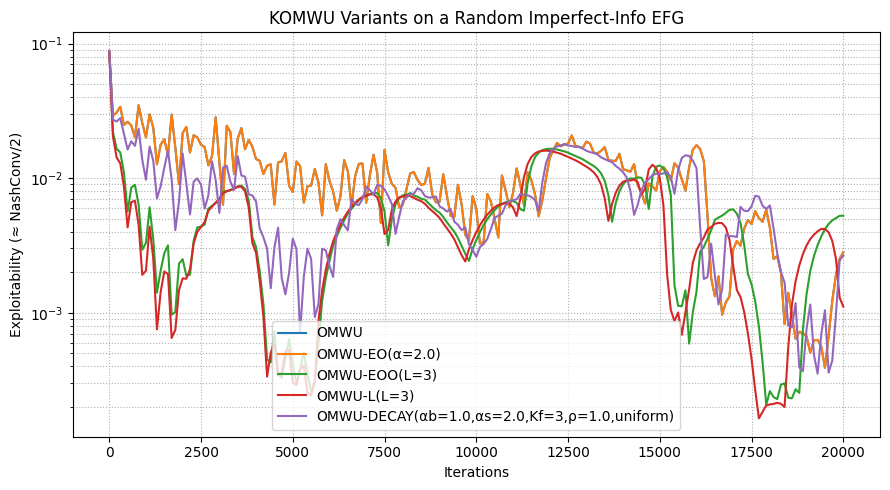

In [1]:
#@title KOMWU Treeplex — Run Multiple Variants Together (clean config style)
#@markdown - **ALGOS** holds only variant names.
#@markdown - **VARIANT_CFG** holds per-variant hyperparameters.
#@markdown - Random imperfect-information EFG with chance; entropic Treeplex map; stable numerics.

from __future__ import annotations
import sys, math
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt

# ============================ VARIANTS & CONFIG ============================
# Put only names in ALGOS. Configure each under VARIANT_CFG.
ALGOS = ["OMWU", "OMWU-EO", "OMWU-EOO", "OMWU-L", "OMWU-DECAY"]  # edit this list

VARIANT_CFG: Dict[str, Dict] = {
    "OMWU":       {"eta": 0.40},
    "OMWU-EO":    {"eta": 0.40, "alpha": 2.0},     # or use "L": 3 (if you prefer breadth form)
    "OMWU-EOO":   {"eta": 0.40, "L": 3},
    "OMWU-L":     {"eta": 0.40, "L": 3},
    "OMWU-DECAY": {"eta": 0.40, "alpha_b": 1.0, "alpha_s": 2.0, "rho": 1.0, "Kf": 3,
                   "scheme": "uniform", "normalize": True},
}

# ============================ numerics ============================
def get_dtype(precision: str):
    if precision not in {"normal","precise"}:
        raise ValueError("precision must be 'normal' or 'precise'")
    return np.float64 if precision == "normal" else np.longdouble

def logsumexp_np(v: np.ndarray) -> np.floating:
    m = np.max(v)
    return m + np.log(np.sum(np.exp(v - m)))

# ============================ Treeplex ============================
class Treeplex:
    class Infoset:
        __slots__ = ("start_sequence_id","end_sequence_id","parent_sequence_id","infoset_id")
        def __init__(self, start_seq: int, end_seq: int, parent_seq: int, infoset_id: int):
            self.start_sequence_id  = int(start_seq)
            self.end_sequence_id    = int(end_seq)
            self.parent_sequence_id = int(parent_seq)
            self.infoset_id         = int(infoset_id)

    def __init__(self, infosets: List["Treeplex.Infoset"], n_sequences_hint: Optional[int]=None):
        self.infosets: List[Treeplex.Infoset] = infosets
        self.n_infosets = len(infosets)
        if self.n_infosets == 0:
            self.root_sequence_id = 0
            self.n_sequences = 1
            self.children = [[]]
            return

        self.root_sequence_id = max(ifs.parent_sequence_id for ifs in infosets)
        if n_sequences_hint is None:
            max_action_seq = max(ifs.end_sequence_id for ifs in infosets)
            self.n_sequences = max(self.root_sequence_id, max_action_seq) + 1
        else:
            self.n_sequences = int(n_sequences_hint)

        self.children: List[List[Treeplex.Infoset]] = [[] for _ in range(self.n_sequences)]
        for ifs in infosets:
            self.children[ifs.parent_sequence_id].append(ifs)

    def is_sf_strategy(self, x: np.ndarray) -> bool:
        if not np.all(x >= 0): return False
        if abs(float(x[self.root_sequence_id]) - 1.0) > 1e-9: return False
        for ifs in self.infosets:
            s = -float(x[ifs.parent_sequence_id])
            for seq in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                s += float(x[seq])
            if abs(s) > 1e-9:
                return False
        return True

    def best_response_value(self, gradient: np.ndarray) -> float:
        g = np.asarray(gradient, dtype=gradient.dtype).copy()
        for ifs in self.infosets:  # bottom-up order (children → parent)
            sl = g[ifs.start_sequence_id:ifs.end_sequence_id+1]
            g[ifs.parent_sequence_id] += np.max(sl)
        return float(g[self.root_sequence_id])

# ============================ KOMWU base + variants ============================
class KomwuBase:
    """Base class; subclasses override _direction(g_t)."""
    def __init__(self, tpx: Treeplex, eta: float = 0.3, dtype=None):
        self.tpx = tpx
        self.eta = float(eta)
        self.dtype = np.float64 if dtype is None else dtype
        self.b = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.last_gradient = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self._hist: List[np.ndarray] = []  # most-recent first
        self._prepare_topo()
        self._compute_x()
        # regret diagnostics (optional)
        self.sum_gradients = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.sum_ev = self.dtype(0.0)

    def next_strategy(self) -> np.ndarray:
        return self.x

    def regret(self) -> float:
        return self.tpx.best_response_value(self.sum_gradients) - float(self.sum_ev)

    def observe_gradient(self, gradient: np.ndarray):
        g_t = np.asarray(gradient, dtype=self.dtype)
        self.sum_gradients += g_t
        self.sum_ev += float(np.dot(g_t, self.next_strategy()))
        d_t = self._direction(g_t)
        self.b += self.dtype(self.eta) * d_t
        self._compute_x()
        self._hist.insert(0, g_t.copy())
        if len(self._hist) > 256: self._hist.pop()
        self.last_gradient = g_t

    # override in subclasses
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def _get_hist(self, k: int, default_zero: Optional[np.ndarray]=None) -> np.ndarray:
        if k < len(self._hist): return self._hist[k]
        if default_zero is None:
            return np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        return default_zero

    # treeplex mapping
    def _prepare_topo(self):
        seq_owner = {}
        for ifs in self.tpx.infosets:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                seq_owner[s] = ifs.infoset_id
        adj = [[] for _ in range(self.tpx.n_infosets)]
        roots = []
        for ifs in self.tpx.infosets:
            ps = ifs.parent_sequence_id
            if ps in seq_owner:
                adj[seq_owner[ps]].append(ifs.infoset_id)
            else:
                roots.append(ifs.infoset_id)
        seen = [False]*self.tpx.n_infosets
        post = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]:
                dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in range(self.tpx.n_infosets):
            if not seen[i]: dfs(i)
        id2if = {ifs.infoset_id: ifs for ifs in self.tpx.infosets}
        self._post_infosets = [id2if[i] for i in post]  # children→parent order

    def _compute_x(self):
        # bottom-up K_j
        K_j = [None] * self.tpx.n_infosets
        for ifs in self._post_infosets:
            terms = []
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                terms.append(self.b[s] + child_sum)
            K_j[ifs.infoset_id] = logsumexp_np(np.asarray(terms, dtype=self.dtype))
        # top-down y
        y = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        for ifs in reversed(self._post_infosets):
            Kj = K_j[ifs.infoset_id]
            y_parent = y[ifs.parent_sequence_id]
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                y[s] = y_parent + self.b[s] + child_sum - Kj
        self.x = np.exp(y)

        # tiny safety projection if drift
        if not self.tpx.is_sf_strategy(self.x):
            for ifs in self.tpx.infosets:
                p = ifs.parent_sequence_id
                sl = slice(ifs.start_sequence_id, ifs.end_sequence_id+1)
                ssum = float(np.sum(self.x[sl]))
                if ssum > 0:
                    self.x[sl] *= float(self.x[p]) / ssum
            self.x[self.tpx.root_sequence_id] = 1.0

# ---- concrete variants ----
class KomwuOMWU(KomwuBase):
    # d_t = 2 g_t - g_{t-1}
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        return self.dtype(2.0) * g_t - self.last_gradient

class KomwuEO(KomwuBase):
    """
    Extra optimism:
      α-form: d_t = α g_t - (α-1) g_{t-1}
      L-form: d_t = (L+1) g_t - L g_{t-1}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: Optional[int]=None, alpha: Optional[float]=None, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = None if L is None else int(L)
        self.alpha = None if alpha is None else float(alpha)
        if self.L is None and self.alpha is None:
            self.alpha = 2.0
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self.last_gradient
        if self.L is not None:
            return self.dtype(self.L+1) * g_t - self.dtype(self.L) * g_tm1
        a = self.dtype(self.alpha)
        return a * g_t - (a - self.dtype(1.0)) * g_tm1

class KomwuEOO(KomwuBase):
    """
    Staggered extra optimism:
      d_t = (L+1) g_t - g_{t-1} - pending_t
      pending_{t+1} = max(L-1,0) * g_{t-1}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: int=2, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = int(max(1, L))
        self._pending = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self.last_gradient
        d = self.dtype(self.L+1) * g_t - g_tm1 - self._pending
        self._pending = self.dtype(max(self.L-1,0)) * g_tm1
        return d

class KomwuL(KomwuBase):
    """
    Windowed:
      d_t = (L+1) g_t - sum_{i=1}^L g_{t-i}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: int=2, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = int(max(1, L))
        self._sum_hist = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.dtype(self.L+1) * g_t - self._sum_hist
        self._sum_hist += g_t
        if len(self._hist) >= self.L:
            self._sum_hist -= self._hist[self.L-1]
        return d

class KomwuDECAY(KomwuBase):
    """
    DECAY (finite-tap increments):
      d_t = α_b g_t + α_s ∑_{j=0}^{Kf-1} w_j (g_{t-j} - g_{t-j-1})
    with weights uniform (default) or geometric (rho ∈ [0,1)).
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3,
                 alpha_b: float=1.0, alpha_s: float=2.0, Kf: int=2, rho: float=1.0,
                 scheme: str="uniform", normalize: bool=True, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.alpha_b = self.dtype(alpha_b)
        self.alpha_s = self.dtype(alpha_s)
        self.Kf = int(max(0, Kf))
        self.rho = float(rho)
        self.scheme = scheme
        self.normalize = normalize
        self._build_weights()
    def _build_weights(self):
        if self.Kf <= 0:
            self._w = np.zeros(0, dtype=self.dtype); return
        if self.scheme == "geom" and 0.0 <= self.rho < 1.0:
            w = np.array([(1.0 - self.rho) * (self.rho ** j) for j in range(self.Kf)], dtype=float)
            if self.normalize:
                s = w.sum()
                if s > 0: w = w / s
        else:
            w = np.ones(self.Kf, dtype=float) / float(self.Kf)
        self._w = np.asarray(w, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.alpha_b * g_t
        if self.Kf > 0:
            zeros = np.zeros_like(g_t)
            inc = np.zeros_like(g_t)
            for j in range(self.Kf):
                g_t_j   = g_t if j == 0 else self._get_hist(j-1, zeros)
                g_t_jm1 = self._get_hist(j, zeros)
                inc += self._w[j] * (g_t_j - g_t_jm1)
            d = d + self.alpha_s * inc
        return d

# ============================ EFG primitives ============================
@dataclass
class PayoffEntry:
    payoffs: List[float]
    chanceFactor: float
    sequences: List[int]

class Game:
    def __init__(self, tpxs: List[Treeplex], entries: List[PayoffEntry]):
        self.tpxs = tpxs
        self.payoff_matrix_entries = entries
        self.n_players = len(tpxs)
        self.payoff_matrix_nnz = len(entries)
        self.notes = "Random EFG (two-player zero-sum)."
    def utility_gradient(self, player: int, strategies: Dict[int,np.ndarray]) -> np.ndarray:
        grad = np.zeros(self.tpxs[player].n_sequences, dtype=strategies[player].dtype)
        # Underflow on off-reach products is harmless; keep other errors strict
        with np.errstate(under='ignore'):
            for e in self.payoff_matrix_entries:
                reach = e.chanceFactor
                for p in range(self.n_players):
                    if p != player:
                        reach *= strategies[p][e.sequences[p]]
                grad[e.sequences[player]] += e.payoffs[player] * reach
        return grad

# ========== Random EFG builder (chance + imperfect-information infosets) ==========
class RandomEFGBuilder:
    """
    Two-player zero-sum EFG with chance and imperfect information.
    Infosets can share multiple nodes by (player, parent_sequence).
    modes: "perfect" | "imperfect" | "mixed" (probabilistic sharing).
    """
    def __init__(self,
                 depth: int = 5,
                 branch_min: int = 2,
                 branch_max: int = 3,
                 chance_every: int = 2,
                 chance_branches: int = 3,
                 stop_prob: float = 0.0,
                 infosets_mode: str = "imperfect",
                 merge_prob: float = 0.6,
                 seed: int = 0,
                 dtype=np.float64):
        self.depth = int(depth)
        self.branch_min = int(branch_min)
        self.branch_max = int(branch_max)
        self.chance_every = int(chance_every)
        self.chance_branches = int(chance_branches)
        self.stop_prob = float(stop_prob)
        self.infosets_mode = infosets_mode
        self.merge_prob = float(merge_prob)
        self.rng = np.random.default_rng(seed)
        self.dtype = dtype

        self.next_seq = [0, 0]
        self.infosets: List[List[Tuple[int,int,int]]] = [[], []]  # (start,end,parent)
        self.registry: List[Dict[int, Tuple[int,int,int]]] = [dict(), dict()]
        self.entries: List[PayoffEntry] = []

    def _rand_actions(self) -> int:
        return int(self.rng.integers(self.branch_min, self.branch_max + 1))
    def _rand_payoff(self) -> float:
        return float(self.rng.uniform(-1.0, 1.0))
    def _should_stop(self, depth: int) -> bool:
        if depth >= self.depth: return True
        if self.stop_prob > 0 and self.rng.random() < self.stop_prob: return True
        return False
    def _node_type(self, depth: int) -> str:
        if self.chance_every > 0 and (depth % (self.chance_every + 1) == 0):
            return "chance"
        return "p0" if (depth % 2 == 0) else "p1"
    def _chance_outcomes(self) -> Tuple[np.ndarray, int]:
        k = max(2, self.chance_branches)
        probs = self.rng.random(k); probs /= probs.sum()
        return probs.astype(self.dtype), k
    def _should_share(self) -> bool:
        if self.infosets_mode == "imperfect": return True
        if self.infosets_mode == "perfect":   return False
        return bool(self.rng.random() < self.merge_prob)

    def _get_or_create_infoset(self, p: int, parent_seq: int) -> Tuple[int,int,int]:
        # Reuse infoset by (player, parent_seq) if sharing is selected
        if self._should_share() and (parent_seq in self.registry[p]):
            start, end, _ = self.registry[p][parent_seq]
            return start, end, parent_seq
        nA = self._rand_actions()
        start = self.next_seq[p]; end = start + nA - 1
        self.next_seq[p] += nA
        self.infosets[p].append((start, end, parent_seq))
        if self.infosets_mode in {"imperfect","mixed"}:
            self.registry[p][parent_seq] = (start, end, nA)
        return start, end, parent_seq

    def _build(self, depth: int, last_seq0: int, last_seq1: int, chance_weight: float):
        if self._should_stop(depth):
            u = self._rand_payoff()
            self.entries.append(PayoffEntry([u, -u], chance_weight, [last_seq0, last_seq1]))
            return
        kind = self._node_type(depth)
        if kind == "chance":
            probs, k = self._chance_outcomes()
            for j in range(k):
                self._build(depth+1, last_seq0, last_seq1, chance_weight * float(probs[j]))
            return
        p = 0 if kind == "p0" else 1
        parent_seq = last_seq0 if p == 0 else last_seq1
        start, end, _ = self._get_or_create_infoset(p, parent_seq)
        for s in range(start, end+1):
            if p == 0: self._build(depth+1, s, last_seq1, chance_weight)
            else:      self._build(depth+1, last_seq0, s, chance_weight)

    def _finalize_treeplex(self, p: int) -> Treeplex:
        max_seq = max([end for (start,end,parent) in self.infosets[p]], default=-1)
        root_seq_id = max_seq + 1
        fixed = []
        for (start,end,parent) in self.infosets[p]:
            fixed.append((start, end, (root_seq_id if parent == -1 else parent)))
        prov = [Treeplex.Infoset(s,e,parent,idx) for idx,(s,e,parent) in enumerate(fixed)]

        seq_owner: Dict[int,int] = {}
        for ifs in prov:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id+1):
                seq_owner[s] = ifs.infoset_id
        adj: Dict[int,List[int]] = {ifs.infoset_id: [] for ifs in prov}
        roots: List[int] = []
        for ifs in prov:
            ps = ifs.parent_sequence_id
            if ps in seq_owner: adj[seq_owner[ps]].append(ifs.infoset_id)
            else: roots.append(ifs.infoset_id)

        seen = {i: False for i in adj}
        post: List[int] = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]: dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in list(adj.keys()):
            if not seen[i]: dfs(i)

        id_map = {old:new for new,old in enumerate(post)}
        infosets_sorted = []
        for old in post:
            ifs = prov[old]
            infosets_sorted.append(
                Treeplex.Infoset(ifs.start_sequence_id, ifs.end_sequence_id, ifs.parent_sequence_id, id_map[old])
            )
        return Treeplex(infosets_sorted, n_sequences_hint=root_seq_id+1)

    def build(self) -> Game:
        self._build(0, -1, -1, 1.0)
        tpx0 = self._finalize_treeplex(0)
        tpx1 = self._finalize_treeplex(1)
        r0, r1 = tpx0.root_sequence_id, tpx1.root_sequence_id
        for e in self.entries:
            if e.sequences[0] == -1: e.sequences[0] = r0
            if e.sequences[1] == -1: e.sequences[1] = r1
        return Game([tpx0, tpx1], self.entries)

# ============================ metrics & factory ============================
def nash_conv_and_ev(game: Game, x: Dict[int,np.ndarray]) -> Tuple[float,float,float]:
    g0 = game.utility_gradient(0, x)
    g1 = game.utility_gradient(1, x)
    ev0 = float(np.dot(g0, x[0]))
    ev1 = float(np.dot(g1, x[1]))
    br0 = float(game.tpxs[0].best_response_value(g0))
    br1 = float(game.tpxs[1].best_response_value(g1))
    nconv = (br0 - ev0) + (br1 - ev1)
    return nconv, 0.5 * max(nconv, 0.0), ev0  # exploitability = NashConv/2

def make_solver(name: str, cfg: Dict, tpx: Treeplex, DTYPE):
    v = name.strip().upper().replace("KOMWU","OMWU")
    eta = float(cfg.get("eta", 0.4))
    if v == "OMWU":
        return f"OMWU", KomwuOMWU(tpx, eta=eta, dtype=DTYPE)

    if v in {"OMWU-EO","EO"}:
        # Prefer alpha if provided; else L
        alpha = cfg.get("alpha", None)
        L = cfg.get("L", None)
        if alpha is not None:
            return f"OMWU-EO(α={alpha})", KomwuEO(tpx, eta=eta, alpha=float(alpha), L=None, dtype=DTYPE)
        L = int(L if L is not None else 2)
        return f"OMWU-EO(L={L})", KomwuEO(tpx, eta=eta, L=L, alpha=None, dtype=DTYPE)

    if v in {"OMWU-EOO","EOO"}:
        L = int(cfg.get("L", 2))
        return f"OMWU-EOO(L={L})", KomwuEOO(tpx, eta=eta, L=L, dtype=DTYPE)

    if v in {"OMWU-L","L"}:
        L = int(cfg.get("L", 2))
        return f"OMWU-L(L={L})", KomwuL(tpx, eta=eta, L=L, dtype=DTYPE)

    if v in {"OMWU-DECAY","DECAY"}:
        ab  = float(cfg.get("alpha_b", 1.0))
        aS  = float(cfg.get("alpha_s", 2.0))
        Kf  = int(cfg.get("Kf", 2))
        rho = float(cfg.get("rho", 1.0))
        scheme = str(cfg.get("scheme", "uniform")).lower()
        normalize = bool(cfg.get("normalize", True))
        label = f"OMWU-DECAY(αb={ab},αs={aS},Kf={Kf},ρ={rho},{scheme})"
        return label, KomwuDECAY(tpx, eta=eta, alpha_b=ab, alpha_s=aS, Kf=Kf, rho=rho,
                                 scheme=scheme, normalize=normalize, dtype=DTYPE)

    raise ValueError(f"Unknown variant '{name}'")

# ============================ multi-variant runner ============================
def run_all_variants(
    # ---- EFG shape ----
    depth=5, branch_min=2, branch_max=3,
    chance_every=2, chance_branches=3, stop_prob=0.0,
    infosets_mode="imperfect", merge_prob=0.7,
    # ---- Numerics / train ----
    T=20000, eta_global=None, precision="precise", seed=0, print_every=500, plot_every=100
):
    DTYPE = get_dtype(precision)
    np.seterr(over='raise', divide='raise', invalid='raise', under='ignore')
    rng = np.random.default_rng(seed)

    # Build one shared game
    builder = RandomEFGBuilder(
        depth=depth, branch_min=branch_min, branch_max=branch_max,
        chance_every=chance_every, chance_branches=chance_branches,
        stop_prob=stop_prob, infosets_mode=infosets_mode, merge_prob=merge_prob,
        seed=seed, dtype=DTYPE
    )
    game = builder.build()
    print(f"=== Random EFG built ===")
    print(f"  players           : {game.n_players}")
    print(f"  P0 infosets       : {game.tpxs[0].n_infosets}")
    print(f"  P1 infosets       : {game.tpxs[1].n_infosets}")
    print(f"  P0 sequences      : {game.tpxs[0].n_sequences} (root={game.tpxs[0].root_sequence_id})")
    print(f"  P1 sequences      : {game.tpxs[1].n_sequences} (root={game.tpxs[1].root_sequence_id})")
    print(f"  payoff nnz        : {game.payoff_matrix_nnz}")
    print(f"  notes             : {game.notes}")
    print(f"========================\n")

    # Instantiate solvers per variant (self-play for each)
    bundles = []  # (label, row_solver, col_solver)
    for name in ALGOS:
        if name not in VARIANT_CFG:
            raise ValueError(f"Variant '{name}' missing in VARIANT_CFG.")
        cfg = dict(VARIANT_CFG[name])
        if eta_global is not None:
            cfg["eta"] = float(eta_global)
        label_row, row = make_solver(name, cfg, game.tpxs[0], DTYPE)
        label_col, col = make_solver(name, cfg, game.tpxs[1], DTYPE)
        assert label_row == label_col
        label = label_row
        # tiny jitter to break perfect symmetry
        row.b += np.asarray(rng.normal(0, 1e-12, size=row.b.shape), dtype=DTYPE)
        col.b += np.asarray(rng.normal(0, 1e-12, size=col.b.shape), dtype=DTYPE)
        row._compute_x(); col._compute_x()
        bundles.append((label, row, col))

    curves = {label: {"times": [], "exploit": [], "nashconv": []} for (label,_,_) in bundles}

    # Train all bundles on the same game
    for t in range(1, T+1):
        for (label, row, col) in bundles:
            strategies = {0: row.next_strategy(), 1: col.next_strategy()}
            g0 = game.utility_gradient(0, strategies)
            g1 = game.utility_gradient(1, strategies)
            row.observe_gradient(g0)
            col.observe_gradient(g1)

            if (t % plot_every) == 0 or t == 1:
                strategies = {0: row.next_strategy(), 1: col.next_strategy()}
                nc, ex, _ = nash_conv_and_ev(game, strategies)
                curves[label]["times"].append(t)
                curves[label]["exploit"].append(ex)
                curves[label]["nashconv"].append(nc)

            if (t % print_every) == 0 or t == 1:
                ex = curves[label]["exploit"][-1] if curves[label]["exploit"] else float('nan')
                nc = curves[label]["nashconv"][-1] if curves[label]["nashconv"] else float('nan')
                print(f"[{label:28s}] t={t:6d}  exploit={ex:.6e}  nashconv={nc:.6e}  η={VARIANT_CFG[name]['eta'] if eta_global is None else eta_global:.2e}")

    # Plot
    if curves:
        plt.figure(figsize=(9,5))
        for label, data in curves.items():
            if not data["times"]: continue
            xs = np.asarray(data["times"], dtype=float)
            ys = np.maximum(np.asarray(data["exploit"], dtype=float), 1e-18)
            plt.plot(xs, ys, label=label)
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (≈ NashConv/2)")
        plt.title("KOMWU Variants on a Random Imperfect-Info EFG")
        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return curves

# ============================ Runner (edit here) ============================
#@title Run all variants (edit lists/dicts above as needed)
# ---- Game shape ----
depth = 7               #@param {type:"integer"}
branch_min = 3          #@param {type:"integer"}
branch_max = 4          #@param {type:"integer"}
chance_every = 2        #@param {type:"integer"}
chance_branches = 3     #@param {type:"integer"}
stop_prob = 0.0         #@param {type:"number"}
infosets_mode = "imperfect"  #@param ["perfect","imperfect","mixed"]
merge_prob = 0.7             #@param {type:"number"}

# ---- Training / numerics ----
T = 20000                    #@param {type:"integer"}
precision = "precise"        #@param ["normal","precise"]
seed = 10                     #@param {type:"integer"}
print_every = 500            #@param {type:"integer"}
plot_every = 100             #@param {type:"integer"}
eta_global = None            #@param {type:"raw"}  # set a float to override all per-variant etas

curves = run_all_variants(
    depth=depth, branch_min=branch_min, branch_max=branch_max,
    chance_every=chance_every, chance_branches=chance_branches, stop_prob=stop_prob,
    infosets_mode=infosets_mode, merge_prob=merge_prob,
    T=T, eta_global=eta_global, precision=precision, seed=seed,
    print_every=print_every, plot_every=plot_every
)


In [31]:
###############################

In [1]:
#@title KOMWU Treeplex — Run Multiple Variants Together (now prints tree info first)
#@markdown - **ALGOS** holds only variant names.
#@markdown - **VARIANT_CFG** holds per-variant hyperparameters.
#@markdown - Random imperfect-information EFG with chance; entropic Treeplex map; stable numerics.
#@markdown - Calls `describe_game(game)` **before** training to show the treeplex structure.

from __future__ import annotations
import sys, math
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import matplotlib.pyplot as plt

# ============================ VARIANTS & CONFIG ============================
# Put only names in ALGOS. Configure each under VARIANT_CFG.
ALGOS = ["OMWU", "OMWU-EO", "OMWU-EOO", "OMWU-L", "OMWU-DECAY"]  # edit this list

VARIANT_CFG: Dict[str, Dict] = {
    "OMWU":       {"eta": 0.40},
    "OMWU-EO":    {"eta": 0.40, "L": 4.0},     # or use "L": 3 instead of "alpha"
    "OMWU-EOO":   {"eta": 0.40, "L": 4},
    "OMWU-L":     {"eta": 0.40, "L": 4},
    "OMWU-DECAY": {"eta": 0.40, "alpha_b": 1.0, "alpha_s": 2.0, "rho": 1.0, "Kf": 3,
                   "scheme": "uniform", "normalize": True},
}

# ============================ numerics ============================
def get_dtype(precision: str):
    if precision not in {"normal","precise"}:
        raise ValueError("precision must be 'normal' or 'precise'")
    return np.float64 if precision == "normal" else np.longdouble

def logsumexp_np(v: np.ndarray) -> np.floating:
    m = np.max(v)
    return m + np.log(np.sum(np.exp(v - m)))

# ============================ Treeplex ============================
class Treeplex:
    class Infoset:
        __slots__ = ("start_sequence_id","end_sequence_id","parent_sequence_id","infoset_id")
        def __init__(self, start_seq: int, end_seq: int, parent_seq: int, infoset_id: int):
            self.start_sequence_id  = int(start_seq)
            self.end_sequence_id    = int(end_seq)
            self.parent_sequence_id = int(parent_seq)
            self.infoset_id         = int(infoset_id)

    def __init__(self, infosets: List["Treeplex.Infoset"], n_sequences_hint: Optional[int]=None):
        self.infosets: List[Treeplex.Infoset] = infosets
        self.n_infosets = len(infosets)
        if self.n_infosets == 0:
            self.root_sequence_id = 0
            self.n_sequences = 1
            self.children = [[]]
            return

        self.root_sequence_id = max(ifs.parent_sequence_id for ifs in infosets)
        if n_sequences_hint is None:
            max_action_seq = max(ifs.end_sequence_id for ifs in infosets)
            self.n_sequences = max(self.root_sequence_id, max_action_seq) + 1
        else:
            self.n_sequences = int(n_sequences_hint)

        self.children: List[List[Treeplex.Infoset]] = [[] for _ in range(self.n_sequences)]
        for ifs in infosets:
            self.children[ifs.parent_sequence_id].append(ifs)

    def is_sf_strategy(self, x: np.ndarray) -> bool:
        if not np.all(x >= 0): return False
        if abs(float(x[self.root_sequence_id]) - 1.0) > 1e-9: return False
        for ifs in self.infosets:
            s = -float(x[ifs.parent_sequence_id])
            for seq in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                s += float(x[seq])
            if abs(s) > 1e-9:
                return False
        return True

    def best_response_value(self, gradient: np.ndarray) -> float:
        g = np.asarray(gradient, dtype=gradient.dtype).copy()
        for ifs in self.infosets:  # bottom-up order (children → parent)
            sl = g[ifs.start_sequence_id:ifs.end_sequence_id+1]
            g[ifs.parent_sequence_id] += np.max(sl)
        return float(g[self.root_sequence_id])

# ============================ KOMWU base + variants ============================
class KomwuBase:
    """Base class; subclasses override _direction(g_t)."""
    def __init__(self, tpx: Treeplex, eta: float = 0.3, dtype=None):
        self.tpx = tpx
        self.eta = float(eta)
        self.dtype = np.float64 if dtype is None else dtype
        self.b = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.last_gradient = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self._hist: List[np.ndarray] = []  # most-recent first
        self._prepare_topo()
        self._compute_x()
        # regret diagnostics (optional)
        self.sum_gradients = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        self.sum_ev = self.dtype(0.0)

    def next_strategy(self) -> np.ndarray:
        return self.x

    def regret(self) -> float:
        return self.tpx.best_response_value(self.sum_gradients) - float(self.sum_ev)

    def observe_gradient(self, gradient: np.ndarray):
        g_t = np.asarray(gradient, dtype=self.dtype)
        self.sum_gradients += g_t
        self.sum_ev += float(np.dot(g_t, self.next_strategy()))
        d_t = self._direction(g_t)
        self.b += self.dtype(self.eta) * d_t
        self._compute_x()
        self._hist.insert(0, g_t.copy())
        if len(self._hist) > 256: self._hist.pop()
        self.last_gradient = g_t

    # override in subclasses
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def _get_hist(self, k: int, default_zero: Optional[np.ndarray]=None) -> np.ndarray:
        if k < len(self._hist): return self._hist[k]
        if default_zero is None:
            return np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        return default_zero

    # treeplex mapping
    def _prepare_topo(self):
        seq_owner = {}
        for ifs in self.tpx.infosets:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                seq_owner[s] = ifs.infoset_id
        adj = [[] for _ in range(self.tpx.n_infosets)]
        roots = []
        for ifs in self.tpx.infosets:
            ps = ifs.parent_sequence_id
            if ps in seq_owner:
                adj[seq_owner[ps]].append(ifs.infoset_id)
            else:
                roots.append(ifs.infoset_id)
        seen = [False]*self.tpx.n_infosets
        post = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]:
                dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in range(self.tpx.n_infosets):
            if not seen[i]: dfs(i)
        id2if = {ifs.infoset_id: ifs for ifs in self.tpx.infosets}
        self._post_infosets = [id2if[i] for i in post]  # children→parent order

    def _compute_x(self):
        # bottom-up K_j
        K_j = [None] * self.tpx.n_infosets
        for ifs in self._post_infosets:
            terms = []
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                terms.append(self.b[s] + child_sum)
            K_j[ifs.infoset_id] = logsumexp_np(np.asarray(terms, dtype=self.dtype))
        # top-down y
        y = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
        for ifs in reversed(self._post_infosets):
            Kj = K_j[ifs.infoset_id]
            y_parent = y[ifs.parent_sequence_id]
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id + 1):
                child_sum = self.dtype(0.0)
                for child in self.tpx.children[s]:
                    child_sum += K_j[child.infoset_id]
                y[s] = y_parent + self.b[s] + child_sum - Kj
        self.x = np.exp(y)

        # tiny safety projection if drift
        if not self.tpx.is_sf_strategy(self.x):
            for ifs in self.tpx.infosets:
                p = ifs.parent_sequence_id
                sl = slice(ifs.start_sequence_id, ifs.end_sequence_id+1)
                ssum = float(np.sum(self.x[sl]))
                if ssum > 0:
                    self.x[sl] *= float(self.x[p]) / ssum
            self.x[self.tpx.root_sequence_id] = 1.0

# ---- concrete variants ----
class KomwuOMWU(KomwuBase):
    # d_t = 2 g_t - g_{t-1}
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        return self.dtype(2.0) * g_t - self.last_gradient

class KomwuEO(KomwuBase):
    """
    Extra optimism:
      α-form: d_t = α g_t - (α-1) g_{t-1}
      L-form: d_t = (L+1) g_t - L g_{t-1}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: Optional[int]=None, alpha: Optional[float]=None, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = None if L is None else int(L)
        self.alpha = None if alpha is None else float(alpha)
        if self.L is None and self.alpha is None:
            self.alpha = 2.0
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self.last_gradient
        if self.L is not None:
            return self.dtype(self.L+1) * g_t - self.dtype(self.L) * g_tm1
        a = self.dtype(self.alpha)
        return a * g_t - (a - self.dtype(1.0)) * g_tm1

class KomwuEOO(KomwuBase):
    """
    Staggered extra optimism:
      d_t = (L+1) g_t - g_{t-1} - pending_t
      pending_{t+1} = max(L-1,0) * g_{t-1}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: int=2, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = int(max(1, L))
        self._pending = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self.last_gradient
        d = self.dtype(self.L+1) * g_t - g_tm1 - self._pending
        self._pending = self.dtype(max(self.L-1,0)) * g_tm1
        return d

class KomwuL(KomwuBase):
    """
    Windowed:
      d_t = (L+1) g_t - sum_{i=1}^L g_{t-i}
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3, L: int=2, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.L = int(max(1, L))
        self._sum_hist = np.zeros(self.tpx.n_sequences, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.dtype(self.L+1) * g_t - self._sum_hist
        self._sum_hist += g_t
        if len(self._hist) >= self.L:
            self._sum_hist -= self._hist[self.L-1]
        return d

class KomwuDECAY(KomwuBase):
    """
    DECAY (finite-tap increments):
      d_t = α_b g_t + α_s ∑_{j=0}^{Kf-1} w_j (g_{t-j} - g_{t-j-1})
    with weights uniform (default) or geometric (rho ∈ [0,1)).
    """
    def __init__(self, tpx: Treeplex, eta: float=0.3,
                 alpha_b: float=1.0, alpha_s: float=2.0, Kf: int=2, rho: float=1.0,
                 scheme: str="uniform", normalize: bool=True, dtype=None):
        super().__init__(tpx, eta, dtype=dtype)
        self.alpha_b = self.dtype(alpha_b)
        self.alpha_s = self.dtype(alpha_s)
        self.Kf = int(max(0, Kf))
        self.rho = float(rho)
        self.scheme = scheme
        self.normalize = normalize
        self._build_weights()
    def _build_weights(self):
        if self.Kf <= 0:
            self._w = np.zeros(0, dtype=self.dtype); return
        if self.scheme == "geom" and 0.0 <= self.rho < 1.0:
            w = np.array([(1.0 - self.rho) * (self.rho ** j) for j in range(self.Kf)], dtype=float)
            if self.normalize:
                s = w.sum()
                if s > 0: w = w / s
        else:
            w = np.ones(self.Kf, dtype=float) / float(self.Kf)
        self._w = np.asarray(w, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.alpha_b * g_t
        if self.Kf > 0:
            zeros = np.zeros_like(g_t)
            inc = np.zeros_like(g_t)
            for j in range(self.Kf):
                g_t_j   = g_t if j == 0 else self._get_hist(j-1, zeros)
                g_t_jm1 = self._get_hist(j, zeros)
                inc += self._w[j] * (g_t_j - g_t_jm1)
            d = d + self.alpha_s * inc
        return d

# ============================ EFG primitives ============================
@dataclass
class PayoffEntry:
    payoffs: List[float]
    chanceFactor: float
    sequences: List[int]

class Game:
    def __init__(self, tpxs: List[Treeplex], entries: List[PayoffEntry]):
        self.tpxs = tpxs
        self.payoff_matrix_entries = entries
        self.n_players = len(tpxs)
        self.payoff_matrix_nnz = len(entries)
        self.notes = "Random EFG (two-player zero-sum)."
    def utility_gradient(self, player: int, strategies: Dict[int,np.ndarray]) -> np.ndarray:
        grad = np.zeros(self.tpxs[player].n_sequences, dtype=strategies[player].dtype)
        # Underflow on off-reach products is harmless; keep other errors strict
        with np.errstate(under='ignore'):
            for e in self.payoff_matrix_entries:
                reach = e.chanceFactor
                for p in range(self.n_players):
                    if p != player:
                        reach *= strategies[p][e.sequences[p]]
                grad[e.sequences[player]] += e.payoffs[player] * reach
        return grad

# ========== Random EFG builder (chance + imperfect-information infosets) ==========
class RandomEFGBuilder:
    """
    Two-player zero-sum EFG with chance and imperfect information.
    Infosets can share multiple nodes by (player, parent_sequence).
    modes: "perfect" | "imperfect" | "mixed" (probabilistic sharing).
    """
    def __init__(self,
                 depth: int = 5,
                 branch_min: int = 2,
                 branch_max: int = 3,
                 chance_every: int = 2,
                 chance_branches: int = 3,
                 stop_prob: float = 0.0,
                 infosets_mode: str = "imperfect",
                 merge_prob: float = 0.6,
                 seed: int = 0,
                 dtype=np.float64):
        self.depth = int(depth)
        self.branch_min = int(branch_min)
        self.branch_max = int(branch_max)
        self.chance_every = int(chance_every)
        self.chance_branches = int(chance_branches)
        self.stop_prob = float(stop_prob)
        self.infosets_mode = infosets_mode
        self.merge_prob = float(merge_prob)
        self.rng = np.random.default_rng(seed)
        self.dtype = dtype

        self.next_seq = [0, 0]
        self.infosets: List[List[Tuple[int,int,int]]] = [[], []]  # (start,end,parent)
        self.registry: List[Dict[int, Tuple[int,int,int]]] = [dict(), dict()]
        self.entries: List[PayoffEntry] = []

    def _rand_actions(self) -> int:
        return int(self.rng.integers(self.branch_min, self.branch_max + 1))
    def _rand_payoff(self) -> float:
        return float(self.rng.uniform(-1.0, 1.0))
    def _should_stop(self, depth: int) -> bool:
        if depth >= self.depth: return True
        if self.stop_prob > 0 and self.rng.random() < self.stop_prob: return True
        return False
    def _node_type(self, depth: int) -> str:
        if self.chance_every > 0 and (depth % (self.chance_every + 1) == 0):
            return "chance"
        return "p0" if (depth % 2 == 0) else "p1"
    def _chance_outcomes(self) -> Tuple[np.ndarray, int]:
        k = max(2, self.chance_branches)
        probs = self.rng.random(k); probs /= probs.sum()
        return probs.astype(self.dtype), k
    def _should_share(self) -> bool:
        if self.infosets_mode == "imperfect": return True
        if self.infosets_mode == "perfect":   return False
        return bool(self.rng.random() < self.merge_prob)

    def _get_or_create_infoset(self, p: int, parent_seq: int) -> Tuple[int,int,int]:
        # Reuse infoset by (player, parent_seq) if sharing is selected
        if self._should_share() and (parent_seq in self.registry[p]):
            start, end, _ = self.registry[p][parent_seq]
            return start, end, parent_seq
        nA = self._rand_actions()
        start = self.next_seq[p]; end = start + nA - 1
        self.next_seq[p] += nA
        self.infosets[p].append((start, end, parent_seq))
        if self.infosets_mode in {"imperfect","mixed"}:
            self.registry[p][parent_seq] = (start, end, nA)
        return start, end, parent_seq

    def _build(self, depth: int, last_seq0: int, last_seq1: int, chance_weight: float):
        if self._should_stop(depth):
            u = self._rand_payoff()
            self.entries.append(PayoffEntry([u, -u], chance_weight, [last_seq0, last_seq1]))
            return
        kind = self._node_type(depth)
        if kind == "chance":
            probs, k = self._chance_outcomes()
            for j in range(k):
                self._build(depth+1, last_seq0, last_seq1, chance_weight * float(probs[j]))
            return
        p = 0 if kind == "p0" else 1
        parent_seq = last_seq0 if p == 0 else last_seq1
        start, end, _ = self._get_or_create_infoset(p, parent_seq)
        for s in range(start, end+1):
            if p == 0: self._build(depth+1, s, last_seq1, chance_weight)
            else:      self._build(depth+1, last_seq0, s, chance_weight)

    def _finalize_treeplex(self, p: int) -> Treeplex:
        max_seq = max([end for (start,end,parent) in self.infosets[p]], default=-1)
        root_seq_id = max_seq + 1
        fixed = []
        for (start,end,parent) in self.infosets[p]:
            fixed.append((start, end, (root_seq_id if parent == -1 else parent)))
        prov = [Treeplex.Infoset(s,e,parent,idx) for idx,(s,e,parent) in enumerate(fixed)]

        seq_owner: Dict[int,int] = {}
        for ifs in prov:
            for s in range(ifs.start_sequence_id, ifs.end_sequence_id+1):
                seq_owner[s] = ifs.infoset_id
        adj: Dict[int,List[int]] = {ifs.infoset_id: [] for ifs in prov}
        roots: List[int] = []
        for ifs in prov:
            ps = ifs.parent_sequence_id
            if ps in seq_owner: adj[seq_owner[ps]].append(ifs.infoset_id)
            else: roots.append(ifs.infoset_id)

        seen = {i: False for i in adj}
        post: List[int] = []
        sys.setrecursionlimit(10000)
        def dfs(u: int):
            if seen[u]: return
            seen[u] = True
            for v in adj[u]: dfs(v)
            post.append(u)
        for r in roots: dfs(r)
        for i in list(adj.keys()):
            if not seen[i]: dfs(i)

        id_map = {old:new for new,old in enumerate(post)}
        infosets_sorted = []
        for old in post:
            ifs = prov[old]
            infosets_sorted.append(
                Treeplex.Infoset(ifs.start_sequence_id, ifs.end_sequence_id, ifs.parent_sequence_id, id_map[old])
            )
        return Treeplex(infosets_sorted, n_sequences_hint=root_seq_id+1)

    def build(self) -> Game:
        self._build(0, -1, -1, 1.0)
        tpx0 = self._finalize_treeplex(0)
        tpx1 = self._finalize_treeplex(1)
        r0, r1 = tpx0.root_sequence_id, tpx1.root_sequence_id
        for e in self.entries:
            if e.sequences[0] == -1: e.sequences[0] = r0
            if e.sequences[1] == -1: e.sequences[1] = r1
        return Game([tpx0, tpx1], self.entries)

# ============================ metrics & factory ============================
def nash_conv_and_ev(game: Game, x: Dict[int,np.ndarray]) -> Tuple[float,float,float]:
    g0 = game.utility_gradient(0, x)
    g1 = game.utility_gradient(1, x)
    ev0 = float(np.dot(g0, x[0]))
    ev1 = float(np.dot(g1, x[1]))
    br0 = float(game.tpxs[0].best_response_value(g0))
    br1 = float(game.tpxs[1].best_response_value(g1))
    nconv = (br0 - ev0) + (br1 - ev1)
    return nconv, 0.5 * max(nconv, 0.0), ev0  # exploitability = NashConv/2

def make_solver(name: str, cfg: Dict, tpx: Treeplex, DTYPE):
    v = name.strip().upper().replace("KOMWU","OMWU")
    eta = float(cfg.get("eta", 0.4))
    if v == "OMWU":
        return f"OMWU", KomwuOMWU(tpx, eta=eta, dtype=DTYPE)

    if v in {"OMWU-EO","EO"}:
        # Prefer alpha if provided; else L
        alpha = cfg.get("alpha", None)
        L = cfg.get("L", None)
        if alpha is not None:
            return f"OMWU-EO(α={alpha})", KomwuEO(tpx, eta=eta, alpha=float(alpha), L=None, dtype=DTYPE)
        L = int(L if L is not None else 2)
        return f"OMWU-EO(L={L})", KomwuEO(tpx, eta=eta, L=L, alpha=None, dtype=DTYPE)

    if v in {"OMWU-EOO","EOO"}:
        L = int(cfg.get("L", 2))
        return f"OMWU-EOO(L={L})", KomwuEOO(tpx, eta=eta, L=L, dtype=DTYPE)

    if v in {"OMWU-L","L"}:
        L = int(cfg.get("L", 2))
        return f"OMWU-L(L={L})", KomwuL(tpx, eta=eta, L=L, dtype=DTYPE)

    if v in {"OMWU-DECAY","DECAY"}:
        ab  = float(cfg.get("alpha_b", 1.0))
        aS  = float(cfg.get("alpha_s", 2.0))
        Kf  = int(cfg.get("Kf", 2))
        rho = float(cfg.get("rho", 1.0))
        scheme = str(cfg.get("scheme", "uniform")).lower()
        normalize = bool(cfg.get("normalize", True))
        label = f"OMWU-DECAY(αb={ab},αs={aS},Kf={Kf},ρ={rho},{scheme})"
        return label, KomwuDECAY(tpx, eta=eta, alpha_b=ab, alpha_s=aS, Kf=Kf, rho=rho,
                                 scheme=scheme, normalize=normalize, dtype=DTYPE)

    raise ValueError(f"Unknown variant '{name}'")

# ============================ describe helper ============================
def describe_game(game: Game):
    def describe_player(pname, tpx: Treeplex):
        print(f"\n== {pname} ==")
        print(f"root_sequence_id = {tpx.root_sequence_id}")
        print(f"n_sequences      = {tpx.n_sequences}  (action sequences = {tpx.n_sequences-1})")
        print(f"n_infosets       = {tpx.n_infosets}")
        total_actions = 0
        parent_to_children = {}
        for ifs in tpx.infosets:
            k = ifs.end_sequence_id - ifs.start_sequence_id + 1
            total_actions += k
            print(f"  Infoset {ifs.infoset_id:>3}: actions [{ifs.start_sequence_id}..{ifs.end_sequence_id}] "
                  f"(k={k}), parent_seq={ifs.parent_sequence_id}")
            parent_to_children.setdefault(ifs.parent_sequence_id, []).append(ifs.infoset_id)
        print(f"  sum of actions over infosets = {total_actions}")
        print("\n  Parent sequence → child infosets")
        for ps, kids in sorted(parent_to_children.items()):
            print(f"    {ps:>3} → {sorted(kids)}")

        print("\n  For each action sequence, child-infosets that sprout from it:")
        for s in range(tpx.n_sequences):
            kids = [I.infoset_id for I in tpx.children[s]]
            if kids:
                print(f"    seq {s:>3} → {sorted(kids)}")

    print("=== GAME SUMMARY ===")
    print(f"players        : {game.n_players}")
    print(f"payoff nnz     : {game.payoff_matrix_nnz}")
    print(f"notes          : {game.notes}")
    describe_player("P0", game.tpxs[0])
    describe_player("P1", game.tpxs[1])
    print()  # spacer

# ============================ multi-variant runner ============================
def run_all_variants(
    # ---- EFG shape ----
    depth=5, branch_min=2, branch_max=3,
    chance_every=2, chance_branches=3, stop_prob=0.0,
    infosets_mode="imperfect", merge_prob=0.7,
    # ---- Numerics / train ----
    T=20000, eta_global=None, precision="precise", seed=0, print_every=500, plot_every=100
):
    DTYPE = get_dtype(precision)
    np.seterr(over='raise', divide='raise', invalid='raise', under='ignore')
    rng = np.random.default_rng(seed)

    # Build one shared game
    builder = RandomEFGBuilder(
        depth=depth, branch_min=branch_min, branch_max=branch_max,
        chance_every=chance_every, chance_branches=chance_branches,
        stop_prob=stop_prob, infosets_mode=infosets_mode, merge_prob=merge_prob,
        seed=seed, dtype=DTYPE
    )
    game = builder.build()
    print(f"=== Random EFG built ===")
    print(f"  players           : {game.n_players}")
    print(f"  P0 infosets       : {game.tpxs[0].n_infosets}")
    print(f"  P1 infosets       : {game.tpxs[1].n_infosets}")
    print(f"  P0 sequences      : {game.tpxs[0].n_sequences} (root={game.tpxs[0].root_sequence_id})")
    print(f"  P1 sequences      : {game.tpxs[1].n_sequences} (root={game.tpxs[1].root_sequence_id})")
    print(f"  payoff nnz        : {game.payoff_matrix_nnz}")
    print(f"  notes             : {game.notes}")
    print(f"========================")

    # >>> NEW: dump full treeplex structure BEFORE training <<<
    describe_game(game)

    # Instantiate solvers per variant (self-play for each)
    bundles = []  # (label, row_solver, col_solver)
    for name in ALGOS:
        if name not in VARIANT_CFG:
            raise ValueError(f"Variant '{name}' missing in VARIANT_CFG.")
        cfg = dict(VARIANT_CFG[name])
        if eta_global is not None:
            cfg["eta"] = float(eta_global)
        label_row, row = make_solver(name, cfg, game.tpxs[0], DTYPE)
        label_col, col = make_solver(name, cfg, game.tpxs[1], DTYPE)
        assert label_row == label_col
        label = label_row
        # tiny jitter to break perfect symmetry
        row.b += np.asarray(rng.normal(0, 1e-12, size=row.b.shape), dtype=DTYPE)
        col.b += np.asarray(rng.normal(0, 1e-12, size=col.b.shape), dtype=DTYPE)
        row._compute_x(); col._compute_x()
        bundles.append((label, row, col))

    curves = {label: {"times": [], "exploit": [], "nashconv": []} for (label,_,_) in bundles}

    # Train all bundles on the same game
    for t in range(1, T+1):
        for (label, row, col) in bundles:
            strategies = {0: row.next_strategy(), 1: col.next_strategy()}
            g0 = game.utility_gradient(0, strategies)
            g1 = game.utility_gradient(1, strategies)
            row.observe_gradient(g0)
            col.observe_gradient(g1)

            if (t % plot_every) == 0 or t == 1:
                strategies = {0: row.next_strategy(), 1: col.next_strategy()}
                nc, ex, _ = nash_conv_and_ev(game, strategies)
                curves[label]["times"].append(t)
                curves[label]["exploit"].append(ex)
                curves[label]["nashconv"].append(nc)

            if (t % print_every) == 0 or t == 1:
                ex = curves[label]["exploit"][-1] if curves[label]["exploit"] else float('nan')
                nc = curves[label]["nashconv"][-1] if curves[label]["nashconv"] else float('nan')
                # Use each solver's own eta (avoids relying on outer config name)
                print(f"[{label:28s}] t={t:6d}  exploit={ex:.6e}  nashconv={nc:.6e}  ηrow={row.eta:.2e} ηcol={col.eta:.2e}")

    # Plot
    if curves:
        plt.figure(figsize=(9,5))
        for label, data in curves.items():
            if not data["times"]: continue
            xs = np.asarray(data["times"], dtype=float)
            ys = np.maximum(np.asarray(data["exploit"], dtype=float), 1e-18)
            plt.plot(xs, ys, label=label)
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (≈ NashConv/2)")
        plt.title("KOMWU Variants on a Random Imperfect-Info EFG")
        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return curves

# ============================ Runner (edit here) ============================
#@title Run all variants (edit lists/dicts above as needed)
# ---- Game shape ----
depth = 9               #@param {type:"integer"}
branch_min = 4          #@param {type:"integer"}
branch_max = 5          #@param {type:"integer"}
chance_every = 2        #@param {type:"integer"}
chance_branches = 3     #@param {type:"integer"}
stop_prob = 0.2         #@param {type:"number"}
infosets_mode = "imperfect"  #@param ["perfect","imperfect","mixed"]
merge_prob = 0.7             #@param {type:"number"}

# ---- Training / numerics ----
T = 50000                    #@param {type:"integer"}
precision = "precise"        #@param ["normal","precise"]
seed = 0                     #@param {type:"integer"}
print_every = 500            #@param {type:"integer"}
plot_every = 100             #@param {type:"integer"}
eta_global = None            #@param {type:"raw"}  # set a float to override all per-variant etas

curves = run_all_variants(
    depth=depth, branch_min=branch_min, branch_max=branch_max,
    chance_every=chance_every, chance_branches=chance_branches, stop_prob=stop_prob,
    infosets_mode=infosets_mode, merge_prob=merge_prob,
    T=T, eta_global=eta_global, precision=precision, seed=seed,
    print_every=print_every, plot_every=plot_every
)


=== Random EFG built ===
  players           : 2
  P0 infosets       : 27
  P1 infosets       : 27
  P0 sequences      : 118 (root=117)
  P1 sequences      : 120 (root=119)
  payoff nnz        : 40240
  notes             : Random EFG (two-player zero-sum).
=== GAME SUMMARY ===
players        : 2
payoff nnz     : 40240
notes          : Random EFG (two-player zero-sum).

== P0 ==
root_sequence_id = 117
n_sequences      = 118  (action sequences = 117)
n_infosets       = 27
  Infoset   0: actions [9..12] (k=4), parent_seq=5
  Infoset   1: actions [13..16] (k=4), parent_seq=6
  Infoset   2: actions [17..20] (k=4), parent_seq=7
  Infoset   3: actions [21..24] (k=4), parent_seq=8
  Infoset   4: actions [5..8] (k=4), parent_seq=1
  Infoset   5: actions [29..32] (k=4), parent_seq=25
  Infoset   6: actions [33..36] (k=4), parent_seq=26
  Infoset   7: actions [37..41] (k=5), parent_seq=27
  Infoset   8: actions [42..45] (k=4), parent_seq=28
  Infoset   9: actions [25..28] (k=4), parent_seq=2
  In

KeyboardInterrupt: 

In [2]:
###############################

/tmp/ipython-input-821702073.py:360: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


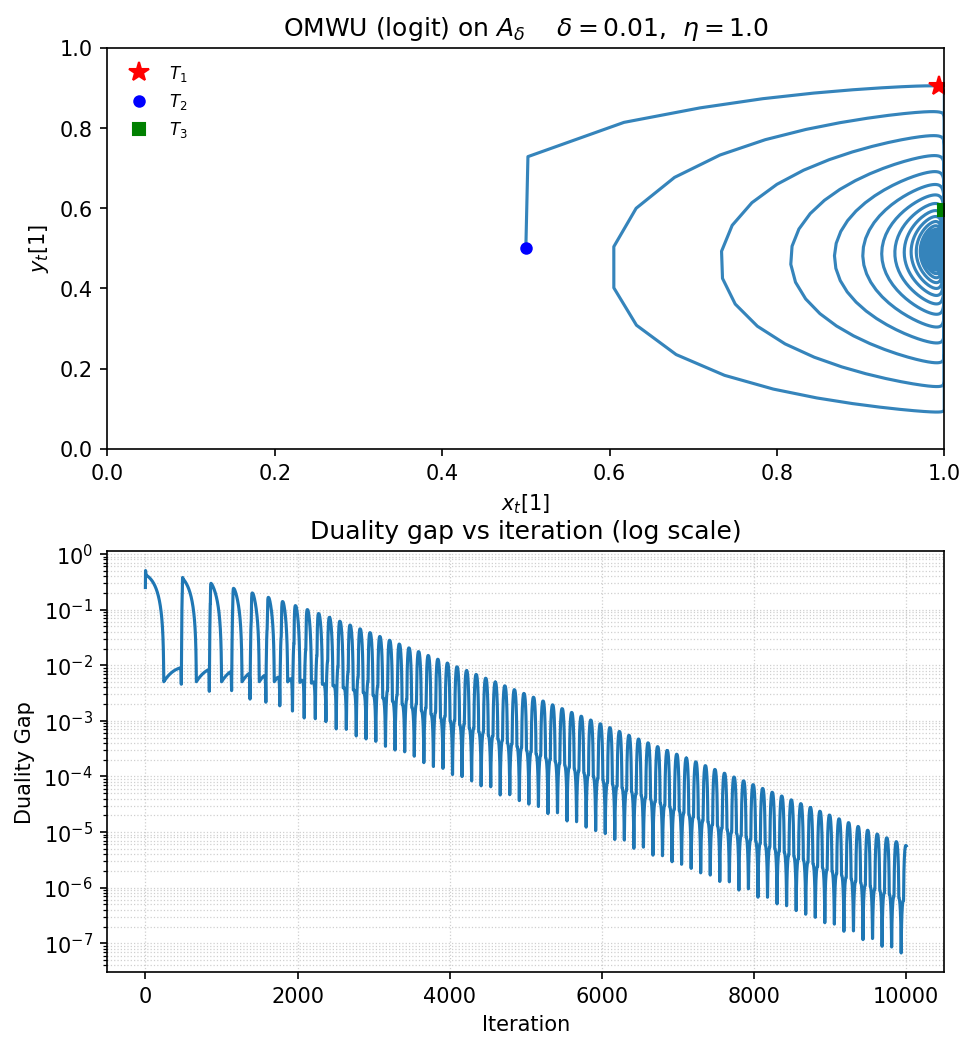

[OMWU] Saved: ./omwu_figs_logit/figure1_omwu_logit_eta1.0_delta0.01_T10000_pre.png
  Record mode: pre
  T1 (x>=1/(1+δ)) = 14  (thr 0.99009901)
  T2 (y>=1/(2(1+δ))) = 1  (thr 0.4950495)
  T3 (proof-based) = 202
  x range ≈ [0.5, 1.0]
  y range ≈ [0.091590305, 0.90581638]


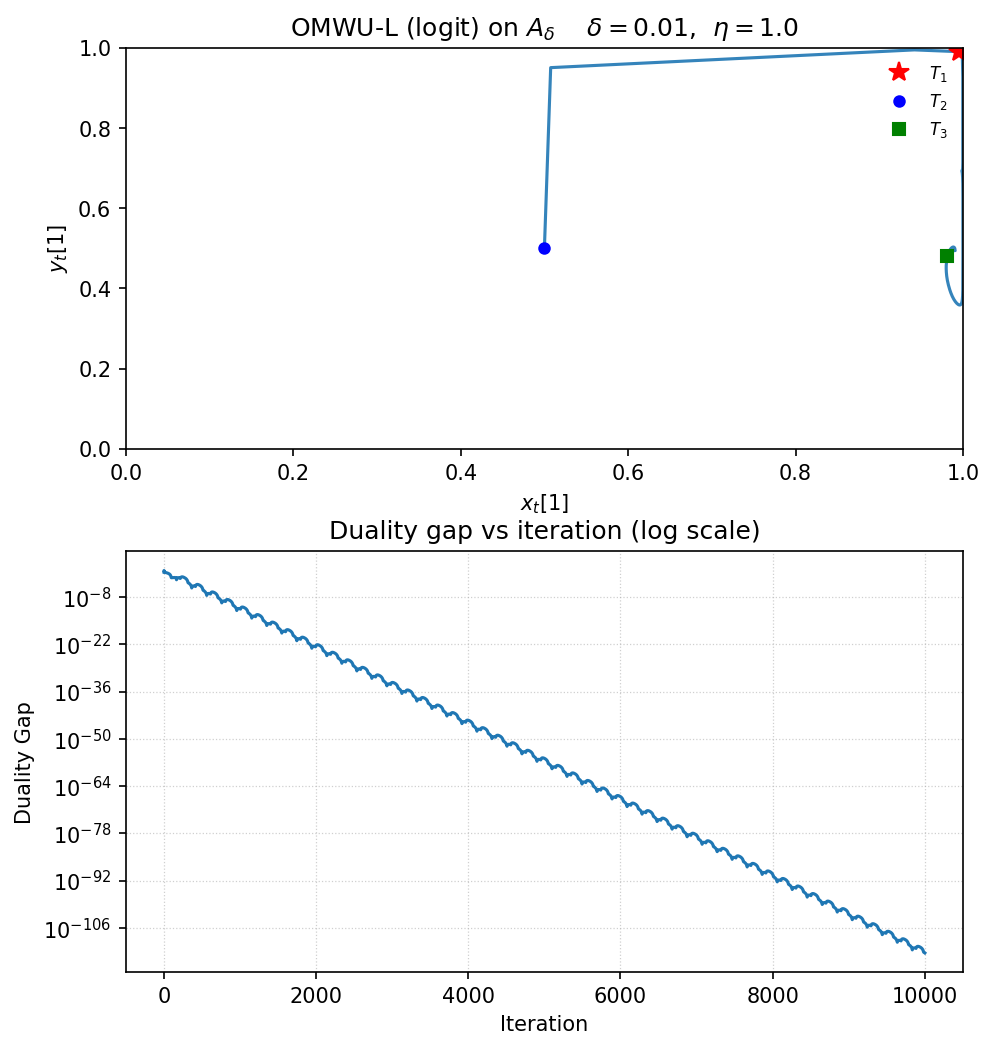

[OMWU-L] Saved: ./omwu_figs_logit/figure1_omwu_l_logit_eta1.0_delta0.01_T10000_pre.png
  Record mode: pre
  T1 (x>=1/(1+δ)) = 4  (thr 0.99009901)
  T2 (y>=1/(2(1+δ))) = 1  (thr 0.4950495)
  T3 (proof-based) = 202
  x range ≈ [0.5, 0.9999968]
  y range ≈ [0.35879266, 0.99550173]


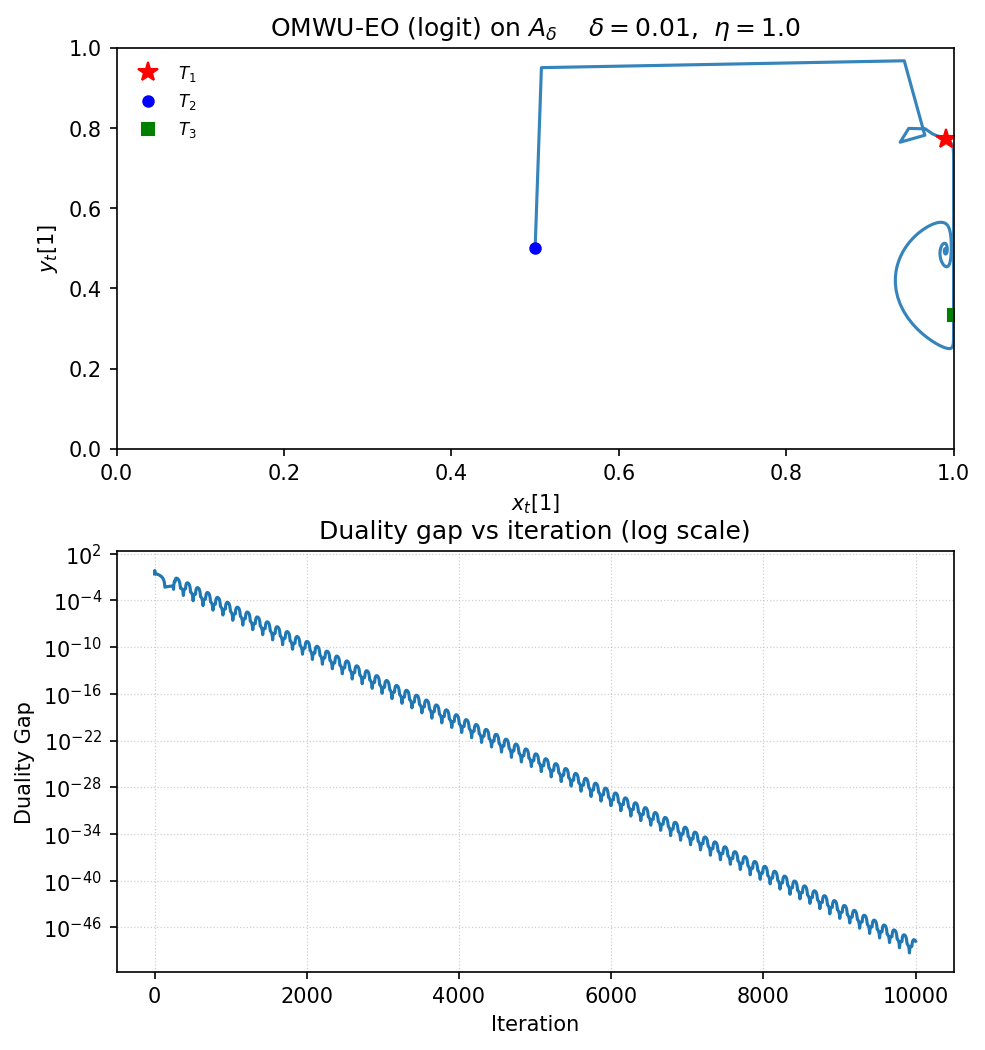

[OMWU-EO] Saved: ./omwu_figs_logit/figure1_omwu_eo_logit_eta1.0_delta0.01_T10000_pre.png
  Record mode: pre
  T1 (x>=1/(1+δ)) = 12  (thr 0.99009901)
  T2 (y>=1/(2(1+δ))) = 1  (thr 0.4950495)
  T3 (proof-based) = 202
  x range ≈ [0.5, 1.0]
  y range ≈ [0.24993973, 0.96831007]


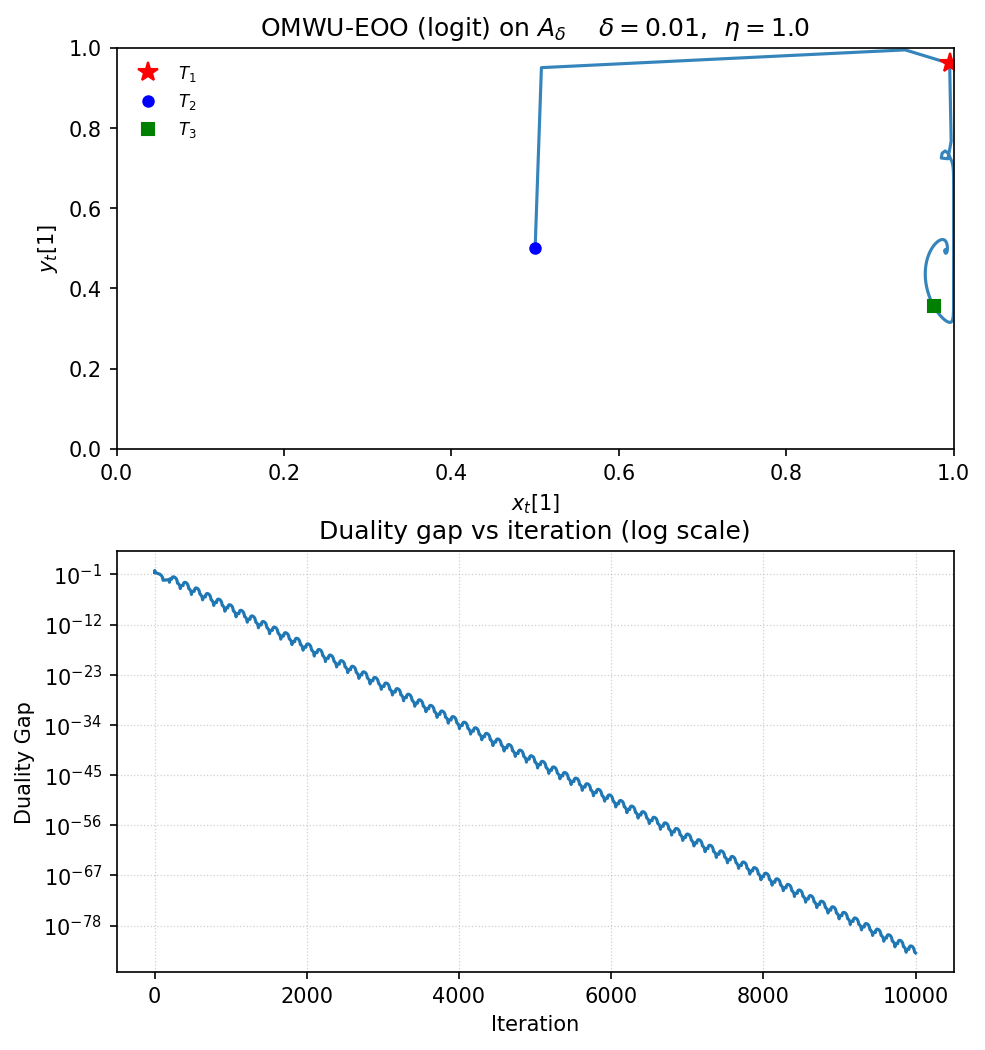

[OMWU-EOO] Saved: ./omwu_figs_logit/figure1_omwu_eoo_logit_eta1.0_delta0.01_T10000_pre.png
  Record mode: pre
  T1 (x>=1/(1+δ)) = 4  (thr 0.99009901)
  T2 (y>=1/(2(1+δ))) = 1  (thr 0.4950495)
  T3 (proof-based) = 202
  x range ≈ [0.5, 0.9999997]
  y range ≈ [0.31537737, 0.99550173]


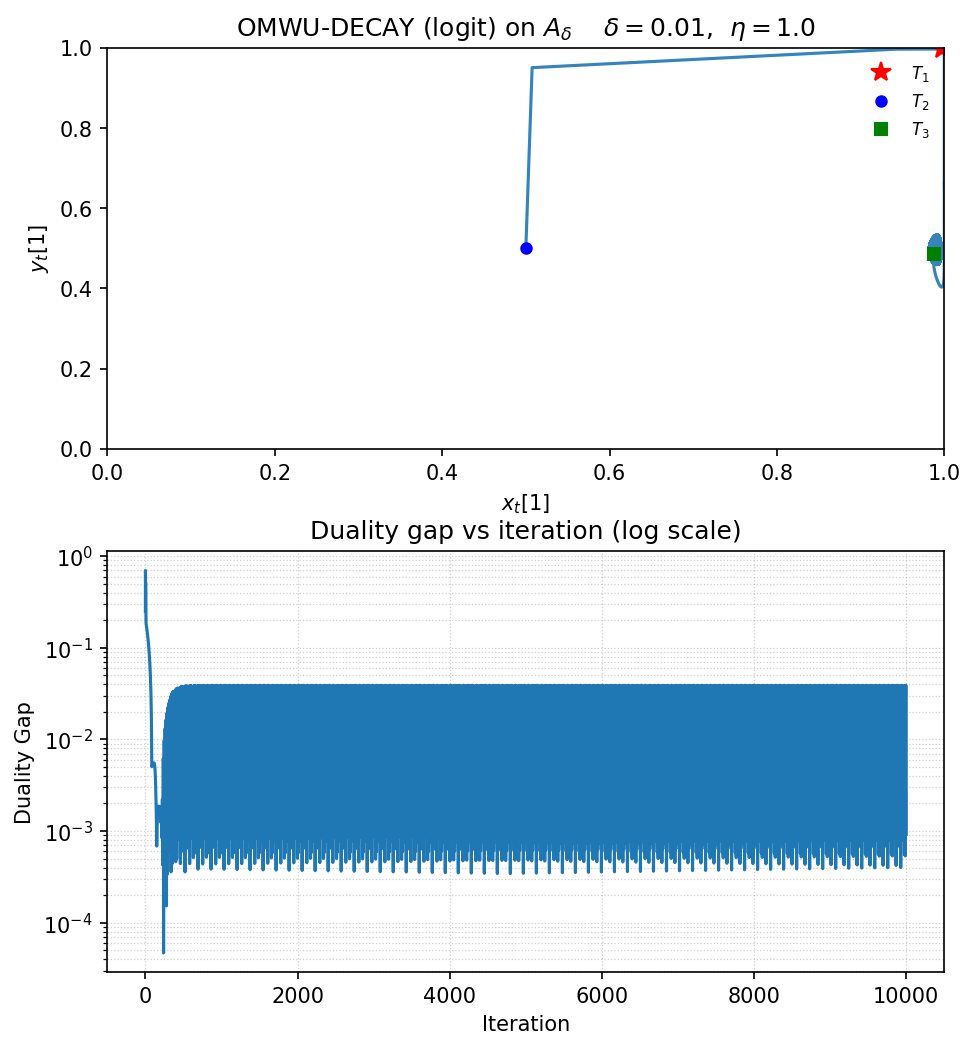

[OMWU-DECAY] Saved: ./omwu_figs_logit/figure1_omwu_decay_logit_eta1.0_delta0.01_T10000_pre.png
  Record mode: pre
  T1 (x>=1/(1+δ)) = 4  (thr 0.99009901)
  T2 (y>=1/(2(1+δ))) = 1  (thr 0.4950495)
  T3 (proof-based) = 202
  x range ≈ [0.5, 0.99999982]
  y range ≈ [0.4034147, 0.99794171]


In [6]:
# ============================================================
# Figure 1 replication (OMWU) + Variants using LOGIT UPDATES
# Colab-friendly single cell.
#
# Game: A_delta = [[1/2 + δ, 1/2],
#                  [0       , 1  ]]
# Precision: mpmath high-precision (default 1000 digits).
# Policies: x = softmax(b_row), y = softmax(b_col).
# Gradients: g_row = A @ y, g_col = -(A.T @ x).
# Update: b_{t+1} = b_t + eta * d_t  (per variant).
#
# Variants (per player):
#   OMWU:       d_t = 2 g_t - g_{t-1}
#   OMWU-L:     d_t = (L+1) g_t - sum_{i=1..L} g_{t-i}
#   OMWU-EO:    d_t = (L+1) g_t - L g_{t-1}
#   OMWU-EOO:   d_t = (L+1) g_t - g_{t-1} - pending_t
#               pending_{t+1} = (L-1) g_{t-1}
#   OMWU-DECAY: d_t = alpha_b g_t - (alpha_b-1) g_{t-1}
#                      + sum_{j=0..K_f-1} alpha_s * rho^j * (g_{t-j} - g_{t-j-1})
#               (rho default 1.0; if rho=1 -> (alpha_b+alpha_s)g_t - (alpha_b-1)g_{t-1} - alpha_s g_{t-K_f})
#
# Outputs per variant: two-panel figure
#   (top) trajectory (x[0] vs y[0]) with T1(red★), T2(blue●), T3(green■),
#   (bottom) duality gap vs iteration (log-y),
#   saved in CONFIG["save_dir"], and also displayed inline if show_figs=True.
# ============================================================

import os
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
from mpmath import mp

# ---------------------------
# CONFIG (edit here in Colab)
# ---------------------------
CONFIG: Dict = {
    # Which variants to run (choose any subset, order respected)
    # Choices: "omwu", "omwu_l", "omwu_eo", "omwu_eoo", "omwu_decay"
    "variants": ["omwu", "omwu_l", "omwu_eo", "omwu_eoo", "omwu_decay"],

    # Core experiment knobs
    "eta": 1.0,          # stepsize η
    "delta": 1e-2,       # game param δ
    "T": 10000,          # total updates
    "precision": 1000,   # decimal digits (mpmath)
    "rho": 1.0,          # DECAY base (ρ), default 1.0

    # Plot / output
    "save_dir": "./omwu_figs_logit",
    "show_figs": True,
    "add_markers": True,
    "dpi": 150,
    # Record mode: 'pre' logs (x_t,y_t) BEFORE applying the update at round t (starts at 0.5,0.5).
    #              'post' logs the policy AFTER the update at round t.
    "record_mode": "pre",

    # Variant-specific defaults
    "L": 5,                      # L for OMWU-L, EO, EOO
    # DECAY knobs
    "alpha_b": 1.0,
    "alpha_s": 5.0,
    "K_f": 5,
}

# =============== Numerics & helpers ===============
def setup_precision(dps: int):
    mp.dps = int(dps)

def softmax(v: List[mp.mpf]) -> List[mp.mpf]:
    # Stable softmax (mpmath): subtract max, exponentiate, normalize
    m = max(v)
    exps = [mp.e**(vi - m) for vi in v]
    Z = mp.fsum(exps)
    if Z == 0:
        # should not happen with mp, but guard anyway
        return [mp.mpf('1') / len(v) for _ in v]
    return [ei / Z for ei in exps]

def matvec(A: List[List[mp.mpf]], v: List[mp.mpf]) -> List[mp.mpf]:
    # 2x2 × 2 vector
    return [A[0][0]*v[0] + A[0][1]*v[1],
            A[1][0]*v[0] + A[1][1]*v[1]]

def duality_gap(A: List[List[mp.mpf]], x: List[mp.mpf], y: List[mp.mpf]) -> mp.mpf:
    # gap(x,y) = max_j (A^T x)_j - min_i (A y)_i
    # compute A^T x and A y explicitly (2x2)
    ATx = [A[0][0]*x[0] + A[1][0]*x[1],   # column 1 of A^T dot x
           A[0][1]*x[0] + A[1][1]*x[1]]  # column 2 of A^T dot x
    Ay  = matvec(A, y)
    return max(ATx[0], ATx[1]) - min(Ay[0], Ay[1])

def v_add(a: List[mp.mpf], b: List[mp.mpf]) -> List[mp.mpf]:
    return [ai + bi for ai, bi in zip(a, b)]

def v_sub(a: List[mp.mpf], b: List[mp.mpf]) -> List[mp.mpf]:
    return [ai - bi for ai, bi in zip(a, b)]

def v_scale(c: mp.mpf, a: List[mp.mpf]) -> List[mp.mpf]:
    return [c * ai for ai in a]

def v_zero(n: int) -> List[mp.mpf]:
    return [mp.mpf('0') for _ in range(n)]

# =============== Variant direction providers ===============
class DirProviderBase:
    """Base for per-player direction provider (uses grad history)."""
    def __init__(self, n_actions: int):
        self.n = n_actions
        self.t = 0
    def reset(self):
        self.t = 0
    def dir(self, g_t: List[mp.mpf], get_g):
        """Return d_t given current g_t and access to past grads via get_g(k)."""
        raise NotImplementedError

class DirOMWU(DirProviderBase):
    # d_t = 2 g_t - g_{t-1}
    def dir(self, g_t, get_g):
        g_tm1 = get_g(1)
        return v_sub(v_scale(mp.mpf('2'), g_t), g_tm1)

class DirOMWUL(DirProviderBase):
    # d_t = (L+1) g_t - sum_{i=1..L} g_{t-i}
    def __init__(self, n_actions, L: int):
        super().__init__(n_actions)
        self.L = int(L)
    def dir(self, g_t, get_g):
        s = v_zero(self.n)
        for i in range(1, self.L+1):
            gi = get_g(i)
            s = v_add(s, gi)
        return v_sub(v_scale(mp.mpf(str(self.L+1)), g_t), s)

class DirOMWUEO(DirProviderBase):
    # d_t = (L+1) g_t - L g_{t-1}
    def __init__(self, n_actions, L: int):
        super().__init__(n_actions)
        self.L = int(L)
    def dir(self, g_t, get_g):
        g_tm1 = get_g(1)
        return v_sub(v_scale(mp.mpf(str(self.L+1)), g_t), v_scale(mp.mpf(str(self.L)), g_tm1))

class DirOMWUEOO(DirProviderBase):
    # d_t = (L+1) g_t - g_{t-1} - pending_t
    # pending_{t+1} = (L-1) g_{t-1}
    def __init__(self, n_actions, L: int):
        super().__init__(n_actions)
        self.L = int(L)
        self.pending = v_zero(n_actions)
    def reset(self):
        super().reset()
        self.pending = v_zero(self.n)
    def dir(self, g_t, get_g):
        g_tm1 = get_g(1)
        d = v_sub(v_sub(v_scale(mp.mpf(str(self.L+1)), g_t), g_tm1), self.pending)
        # update pending_{t+1} for next call (uses g_{t-1})
        self.pending = v_scale(mp.mpf(str(max(self.L-1, 0))), g_tm1)
        return d

class DirDECAY(DirProviderBase):
    # d_t = alpha_b g_t - (alpha_b-1) g_{t-1} + sum_{j=0..K_f-1} alpha_s * rho^j * (g_{t-j} - g_{t-j-1})
    # If rho=1: d_t = (alpha_b+alpha_s) g_t - (alpha_b-1) g_{t-1} - alpha_s g_{t-K_f}
    def __init__(self, n_actions, alpha_b: float, alpha_s: float, K_f: int, rho: float = 1.0):
        super().__init__(n_actions)
        self.alpha_b = mp.mpf(str(alpha_b))
        self.alpha_s = mp.mpf(str(alpha_s))
        self.K_f = int(K_f)
        self.rho = mp.mpf(str(rho))
    def dir(self, g_t, get_g):
        # first two terms
        term = v_sub(v_scale(self.alpha_b, g_t), v_scale(self.alpha_b - mp.mpf('1'), get_g(1)))
        # sum over j
        if self.K_f > 0:
            for j in range(0, self.K_f):
                g_tj   = get_g(j)      # g_{t-j}
                g_tj1  = get_g(j+1)    # g_{t-j-1}
                inc = v_scale(self.alpha_s * (self.rho ** j), v_sub(g_tj, g_tj1))
                term = v_add(term, inc)
        return term

# =============== Variant wrapper (both players) ===============
@dataclass
class Variant:
    name: str
    row_dir: DirProviderBase
    col_dir: DirProviderBase

def make_variant(name: str, n_actions: int, cfg: Dict) -> Variant:
    L = int(cfg["L"])
    rho = mp.mpf(str(cfg["rho"]))
    if name.lower() == "omwu":
        return Variant("OMWU", DirOMWU(n_actions), DirOMWU(n_actions))
    elif name.lower() == "omwu_l":
        return Variant("OMWU-L", DirOMWUL(n_actions, L), DirOMWUL(n_actions, L))
    elif name.lower() == "omwu_eo":
        return Variant("OMWU-EO", DirOMWUEO(n_actions, L), DirOMWUEO(n_actions, L))
    elif name.lower() == "omwu_eoo":
        return Variant("OMWU-EOO", DirOMWUEOO(n_actions, L), DirOMWUEOO(n_actions, L))
    elif name.lower() == "omwu_decay":
        return Variant("OMWU-DECAY",
                       DirDECAY(n_actions, cfg["alpha_b"], cfg["alpha_s"], cfg["K_f"], cfg["rho"]),
                       DirDECAY(n_actions, cfg["alpha_b"], cfg["alpha_s"], cfg["K_f"], cfg["rho"]))
    else:
        raise ValueError(f"Unknown variant '{name}'")

# =============== Experiment core (logit dynamics) ===============
def run_variant_logit(cfg: Dict, variant: Variant):
    os.makedirs(cfg["save_dir"], exist_ok=True)
    setup_precision(cfg["precision"])

    # Game A_delta
    delta = mp.mpf(str(cfg["delta"]))
    half  = mp.mpf('0.5')
    A = [[half + delta, half],
         [mp.mpf('0'),  mp.mpf('1')]]

    # Settings
    eta = mp.mpf(str(cfg["eta"]))
    T   = int(cfg["T"])

    n_actions = 2
    # Initialize logits & policies (uniform)
    b_row = [mp.mpf('0')] * n_actions
    b_col = [mp.mpf('0')] * n_actions
    x = softmax(b_row)
    y = softmax(b_col)

    # Per-player gradient history (list of past g_t vectors).
    # We index so that history[0] is g_1, history[-1] is last g observed.
    g_hist_row: List[List[mp.mpf]] = []
    g_hist_col: List[List[mp.mpf]] = []

    # Helpers to fetch g_{t-k} with zero-fill if missing
    def make_get_g(hist: List[List[mp.mpf]]):
        def _get(k: int) -> List[mp.mpf]:
            # k>=0: return g_{t-k}; k=0 means current g_t.
            # At call time, we have *not* yet appended g_t to hist,
            # so current g_t is provided by argument, not from hist.
            if k <= 0:
                # We'll never call with k<=0 except k=0 handled separately in dir()
                return v_zero(n_actions)
            idx = len(hist) - k  # g_{t-k} lives here after we've appended g_t
            if idx < 0:
                return v_zero(n_actions)
            return hist[idx]
        return _get

    # Variant state reset
    variant.row_dir.reset()
    variant.col_dir.reset()

    # Storage for plotting (policies and gap)
    xs: List[float] = []
    ys: List[float] = []
    gaps_f: List[float] = []

    record_mode = cfg.get("record_mode", "pre")

    for t in range(1, T+1):
        # 1) (optional) record pre-update policy
        if record_mode == "pre":
            xs.append(float(x[0])); ys.append(float(y[0]))
            gap = duality_gap(A, x, y)
            gaps_f.append(float(gap) if gap > mp.mpf('1e-300') else 1e-300)

        # 2) compute gradients at current policy
        g_row = matvec(A, y)               # A y_t
        g_col = v_scale(mp.mpf('-1'),      # -A^T x_t
                        [A[0][0]*x[0] + A[1][0]*x[1],
                         A[0][1]*x[0] + A[1][1]*x[1]])

        # 3) directions using variant rules and history accessors
        get_g_row = make_get_g(g_hist_row)
        get_g_col = make_get_g(g_hist_col)

        # For formulas that need g_{t-j} inside the sum with j=0, we pass g_t directly.
        # Implement by temporarily appending g_t to a local view when building d_t.
        # (Cleaner: extend get_g to handle k=0 via captured g_t.)
        def dir_with_current(provider: DirProviderBase, g_t_vec, get_g_hist):
            # Wrap get_g so that k=0 returns g_t
            def _get(k: int):
                if k == 0:
                    return g_t_vec
                return get_g_hist(k)
            return provider.dir(g_t_vec, _get)

        d_row = dir_with_current(variant.row_dir, g_row, get_g_row)
        d_col = dir_with_current(variant.col_dir, g_col, get_g_col)

        # 4) logit updates
        b_row = v_add(b_row, v_scale(eta, d_row))
        b_col = v_add(b_col, v_scale(eta, d_col))
        x = softmax(b_row)
        y = softmax(b_col)

        # 5) push current gradients to history (now g_t becomes "past")
        g_hist_row.append(g_row)
        g_hist_col.append(g_col)

        # 6) (optional) record post-update policy
        if record_mode == "post":
            xs.append(float(x[0])); ys.append(float(y[0]))
            gap = duality_gap(A, x, y)
            gaps_f.append(float(gap) if gap > mp.mpf('1e-300') else 1e-300)

    # ----- markers (proof-based) -----
    T_series = len(xs)  # number of recorded points
    one = mp.mpf('1')
    thr_x = one / (one + delta)          # x[0] >= 1/(1+δ)
    thr_y = one / (2 * (one + delta))    # y[0] >= 1/(2(1+δ))

    # Recover mp policies for markers from floats (safe here)
    xs_mp = [mp.mpf(str(v)) for v in xs]
    ys_mp = [mp.mpf(str(v)) for v in ys]

    T1 = next((i+1 for i in range(T_series) if xs_mp[i] >= thr_x), None)
    T2 = next((i+1 for i in range(T_series) if ys_mp[i] >= thr_y), None)

    L_lip = mp.mpf('0.5')  # neg-entropy Lipschitz constant used in the proof
    T3 = None
    if T2 is not None:
        offset = int(mp.ceil(1 / (eta * L_lip * delta)))  # ceil(2/(eta*delta))
        cand = T2 + offset
        if cand <= T_series:
            T3 = cand

    # ----- plot -----
    fig = plt.figure(figsize=(7.2, 8.0), dpi=cfg["dpi"])
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.05], hspace=0.25)

    # top: (x[0], y[0]) trajectory
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(xs, ys, lw=1.5, alpha=0.9)
    ax1.set_xlim(0.0, 1.0); ax1.set_ylim(0.0, 1.0)
    ax1.set_xlabel(r"$x_t[1]$")
    ax1.set_ylabel(r"$y_t[1]$")
    ax1.set_title(f"{variant.name} (logit) on $A_\\delta$    $\\delta={cfg['delta']}$,  $\\eta={cfg['eta']}$")

    if cfg["add_markers"]:
        if T1 is not None:
            ax1.plot(xs[T1-1], ys[T1-1], 'r*', markersize=10, label=r"$T_1$")
        if T2 is not None:
            ax1.plot(xs[T2-1], ys[T2-1], 'bo', markersize=5, label=r"$T_2$")
        if T3 is not None:
            ax1.plot(xs[T3-1], ys[T3-1], 'gs', markersize=6, label=r"$T_3$")
        if any(v is not None for v in (T1, T2, T3)):
            ax1.legend(loc="best", fontsize=8, frameon=False)

    # bottom: duality gap (semilogy)
    ax2 = fig.add_subplot(gs[1, 0])
    its = list(range(1, len(gaps_f)+1))
    ax2.semilogy(its, gaps_f, lw=1.5)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Duality Gap")
    ax2.set_title("Duality gap vs iteration (log scale)")
    ax2.grid(True, which="both", ls=":", lw=0.6, alpha=0.6)

    plt.tight_layout()

    # save + show
    os.makedirs(cfg["save_dir"], exist_ok=True)
    safe = variant.name.lower().replace('-', '_')
    out_path = os.path.join(cfg["save_dir"],
                            f"figure1_{safe}_logit_eta{cfg['eta']}_delta{cfg['delta']}_T{cfg['T']}_{cfg['record_mode']}.png")
    plt.savefig(out_path, bbox_inches="tight", dpi=cfg["dpi"])
    if cfg["show_figs"]:
        plt.show()
    plt.close(fig)

    # summary
    print(f"[{variant.name}] Saved: {out_path}")
    print(f"  Record mode: {cfg['record_mode']}")
    print(f"  T1 (x>=1/(1+δ)) = {T1}  (thr {mp.nstr(thr_x, 8)})")
    print(f"  T2 (y>=1/(2(1+δ))) = {T2}  (thr {mp.nstr(thr_y, 8)})")
    print(f"  T3 (proof-based) = {T3}")
    print(f"  x range ≈ [{mp.nstr(min(xs_mp), 8)}, {mp.nstr(max(xs_mp), 8)}]")
    print(f"  y range ≈ [{mp.nstr(min(ys_mp), 8)}, {mp.nstr(max(ys_mp), 8)}]")

# =============== Batch runner ===============
def run_all(cfg: Dict):
    n_actions = 2  # game is 2x2
    for vname in cfg["variants"]:
        variant = make_variant(vname, n_actions, cfg)
        run_variant_logit(cfg, variant)

# Kick off (works in Colab directly; no argparse needed)
run_all(CONFIG)


In [1]:
########################################

Streaming output truncated to the last 5000 lines.
[OMWU-DECAY(αb=1.0,αs=2.0,Kf=3,ρ=1.0,uniform)] t= 53500  exploit=2.883698e-05  nashconv=5.767396e-05  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU-AVG(H=3)               ] t= 53500  exploit=2.956696e-05  nashconv=5.913391e-05  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU                        ] t= 54000  exploit=3.196239e-04  nashconv=6.392479e-04  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU-EO(α=4.0)              ] t= 54000  exploit=8.998422e-06  nashconv=1.799684e-05  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU-EOO(L=4)               ] t= 54000  exploit=1.442219e-09  nashconv=2.884438e-09  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU-L(L=4)                 ] t= 54000  exploit=2.177870e-08  nashconv=4.355740e-08  ηrow=3.00e-01 ηcol=3.00e-01
[OMWU-DECAY(αb=1.0,αs=2.0,Kf=3,ρ=1.0,uniform)] t= 54000  exploit=7.932981e-05  nashconv=1.586596e-04  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU-AVG(H=3)               ] t= 54000  exploit=7.964637e-05  nashconv=1.592927e-04  ηrow=4.00e-01 ηcol=4.00e-01
[OMWU

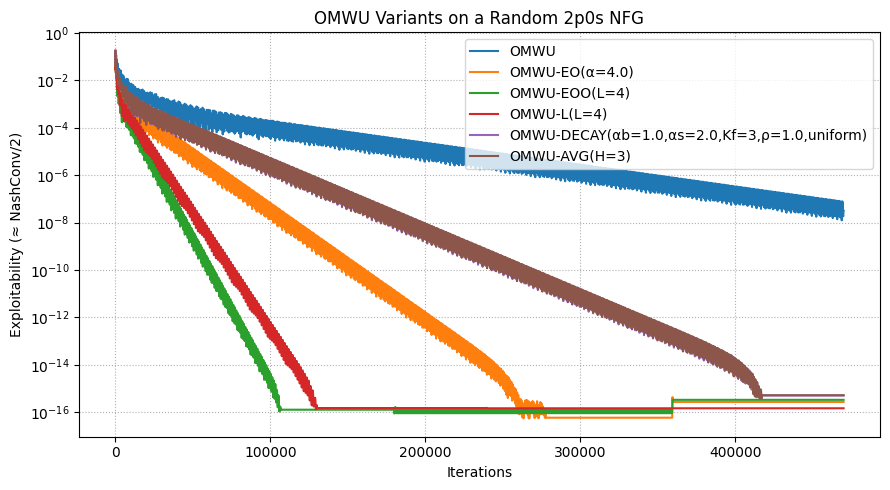

In [8]:
#@title OMWU Variants on Random 2p0s NFGs (normal-form games)
#@markdown - **ALGOS** lists only names; **VARIANT_CFG** holds hyperparameters.
#@markdown - Includes OMWU, OMWU-EO, OMWU-EOO, OMWU-L, OMWU-DECAY, and **OMWU-AVG(H)** (prediction = avg of last H gradients).
#@markdown - Runs all variants concurrently on the same random zero-sum NFG and plots exploitability (≈ NashConv/2).

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

# ======================= VARIANTS & CONFIG (edit here) =======================
ALGOS = ["OMWU", "OMWU-EO", "OMWU-EOO", "OMWU-L", "OMWU-DECAY", "OMWU-AVG"]  # names only

VARIANT_CFG: Dict[str, Dict] = {
    "OMWU":       {"eta": 0.40},
    "OMWU-EO":    {"eta": 0.40, "alpha": 4.0},       # or use "L": 3 instead of "alpha"
    "OMWU-EOO":   {"eta": 0.40, "L": 4},
    "OMWU-L":     {"eta": 0.30, "L": 4},
    "OMWU-DECAY": {"eta": 0.40, "alpha_b": 1.0, "alpha_s": 2.0, "rho": 1.0, "Kf": 3,
                   "scheme": "uniform", "normalize": True},
    "OMWU-AVG":   {"eta": 0.40, "H": 3},             # NEW: average of last H gradients
}

# ============================= numerics helpers =============================
def get_dtype(precision: str):
    if precision not in {"normal","precise"}:
        raise ValueError("precision must be 'normal' or 'precise'")
    return np.float64 if precision == "normal" else np.longdouble

def softmax(v: np.ndarray) -> np.ndarray:
    z = v - np.max(v)
    e = np.exp(z)
    return e / np.sum(e)

# =============================== NFG definition ===============================
@dataclass
class NFG:
    A: np.ndarray  # row player's payoff matrix (m x n), col payoff is -A

def random_nfg(m: int, n: int, dist: str="uniform", scale: float=1.0, seed: int=0, dtype=np.float64) -> NFG:
    rng = np.random.default_rng(seed)
    if dist == "uniform":
        A = rng.uniform(-scale, scale, size=(m, n)).astype(dtype)
    elif dist == "normal":
        A = (rng.standard_normal(size=(m, n)) * (scale / np.sqrt(2))).astype(dtype)
    else:
        raise ValueError("dist must be 'uniform' or 'normal'")
    return NFG(A=A)

def gradients(nfg: NFG, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    g_row = A @ y;  g_col = -A.T @ x
    """
    g0 = nfg.A @ y
    g1 = -(nfg.A.T @ x)
    return g0, g1

def nashconv_and_exploit(nfg: NFG, x: np.ndarray, y: np.ndarray) -> Tuple[float,float,float]:
    """
    NashConv = (max_i (A y)_i - x^T A y) + ((-min_j (x^T A)_j) - (-x^T A y))
             = max_i (A y)_i - min_j (x^T A)_j
    exploitability ≈ NashConv/2 in zero-sum.
    Returns (NashConv, Exploitability, EV_row).
    """
    Ay = nfg.A @ y
    xTA = (x @ nfg.A)
    v   = float(x @ Ay)                 # x^T A y
    best_row = float(np.max(Ay))
    best_col = float(np.min(xTA))
    nconv = best_row - best_col
    exploit = 0.5 * max(nconv, 0.0)
    return nconv, exploit, v

# =============================== Base solver ===============================
class MwuBase:
    """
    Entropic mirror map on the simplex with logit vector b; x = softmax(b).
    Subclasses implement _direction(g_t).
    """
    def __init__(self, n_actions: int, eta: float=0.4, dtype=np.float64):
        self.n = int(n_actions)
        self.eta = float(eta)
        self.dtype = dtype
        self.b = np.zeros(self.n, dtype=self.dtype)
        self.x = np.full(self.n, 1.0 / self.n, dtype=self.dtype)  # softmax(b) initially uniform
        self.last_gradient = np.zeros(self.n, dtype=self.dtype)
        self._hist: List[np.ndarray] = []  # most-recent first
        # diagnostics
        self.sum_gradients = np.zeros(self.n, dtype=self.dtype)
        self.sum_ev = self.dtype(0.0)

    def strategy(self) -> np.ndarray:
        return self.x

    def observe_gradient(self, g_t: np.ndarray):
        g_t = np.asarray(g_t, dtype=self.dtype)
        # regret diagnostics
        self.sum_gradients += g_t
        self.sum_ev += float(g_t @ self.x)
        # update logits
        d_t = self._direction(g_t)
        self.b += self.dtype(self.eta) * d_t
        self.x = softmax(self.b)
        # history
        self._hist.insert(0, g_t.copy())
        if len(self._hist) > 512: self._hist.pop()
        self.last_gradient = g_t

    def _get_hist(self, k: int, default_zero: Optional[np.ndarray]=None) -> np.ndarray:
        if k < len(self._hist): return self._hist[k]
        if default_zero is None:
            return np.zeros(self.n, dtype=self.dtype)
        return default_zero

    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        raise NotImplementedError

# ============================= Concrete variants =============================
class OMWU(MwuBase):
    # d_t = 2 g_t - g_{t-1}
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        return self.dtype(2.0) * g_t - self.last_gradient

class OMWU_EO(MwuBase):
    """
    Extra optimism:
      α-form: d_t = α g_t - (α-1) g_{t-1}
      L-form: d_t = (L+1) g_t - L g_{t-1}
    """
    def __init__(self, n_actions, eta=0.4, L: Optional[int]=None, alpha: Optional[float]=None, dtype=np.float64):
        super().__init__(n_actions, eta, dtype)
        self.L = None if L is None else int(L)
        self.alpha = None if alpha is None else float(alpha)
        if self.L is None and self.alpha is None:
            self.alpha = 2.0
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self.last_gradient
        if self.L is not None:
            return self.dtype(self.L+1) * g_t - self.dtype(self.L) * g_tm1
        a = self.dtype(self.alpha)
        return a * g_t - (a - self.dtype(1.0)) * g_tm1

class OMWU_EOO(MwuBase):
    """
    Staggered EO:
      d_t = (L+1) g_t - g_{t-1} - pending_t
      pending_{t+1} = max(L-1,0) * g_{t-1}
    """
    def __init__(self, n_actions, eta=0.4, L: int=2, dtype=np.float64):
        super().__init__(n_actions, eta, dtype)
        self.L = int(max(1, L))
        self._pending = np.zeros(self.n, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        g_tm1 = self.last_gradient
        d = self.dtype(self.L+1) * g_t - g_tm1 - self._pending
        self._pending = self.dtype(max(self.L-1,0)) * g_tm1
        return d

class OMWU_L(MwuBase):
    """
    Windowed:
      d_t = (L+1) g_t - sum_{i=1}^L g_{t-i}
    """
    def __init__(self, n_actions, eta=0.4, L: int=2, dtype=np.float64):
        super().__init__(n_actions, eta, dtype)
        self.L = int(max(1, L))
        self._sum_hist = np.zeros(self.n, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.dtype(self.L+1) * g_t - self._sum_hist
        self._sum_hist += g_t
        if len(self._hist) >= self.L:
            self._sum_hist -= self._hist[self.L-1]
        return d

class OMWU_DECAY(MwuBase):
    """
    DECAY (finite-tap increments):
      d_t = α_b g_t + α_s ∑_{j=0}^{Kf-1} w_j (g_{t-j} - g_{t-j-1})
    weights: uniform (default) or geometric ("geom" with rho in [0,1)).
    """
    def __init__(self, n_actions, eta=0.4, alpha_b=1.0, alpha_s=2.0, Kf=2, rho=1.0,
                 scheme="uniform", normalize=True, dtype=np.float64):
        super().__init__(n_actions, eta, dtype)
        self.alpha_b = self.dtype(alpha_b)
        self.alpha_s = self.dtype(alpha_s)
        self.Kf = int(max(0, Kf))
        self.rho = float(rho)
        self.scheme = scheme
        self.normalize = bool(normalize)
        self._build_weights()
    def _build_weights(self):
        if self.Kf <= 0:
            self._w = np.zeros(0, dtype=self.dtype); return
        if self.scheme == "geom" and 0.0 <= self.rho < 1.0:
            w = np.array([(1.0 - self.rho) * (self.rho ** j) for j in range(self.Kf)], dtype=float)
            if self.normalize:
                s = w.sum()
                if s > 0: w = w / s
        else:
            w = np.ones(self.Kf, dtype=float) / float(self.Kf)
        self._w = np.asarray(w, dtype=self.dtype)
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        d = self.alpha_b * g_t
        if self.Kf > 0:
            zeros = np.zeros_like(g_t)
            inc = np.zeros_like(g_t)
            for j in range(self.Kf):
                g_t_j   = g_t if j == 0 else self._get_hist(j-1, zeros)
                g_t_jm1 = self._get_hist(j, zeros)
                inc += self._w[j] * (g_t_j - g_t_jm1)
            d = d + self.alpha_s * inc
        return d

class OMWU_AVG(MwuBase):
    """
    NEW: Average-prediction variant
      m_t = (1/H) * sum_{i=1..H} g_{t-i}  (use available history when t<=H)
      d_t = 2 g_t - m_t
    """
    def __init__(self, n_actions, eta=0.4, H: int=5, dtype=np.float64):
        super().__init__(n_actions, eta, dtype)
        self.H = int(max(1, H))
    def _direction(self, g_t: np.ndarray) -> np.ndarray:
        H = min(self.H, len(self._hist))
        if H == 0:
            m_t = np.zeros_like(g_t)
        else:
            # average last H gradients (self._hist[0] is g_{t-1})
            m_t = np.mean(np.stack(self._hist[:H], axis=0), axis=0)
        return self.dtype(2.0) * g_t - m_t

# =============================== Factory ===============================
def make_solver(variant_name: str, cfg: Dict, n_actions: int, dtype):
    v = variant_name.strip().upper()
    eta = float(cfg.get("eta", 0.4))
    if v == "OMWU":
        return f"OMWU", OMWU(n_actions, eta=eta, dtype=dtype)
    if v in {"OMWU-EO","EO"}:
        alpha = cfg.get("alpha", None)
        L = cfg.get("L", None)
        if alpha is not None:
            return f"OMWU-EO(α={alpha})", OMWU_EO(n_actions, eta=eta, alpha=float(alpha), L=None, dtype=dtype)
        L = int(L if L is not None else 2)
        return f"OMWU-EO(L={L})", OMWU_EO(n_actions, eta=eta, L=L, alpha=None, dtype=dtype)
    if v in {"OMWU-EOO","EOO"}:
        L = int(cfg.get("L", 2))
        return f"OMWU-EOO(L={L})", OMWU_EOO(n_actions, eta=eta, L=L, dtype=dtype)
    if v in {"OMWU-L","L"}:
        L = int(cfg.get("L", 2))
        return f"OMWU-L(L={L})", OMWU_L(n_actions, eta=eta, L=L, dtype=dtype)
    if v in {"OMWU-DECAY","DECAY"}:
        ab  = float(cfg.get("alpha_b", 1.0))
        aS  = float(cfg.get("alpha_s", 2.0))
        Kf  = int(cfg.get("Kf", 2))
        rho = float(cfg.get("rho", 1.0))
        scheme = str(cfg.get("scheme", "uniform")).lower()
        normalize = bool(cfg.get("normalize", True))
        label = f"OMWU-DECAY(αb={ab},αs={aS},Kf={Kf},ρ={rho},{scheme})"
        return label, OMWU_DECAY(n_actions, eta=eta, alpha_b=ab, alpha_s=aS, Kf=Kf, rho=rho,
                                 scheme=scheme, normalize=normalize, dtype=dtype)
    if v in {"OMWU-AVG","AVG"}:
        H = int(cfg.get("H", 5))
        return f"OMWU-AVG(H={H})", OMWU_AVG(n_actions, eta=eta, H=H, dtype=dtype)
    raise ValueError(f"Unknown variant '{variant_name}'")

# =============================== Runner ===============================
def run_nfg_all_variants(
    # Game params
    m=30, n=30, dist="uniform", scale=1.0, seed=0,
    # Train / numerics
    T=20000, precision="precise", eta_global=None, print_every=500, plot_every=100
):
    DTYPE = get_dtype(precision)
    np.seterr(over='raise', divide='raise', invalid='raise', under='ignore')
    # Build one shared random NFG for all variants
    nfg = random_nfg(m=m, n=n, dist=dist, scale=scale, seed=seed, dtype=DTYPE)
    print(f"=== Random 2p0s NFG ===")
    print(f"  shape A         : {nfg.A.shape}  (row×col actions)")
    print(f"  dist/scale      : {dist}/{scale}")
    print(f"=======================\n")

    # Instantiate one row and one column solver per variant
    rng = np.random.default_rng(seed)
    bundles = []  # (label, row_solver, col_solver)
    for name in ALGOS:
        if name not in VARIANT_CFG:
            raise ValueError(f"Variant '{name}' missing in VARIANT_CFG.")
        cfg = dict(VARIANT_CFG[name])
        if eta_global is not None:
            cfg["eta"] = float(eta_global)
        label_r, row = make_solver(name, cfg, nfg.A.shape[0], DTYPE)
        label_c, col = make_solver(name, cfg, nfg.A.shape[1], DTYPE)
        assert label_r == label_c
        label = label_r
        # tiny jitter to break perfect symmetry
        row.b += np.asarray(rng.normal(0, 1e-12, size=row.b.shape), dtype=DTYPE)
        col.b += np.asarray(rng.normal(0, 1e-12, size=col.b.shape), dtype=DTYPE)
        row.x = softmax(row.b)
        col.x = softmax(col.b)
        bundles.append((label, row, col))

    curves = {label: {"times": [], "exploit": [], "nashconv": []} for (label,_,_) in bundles}

    # Train
    for t in range(1, T+1):
        for (label, row, col) in bundles:
            x = row.strategy()
            y = col.strategy()
            g0, g1 = gradients(nfg, x, y)
            row.observe_gradient(g0)
            col.observe_gradient(g1)

            if (t % plot_every) == 0 or t == 1:
                x = row.strategy(); y = col.strategy()
                nc, ex, v = nashconv_and_exploit(nfg, x, y)
                curves[label]["times"].append(t)
                curves[label]["exploit"].append(ex)
                curves[label]["nashconv"].append(nc)

            if (t % print_every) == 0 or t == 1:
                ex = curves[label]["exploit"][-1] if curves[label]["exploit"] else float('nan')
                nc = curves[label]["nashconv"][-1] if curves[label]["nashconv"] else float('nan')
                print(f"[{label:28s}] t={t:6d}  exploit={ex:.6e}  nashconv={nc:.6e}  ηrow={row.eta:.2e} ηcol={col.eta:.2e}")

    # Plot
    if curves:
        plt.figure(figsize=(9,5))
        for label, data in curves.items():
            if not data["times"]: continue
            xs = np.asarray(data["times"], dtype=float)
            ys = np.maximum(np.asarray(data["exploit"], dtype=float), 1e-18)
            plt.plot(xs, ys, label=label)
        plt.yscale("log")
        plt.xlabel("Iterations"); plt.ylabel("Exploitability (≈ NashConv/2)")
        plt.title("OMWU Variants on a Random 2p0s NFG")
        plt.grid(True, which="both", ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return curves

# ================================ Runner cell ================================
#@title Run (edit params then run)
m = 30                     #@param {type:"integer"}
n = 30                     #@param {type:"integer"}
dist = "uniform"           #@param ["uniform","normal"]
scale = 1.0                #@param {type:"number"}
seed = 10                   #@param {type:"integer"}

T = 470000                  #@param {type:"integer"}
precision = "precise"      #@param ["normal","precise"]
print_every = 500          #@param {type:"integer"}
plot_every = 100           #@param {type:"integer"}
eta_global = None          #@param {type:"raw"}  # set a float to override all variant etas at once

curves = run_nfg_all_variants(
    m=m, n=n, dist=dist, scale=scale, seed=seed,
    T=T, precision=precision, eta_global=eta_global,
    print_every=print_every, plot_every=plot_every
)


In [1]:
####################################


=== Biased RPS (ε=0.20) ===  shape=(3, 3)


/tmp/ipython-input-2351397631.py:348: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


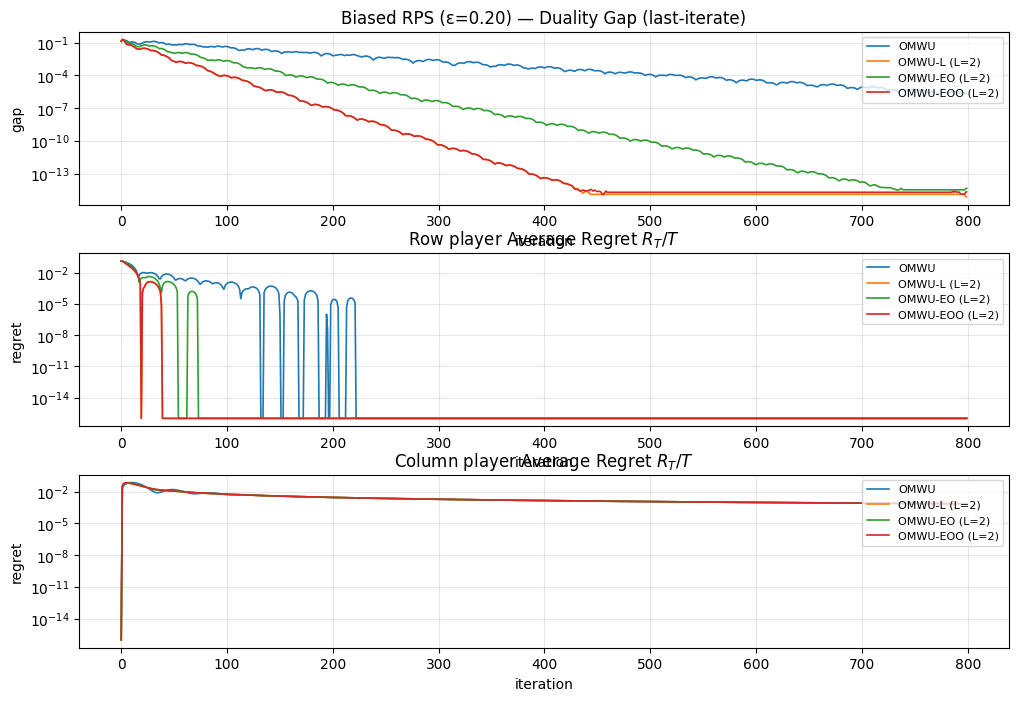

In [6]:
# omwu_variants_random_games.py
# ------------------------------------------------------------
# Two-player zero-sum normal-form games
# OMWU + variants on a battery of games, with duality gap and regret plots
# ------------------------------------------------------------
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, Dict, List, Tuple, Optional

# =========================
# Config (edit here)
# =========================
SEED = 0
T = 800                   # iterations
PRINT_EVERY = 1000         # progress printout
PLOT_TOTAL_REGRET = False  # if True: plot R_T; else plot average regret R_T/T
RUN_BATTERY = False         # if True: run all games in GAMES; else run just FIRST one

LOG_Y = True     # log scale on Y (gap + regrets)
LOG_X = False    # optional: log scale on X (iterations)

# Algorithms + hyperparameters
VARIANTS = {
    # name: dict with 'type' and parameters
    "OMWU":           {"type": "omwu",     "eta": 0.3},
    "OMWU-L (L=2)":   {"type": "omwu_l",   "eta": 0.3, "L": 2},
    "OMWU-EO (L=2)":  {"type": "omwu_eo",  "eta": 0.3, "L": 2},
    "OMWU-EOO (L=2)": {"type": "omwu_eoo", "eta": 0.3, "L": 2},
}

# Game battery (each item is (title, builder_fn))
def _G(title, fn): return (title, fn)
GAMES: List[Tuple[str, Callable[[], np.ndarray]]] = [
    # _G("RPS (3x3, standard)",                   lambda: make_rps()),
    _G("Biased RPS (ε=0.20)",                   lambda: make_biased_rps(eps=0.20)),
    _G("Matching Pennies (2x2)",                lambda: make_matching_pennies()),
    _G("Cyclic-5 (5x5, near-antisymmetric)",    lambda: make_cyclic(k=5)),
    _G("Random Gaussian 7x7 (N(0,1))",          lambda: make_random_gaussian(7,7, scale=1.0)),
    _G("Random Uniform 10x10 ([-1,1])",         lambda: make_random_uniform(10,10)),
    _G("Random Skew 8x8 (B - B^T)",             lambda: make_random_skew(8)),
    _G("Random Sparse 12x12 (p=0.15)",          lambda: make_random_sparse(12,12, density=0.15)),
]

# =========================
# Numerics helpers
# =========================
EPS = 1e-300

def softmax(logits: np.ndarray) -> np.ndarray:
    z = logits - np.max(logits)         # safe shift
    e = np.exp(z)
    s = e / np.sum(e)
    # guard against underflow to exact zeros
    return np.clip(s, EPS, 1.0)

# =========================
# Game builders (row gets A, col gets -A)
# =========================
def make_rps() -> np.ndarray:
    # Standard RPS (row payoff)
    #    R  P  S
    # R [0 -1  1]
    # P [1  0 -1]
    # S [-1 1  0]
    A = np.array([[0, -1,  1],
                  [1,  0, -1],
                  [-1, 1,  0]], dtype=float)
    return A

def make_biased_rps(eps: float=0.2) -> np.ndarray:
    A = make_rps().astype(float)
    # Add a small bias for row toward Rock: increase Rock payoff by eps uniformly
    A[0, :] += eps
    return A

def make_matching_pennies() -> np.ndarray:
    # Row wants to match, column wants to mismatch
    #      H   T
    # H [ 1, -1]
    # T [-1,  1]
    return np.array([[1, -1],
                     [-1, 1]], dtype=float)

def make_cyclic(k: int=5) -> np.ndarray:
    # k-action cyclic dominance: i beats (i-1 mod k), loses to (i+1 mod k)
    A = np.zeros((k, k), dtype=float)
    for i in range(k):
        A[i, (i-1) % k] = 1.0
        A[i, (i+1) % k] = -1.0
    return A

def make_random_gaussian(m: int, n: int, scale: float=1.0) -> np.ndarray:
    return np.random.normal(0.0, scale, size=(m, n))

def make_random_uniform(m: int, n: int) -> np.ndarray:
    return np.random.uniform(-1.0, 1.0, size=(m, n))

def make_random_skew(n: int) -> np.ndarray:
    B = np.random.normal(0.0, 1.0, size=(n, n))
    A = 0.5 * (B - B.T)  # strictly antisymmetric => zero-sum with value 0
    return A

def make_random_sparse(m: int, n: int, density: float=0.15) -> np.ndarray:
    A = np.zeros((m, n), dtype=float)
    mask = np.random.rand(m, n) < density
    A[mask] = np.random.uniform(-1.0, 1.0, size=np.count_nonzero(mask))
    return A

# =========================
# OMWU variants (logit form, reward-maximization)
# =========================
@dataclass
class OMWUAgent:
    n_actions: int
    eta: float
    variant: str                # 'omwu' | 'omwu_l' | 'omwu_eo' | 'omwu_eoo'
    L: int = 1                  # window/breadth
    # internal state
    z: np.ndarray = field(init=False)
    x: np.ndarray = field(init=False)
    g_prev: Optional[np.ndarray] = field(default=None, init=False)
    window: List[np.ndarray] = field(default_factory=list, init=False)
    pending: Optional[np.ndarray] = field(default=None, init=False)  # for EOO

    def __post_init__(self):
        self.z = np.zeros(self.n_actions, dtype=float)  # logits start uniform
        self.x = np.ones(self.n_actions, dtype=float) / self.n_actions
        self.g_prev = np.zeros(self.n_actions, dtype=float)
        if self.variant == "omwu_eoo":
            self.pending = np.zeros(self.n_actions, dtype=float)

    def _direction(self, g: np.ndarray) -> np.ndarray:
        # Build d_t based on variant and stored history; g is current gradient
        if self.variant == "omwu":
            # d_t = 2*g_t - g_{t-1}
            d = 2.0 * g - self.g_prev

        elif self.variant == "omwu_l":
            # d_t = (L+1) g_t − sum_{i=1..L} g_{t−i}
            # maintain window of last L grads in self.window
            d = (self.L + 1.0) * g
            s = np.zeros_like(g)
            for old in self.window:
                s += old
            d -= s

        elif self.variant == "omwu_eo":
            # d_t = (L+1) g_t − L * g_{t−1}
            d = (self.L + 1.0) * g - (self.L * self.g_prev)

        elif self.variant == "omwu_eoo":
            # d_t = (L+1) g_t − g_{t−1} − pending_t
            # pending_{t+1} = max(L−1,0) * g_{t−1}
            pend = self.pending if self.pending is not None else 0.0
            d = (self.L + 1.0) * g - self.g_prev - pend
        else:
            raise ValueError(f"Unknown variant: {self.variant}")
        return d

    def step(self, g: np.ndarray):
        # Compute direction and update logits -> strategy
        d = self._direction(g)
        self.z = self.z + self.eta * d
        self.x = softmax(self.z)

        # Update history (g_prev, window, pending)
        if self.variant == "omwu_l":
            # push current g; keep last L
            self.window.insert(0, g.copy())
            if len(self.window) > self.L:
                self.window.pop()
        elif self.variant == "omwu_eoo":
            # update pending for next round
            if self.pending is None:
                self.pending = np.zeros_like(g)
            self.pending = max(self.L - 1, 0) * self.g_prev

        # update g_prev last
        self.g_prev = g.copy()

# =========================
# Simulation core
# =========================
@dataclass
class Trajectory:
    x_hist: np.ndarray      # (T, m)
    y_hist: np.ndarray      # (T, n)
    payoff_hist: np.ndarray # (T,)
    gap_hist: np.ndarray    # (T,)
    avg_regret_row: np.ndarray  # (T,)
    avg_regret_col: np.ndarray  # (T,)
    total_regret_row: np.ndarray  # (T,)
    total_regret_col: np.ndarray  # (T,)

def duality_gap(A: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    # gap(x,y) = max_i (A y)_i - min_j (x^T A)_j
    Ay = A @ y
    xA = x @ A
    return np.max(Ay) - np.min(xA)

def simulate(A: np.ndarray, variant_cfg: Dict[str, Dict], T: int, print_every: int=0, seed: int=0
            ) -> Dict[str, Trajectory]:
    rng = np.random.default_rng(seed)
    m, n = A.shape

    results: Dict[str, Trajectory] = {}
    for name, cfg in variant_cfg.items():
        # independent copy/agents per algorithm
        eta = float(cfg.get("eta", 0.5))
        L = int(cfg.get("L", 1))
        var_type = cfg["type"]

        row = OMWUAgent(n_actions=m, eta=eta, variant=var_type, L=L)
        col = OMWUAgent(n_actions=n, eta=eta, variant=var_type, L=L)

        x = row.x.copy()
        y = col.x.copy()

        x_hist = np.zeros((T, m), dtype=float)
        y_hist = np.zeros((T, n), dtype=float)
        payoff_hist = np.zeros(T, dtype=float)
        gap_hist = np.zeros(T, dtype=float)

        # running averages for regret
        x_cum = np.zeros(m, dtype=float)
        y_cum = np.zeros(n, dtype=float)
        u_cum = 0.0

        avg_regret_row = np.zeros(T, dtype=float)
        avg_regret_col = np.zeros(T, dtype=float)
        total_regret_row = np.zeros(T, dtype=float)
        total_regret_col = np.zeros(T, dtype=float)

        # regret accumulators (total external regret)
        total_row = 0.0
        total_col = 0.0

        for t in range(T):
            # 1) observe gradients from current play (play-then-learn)
            g_row = A @ y          # payoff gradient wrt row's mixed x
            g_col = -(A.T @ x)     # column maximizes its reward = -row's

            # 2) record current play stats
            x_hist[t] = x
            y_hist[t] = y
            u = float(x @ (A @ y))
            payoff_hist[t] = u
            gap_hist[t] = duality_gap(A, x, y)

            # 3) update running averages for average regret
            x_cum += x
            y_cum += y
            u_cum += u
            T_now = t + 1
            x_bar = x_cum / T_now
            y_bar = y_cum / T_now
            u_bar = u_cum / T_now

            # Best responses to opponent averages (linear => pure action is optimal)
            BR_row_val = np.max(A @ y_bar)            # max_i (A y_bar)_i
            BR_col_val = np.min(x_bar @ A)            # min_j (x_bar^T A)_j

            # Average regret (external)
            avg_regret_row[t] = BR_row_val - u_bar
            avg_regret_col[t] = u_bar - BR_col_val

            # Total regret via running sums of per-round instantaneous regrets
            # inst_row = max_i <e_i, g_row_t> - <x_t, g_row_t> = max_i (A y)_i - u_t
            # inst_col = <x_t, -A e_j*> - <x_t, -A y_t> = u_t - min_j (x^T A)_j
            inst_row = np.max(A @ y) - u
            inst_col = u - np.min(x @ A)
            total_row += inst_row
            total_col += inst_col
            total_regret_row[t] = total_row
            total_regret_col[t] = total_col

            # 4) learners update (use current gradients)
            row.step(g_row)
            col.step(g_col)
            x = row.x
            y = col.x

            if print_every and (t+1) % print_every == 0:
                print(f"[{name}] t={t+1:5d}  gap={gap_hist[t]:.4f}  "
                      f"avg_reg(row)={avg_regret_row[t]:.4f}  avg_reg(col)={avg_regret_col[t]:.4f}")

        results[name] = Trajectory(
            x_hist=x_hist, y_hist=y_hist, payoff_hist=payoff_hist, gap_hist=gap_hist,
            avg_regret_row=avg_regret_row, avg_regret_col=avg_regret_col,
            total_regret_row=total_regret_row, total_regret_col=total_regret_col,
        )
    return results

# =========================
# Plotting
# =========================
def plot_results(title: str, results: Dict[str, Trajectory], plot_total_regret: bool=False):
    def _safe_pos(a, eps=1e-16):
        # clip tiny/negative due to rounding so log-scale is valid
        return np.maximum(a, eps)

    plt.figure(figsize=(12, 8))
    gs = plt.GridSpec(3,1, height_ratios=[1,1,1], hspace=0.28)

    # (1) Duality gap (last-iterate)
    ax1 = plt.subplot(gs[0,0])
    for name, traj in results.items():
        y = _safe_pos(traj.gap_hist) if LOG_Y else traj.gap_hist
        ax1.plot(y, label=name, linewidth=1.2)
    ax1.set_title(f"{title} — Duality Gap (last-iterate)")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("gap")
    if LOG_Y: ax1.set_yscale('log')
    if LOG_X: ax1.set_xscale('log')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, which='both', alpha=0.3)

    # (2) Average/Total regret — Row
    ax2 = plt.subplot(gs[1,0])
    for name, traj in results.items():
        y = traj.total_regret_row if plot_total_regret else traj.avg_regret_row
        y = _safe_pos(y) if LOG_Y else y
        ax2.plot(y, label=name, linewidth=1.2)
    ax2.set_title("Row player " + ("Total Regret $R_T$" if plot_total_regret else "Average Regret $R_T/T$"))
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("regret")
    if LOG_Y: ax2.set_yscale('log')
    if LOG_X: ax2.set_xscale('log')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, which='both', alpha=0.3)

    # (3) Average/Total regret — Column
    ax3 = plt.subplot(gs[2,0])
    for name, traj in results.items():
        y = traj.total_regret_col if plot_total_regret else traj.avg_regret_col
        y = _safe_pos(y) if LOG_Y else y
        ax3.plot(y, label=name, linewidth=1.2)
    ax3.set_title("Column player " + ("Total Regret $R_T$" if plot_total_regret else "Average Regret $R_T/T$"))
    ax3.set_xlabel("iteration")
    ax3.set_ylabel("regret")
    if LOG_Y: ax3.set_yscale('log')
    if LOG_X: ax3.set_xscale('log')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, which='both', alpha=0.3)

    plt.tight_layout()
    plt.show()
# =========================
# Main
# =========================
def main():
    np.random.seed(SEED)

    game_list = GAMES if RUN_BATTERY else GAMES[:1]
    for title, builder in game_list:
        A = builder().astype(float)
        print(f"\n=== {title} ===  shape={A.shape}")
        results = simulate(A, VARIANTS, T=T, print_every=PRINT_EVERY, seed=SEED)
        plot_results(title, results, plot_total_regret=PLOT_TOTAL_REGRET)

if __name__ == "__main__":
    main()


In [7]:
##################################
##################################

In [ ]:
# omwu_variants_random_games_highprec.py
# ------------------------------------------------------------
# High-precision OMWU + variants on a battery of 2p zero-sum games
# - mpmath with mp.dps = 1000 (1000 decimal digits)
# - Duality gap and (average or total) external regret
# - Optional log scales; numerically safe clipping for plots
# ------------------------------------------------------------
from __future__ import annotations
import random
from dataclasses import dataclass, field
from typing import Callable, Dict, List, Tuple, Optional

import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config (edit here)
# =========================
SEED = 0
T = 23000                     # iterations (high precision can be slower; tune as needed)
PRINT_EVERY = 500            # print progress (0 = silent)
PLOT_TOTAL_REGRET = False    # False: plot average regret R_T/T; True: plot total regret R_T
RUN_BATTERY = False           # run every game in GAMES; else only the first

# Plotting scales
LOG_Y = True                 # log scale on Y for gap and regrets
LOG_X = False                # log scale on X (iterations)

# High precision
MP_DPS = 1000                # decimal digits; 1000 per your request
mp.mp.dps = MP_DPS
mp.mp.trap_complex = True

# Algorithms + hyperparameters
VARIANTS = {
    "OMWU":           {"type": "omwu",     "eta": mp.mpf("0.1")},
    "OMWU-L (L=2)":   {"type": "omwu_l",   "eta": mp.mpf("0.1"),  "L": 3},
    "OMWU-EO (L=2)":  {"type": "omwu_eo",  "eta": mp.mpf("0.1"),  "L": 3},
    "OMWU-EOO (L=3)": {"type": "omwu_eoo", "eta": mp.mpf("0.1"), "L": 3},
}

# =========================
# Utilities (mpmath-based vectors/matrices)
# =========================
def mp_zero(n: int) -> List[mp.mpf]:
    return [mp.mpf("0") for _ in range(n)]

def mp_ones(n: int) -> List[mp.mpf]:
    return [mp.mpf("1") for _ in range(n)]

def mp_scalar(x) -> mp.mpf:
    return x if isinstance(x, mp.mpf) else mp.mpf(x)

def vec_add(a: List[mp.mpf], b: List[mp.mpf]) -> List[mp.mpf]:
    return [ai + bi for ai, bi in zip(a, b)]

def vec_sub(a: List[mp.mpf], b: List[mp.mpf]) -> List[mp.mpf]:
    return [ai - bi for ai, bi in zip(a, b)]

def vec_scale(a: List[mp.mpf], c: mp.mpf) -> List[mp.mpf]:
    return [c * ai for ai in a]

def dot(a: List[mp.mpf], b: List[mp.mpf]) -> mp.mpf:
    s = mp.mpf("0")
    for ai, bi in zip(a, b):
        s += ai * bi
    return s

def matvec(A: List[List[mp.mpf]], v: List[mp.mpf]) -> List[mp.mpf]:
    m = len(A)
    n = len(A[0])
    out = [mp.mpf("0") for _ in range(m)]
    for i in range(m):
        s = mp.mpf("0")
        Ai = A[i]
        for j in range(n):
            s += Ai[j] * v[j]
        out[i] = s
    return out

def transpose(A: List[List[mp.mpf]]) -> List[List[mp.mpf]]:
    m = len(A); n = len(A[0])
    AT = [[mp.mpf("0") for _ in range(m)] for __ in range(n)]
    for i in range(m):
        for j in range(n):
            AT[j][i] = A[i][j]
    return AT

def softmax_logits(z: List[mp.mpf]) -> List[mp.mpf]:
    # Stable softmax: subtract max logit before exp
    zmax = max(z)
    exps = [mp.e**(zi - zmax) for zi in z]
    s = mp.fsum(exps)
    # clip and normalize (avoid exact zeros)
    x = [ei / s for ei in exps]
    # Guard tiny underflows (for plotting/log)
    eps = mp.mpf("1e-1000")  # extremely tiny; only used to avoid exact zeros
    x = [xi if xi > eps else eps for xi in x]
    # renormalize exactly
    s2 = mp.fsum(x)
    return [xi / s2 for xi in x]

# =========================
# Game builders (return mp matrices)
# =========================
def to_mp_matrix(Af: np.ndarray) -> List[List[mp.mpf]]:
    m, n = Af.shape
    out = [[mp.mpf(str(Af[i, j])) for j in range(n)] for i in range(m)]
    return out

def make_rps() -> List[List[mp.mpf]]:
    Af = np.array([[0, -1,  1],
                   [1,  0, -1],
                   [-1, 1,  0]], dtype=float)
    return to_mp_matrix(Af)

def make_biased_rps(eps=0.2) -> List[List[mp.mpf]]:
    Af = np.array([[0, -1,  1],
                   [1,  0, -1],
                   [-1, 1,  0]], dtype=float)
    Af[0, :] += float(eps)
    return to_mp_matrix(Af)

def make_matching_pennies() -> List[List[mp.mpf]]:
    Af = np.array([[ 1, -1],
                   [-1,  1]], dtype=float)
    return to_mp_matrix(Af)

def make_cyclic(k=5) -> List[List[mp.mpf]]:
    Af = np.zeros((k, k), dtype=float)
    for i in range(k):
        Af[i, (i-1) % k] =  1.0
        Af[i, (i+1) % k] = -1.0
    return to_mp_matrix(Af)

def make_random_gaussian(m=7, n=7, scale=1.0, rng: random.Random=None) -> List[List[mp.mpf]]:
    if rng is None: rng = random.Random()
    Af = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            Af[i, j] = rng.gauss(0.0, scale)
    return to_mp_matrix(Af)

def make_random_uniform(m=10, n=10, lo=-1.0, hi=1.0, rng: random.Random=None) -> List[List[mp.mpf]]:
    if rng is None: rng = random.Random()
    Af = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            Af[i, j] = lo + (hi - lo) * rng.random()
    return to_mp_matrix(Af)

def make_random_skew(n=8, rng: random.Random=None) -> List[List[mp.mpf]]:
    if rng is None: rng = random.Random()
    B = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            B[i, j] = rng.gauss(0.0, 1.0)
    Af = 0.5 * (B - B.T)  # antisymmetric
    return to_mp_matrix(Af)

def make_random_sparse(m=12, n=12, density=0.15, rng: random.Random=None) -> List[List[mp.mpf]]:
    if rng is None: rng = random.Random()
    Af = np.zeros((m, n), dtype=float)
    for i in range(m):
        for j in range(n):
            if rng.random() < density:
                Af[i, j] = -1.0 + 2.0 * rng.random()
            else:
                Af[i, j] = 0.0
    return to_mp_matrix(Af)

def _G(title, fn): return (title, fn)
GAMES: List[Tuple[str, Callable[[], List[List[mp.mpf]]]]] = [
    # _G("RPS (3x3, standard)",                   lambda: make_rps()),
    # _G("Biased RPS (ε=0.20)",                   lambda: make_biased_rps(eps=0.20)),
    # _G("Matching Pennies (2x2)",                lambda: make_matching_pennies()), QQQQQQQQQQQQQQQQQQ
    # _G("Cyclic-5 (5x5, near-antisymmetric)",    lambda: make_cyclic(k=5)),
    _G("Random Gaussian 7x7 (N(0,1))",          lambda: make_random_gaussian(7,7, scale=1.0, rng=random.Random(SEED))),
    _G("Random Uniform 10x10 ([-1,1])",         lambda: make_random_uniform(10,10, rng=random.Random(SEED+1))),
    _G("Random Skew 8x8 (B - B^T)",             lambda: make_random_skew(8, rng=random.Random(SEED+2))),
    _G("Random Sparse 12x12 (p=0.15)",          lambda: make_random_sparse(12,12, density=0.15, rng=random.Random(SEED+3))),
]

# =========================
# OMWU variants (logit form, reward-maximization)
# =========================
@dataclass
class OMWUAgent:
    n_actions: int
    eta: mp.mpf
    variant: str                # 'omwu' | 'omwu_l' | 'omwu_eo' | 'omwu_eoo'
    L: int = 1                  # window/breadth

    z: List[mp.mpf] = field(init=False)
    x: List[mp.mpf] = field(init=False)
    g_prev: List[mp.mpf] = field(init=False)
    window: List[List[mp.mpf]] = field(default_factory=list, init=False)
    pending: Optional[List[mp.mpf]] = field(default=None, init=False)  # for EOO

    def __post_init__(self):
        self.z = [mp.mpf("0")] * self.n_actions
        self.x = [mp.mpf("1") / mp.mpf(self.n_actions) for _ in range(self.n_actions)]
        self.g_prev = [mp.mpf("0")] * self.n_actions
        if self.variant == "omwu_eoo":
            self.pending = [mp.mpf("0")] * self.n_actions

    def _direction(self, g: List[mp.mpf]) -> List[mp.mpf]:
        if self.variant == "omwu":
            # d_t = 2*g_t - g_{t-1}
            return vec_sub(vec_scale(g, mp.mpf("2")), self.g_prev)

        elif self.variant == "omwu_l":
            # d_t = (L+1) g_t − sum_{i=1..L} g_{t−i}
            d = vec_scale(g, mp.mpf(self.L + 1))
            if self.window:
                s = mp_zero(len(g))
                for old in self.window:
                    s = vec_add(s, old)
                d = vec_sub(d, s)
            return d

        elif self.variant == "omwu_eo":
            # d_t = (L+1) g_t − L * g_{t−1}
            return vec_sub(vec_scale(g, mp.mpf(self.L + 1)),
                           vec_scale(self.g_prev, mp.mpf(self.L)))

        elif self.variant == "omwu_eoo":
            # d_t = (L+1) g_t − g_{t−1} − pending_t
            pend = self.pending if self.pending is not None else mp_zero(len(g))
            tmp = vec_sub(vec_scale(g, mp.mpf(self.L + 1)), self.g_prev)
            return vec_sub(tmp, pend)
        else:
            raise ValueError(f"Unknown variant: {self.variant}")

    def step(self, g: List[mp.mpf]):
        d = self._direction(g)
        # logits update
        self.z = vec_add(self.z, vec_scale(d, self.eta))
        # softmax to strategy
        self.x = softmax_logits(self.z)

        # history maintenance
        if self.variant == "omwu_l":
            self.window.insert(0, g.copy())
            if len(self.window) > self.L:
                self.window.pop()
        elif self.variant == "omwu_eoo":
            if self.pending is None:
                self.pending = [mp.mpf("0")] * len(g)
            # pending_{t+1} = max(L-1,0) * g_{t-1}
            c = mp.mpf(max(self.L - 1, 0))
            self.pending = vec_scale(self.g_prev, c)

        self.g_prev = g.copy()

# =========================
# Metrics
# =========================
def duality_gap(A: List[List[mp.mpf]], x: List[mp.mpf], y: List[mp.mpf]) -> mp.mpf:
    Ay = matvec(A, y)
    AT = transpose(A)
    xA = matvec(AT, x)  # (A^T @ x) is length-n; equals (x^T A)^T
    return max(Ay) - min(xA)

# =========================
# Simulation
# =========================
@dataclass
class Trajectory:
    gap_hist: List[float]
    avg_regret_row: List[float]
    avg_regret_col: List[float]
    total_regret_row: List[float]
    total_regret_col: List[float]

def simulate(A: List[List[mp.mpf]], variant_cfg: Dict[str, Dict], T: int, print_every: int=0
            ) -> Dict[str, Trajectory]:
    m = len(A); n = len(A[0])
    AT = transpose(A)

    results: Dict[str, Trajectory] = {}
    for name, cfg in variant_cfg.items():
        eta = mp_scalar(cfg.get("eta", mp.mpf("0.5")))
        L = int(cfg.get("L", 1))
        var_type = cfg["type"]

        row = OMWUAgent(n_actions=m, eta=eta, variant=var_type, L=L)
        col = OMWUAgent(n_actions=n, eta=eta, variant=var_type, L=L)
        x = row.x.copy()
        y = col.x.copy()

        # histories for plotting (as Python floats)
        gap_hist_f: List[float] = []
        avg_reg_row_f: List[float] = []
        avg_reg_col_f: List[float] = []
        tot_reg_row_f: List[float] = []
        tot_reg_col_f: List[float] = []

        # cumulative averages for avg regret
        x_cum = mp_zero(m)
        y_cum = mp_zero(n)
        u_cum = mp.mpf("0")

        # total regret accumulators
        total_row = mp.mpf("0")
        total_col = mp.mpf("0")

        for t in range(T):
            # gradients at current play
            g_row = matvec(A, y)       # A @ y
            g_col = vec_scale(matvec(AT, x), mp.mpf("-1"))  # -(A^T @ x)

            # values and gap
            u_t = dot(x, g_row)        # x^T A y
            gap_t = duality_gap(A, x, y)

            # update running averages
            x_cum = vec_add(x_cum, x)
            y_cum = vec_add(y_cum, y)
            u_cum += u_t
            T_now = mp.mpf(t + 1)
            x_bar = vec_scale(x_cum, mp.mpf("1") / T_now)
            y_bar = vec_scale(y_cum, mp.mpf("1") / T_now)
            u_bar = u_cum / T_now

            # Best responses to averages
            BR_row_val = max(matvec(A, y_bar))          # max_i (A y_bar)_i
            BR_col_val = min(matvec(AT, x_bar))         # min_j (x_bar^T A)_j

            # average regrets (external)
            avg_row = BR_row_val - u_bar
            avg_col = u_bar - BR_col_val

            # per-round inst regrets (total regret accumulation)
            inst_row = max(g_row) - u_t                 # max_i (A y)_i - u_t
            xA = matvec(AT, x)                          # (x^T A)^T
            inst_col = u_t - min(xA)

            total_row += inst_row
            total_col += inst_col

            # record (convert to float safely)
            gap_hist_f.append(_to_float_pos(gap_t))
            avg_reg_row_f.append(_to_float_pos(avg_row))
            avg_reg_col_f.append(_to_float_pos(avg_col))
            tot_reg_row_f.append(_to_float_pos(total_row))
            tot_reg_col_f.append(_to_float_pos(total_col))

            # updates
            row.step(g_row)
            col.step(g_col)
            x = row.x
            y = col.x

            if print_every and (t + 1) % print_every == 0:
                print(f"[{name}] t={t+1:5d}  gap={gap_hist_f[-1]:.6e}  "
                      f"avg_reg(row)={avg_reg_row_f[-1]:.6e}  avg_reg(col)={avg_reg_col_f[-1]:.6e}")

        results[name] = Trajectory(
            gap_hist=gap_hist_f,
            avg_regret_row=avg_reg_row_f,
            avg_regret_col=avg_reg_col_f,
            total_regret_row=tot_reg_row_f,
            total_regret_col=tot_reg_col_f,
        )

    return results

# Safe float conversion for plotting on log axes
def _to_float_pos(v: mp.mpf, eps: float = 1e-300) -> float:
    try:
        f = float(v)
    except (OverflowError, ValueError):
        # if mpf is too big/small: cap
        f = np.inf if v > 0 else 0.0
    if not np.isfinite(f) or f <= 0.0:
        f = eps
    return f

# =========================
# Plotting
# =========================
def plot_results(title: str, results: Dict[str, Trajectory], plot_total_regret: bool=False):
    plt.figure(figsize=(12, 8))
    gs = plt.GridSpec(3,1, height_ratios=[1,1,1], hspace=0.28)

    # (1) Duality gap (last-iterate)
    ax1 = plt.subplot(gs[0,0])
    for name, traj in results.items():
        y = traj.gap_hist
        ax1.plot(y, label=name, linewidth=1.2)
    ax1.set_title(f"{title} — Duality Gap (last-iterate)")
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("gap")
    if LOG_Y: ax1.set_yscale('log')
    if LOG_X: ax1.set_xscale('log')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, which='both', alpha=0.3)

    # (2) Regret — Row
    ax2 = plt.subplot(gs[1,0])
    for name, traj in results.items():
        y = traj.total_regret_row if plot_total_regret else traj.avg_regret_row
        ax2.plot(y, label=name, linewidth=1.2)
    ax2.set_title("Row player " + ("Total Regret $R_T$" if plot_total_regret else "Average Regret $R_T/T$"))
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("regret")
    if LOG_Y: ax2.set_yscale('log')
    if LOG_X: ax2.set_xscale('log')
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, which='both', alpha=0.3)

    # (3) Regret — Column
    ax3 = plt.subplot(gs[2,0])
    for name, traj in results.items():
        y = traj.total_regret_col if plot_total_regret else traj.avg_regret_col
        ax3.plot(y, label=name, linewidth=1.2)
    ax3.set_title("Column player " + ("Total Regret $R_T$" if plot_total_regret else "Average Regret $R_T/T$"))
    ax3.set_xlabel("iteration")
    ax3.set_ylabel("regret")
    if LOG_Y: ax3.set_yscale('log')
    if LOG_X: ax3.set_xscale('log')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.grid(True, which='both', alpha=0.3)

    plt.tight_layout()
    plt.show()

# =========================
# Main
# =========================
def main():
    random.seed(SEED)
    game_list = GAMES if RUN_BATTERY else GAMES[:1]
    for title, builder in game_list:
        A = builder()
        m, n = len(A), len(A[0])
        print(f"\n=== {title} ===  shape=({m},{n})  mp.dps={mp.mp.dps}")
        results = simulate(A, VARIANTS, T=T, print_every=PRINT_EVERY)
        plot_results(title, results, plot_total_regret=PLOT_TOTAL_REGRET)

if __name__ == "__main__":
    main()



=== Random Gaussian 7x7 (N(0,1)) ===  shape=(7,7)  mp.dps=1000
[OMWU] t=  500  gap=3.725915e-01  avg_reg(row)=1.795728e-02  avg_reg(col)=1.384244e-02
[OMWU] t= 1000  gap=3.796056e-01  avg_reg(row)=9.310131e-03  avg_reg(col)=6.510343e-03
[OMWU] t= 1500  gap=3.058528e-01  avg_reg(row)=4.844758e-03  avg_reg(col)=4.535256e-03
[OMWU] t= 2000  gap=2.236025e-01  avg_reg(row)=4.622124e-03  avg_reg(col)=4.831779e-03
[OMWU] t= 2500  gap=1.263982e-01  avg_reg(row)=3.302816e-03  avg_reg(col)=3.811358e-03
[OMWU] t= 3000  gap=1.111194e-01  avg_reg(row)=2.562077e-03  avg_reg(col)=3.096445e-03
[OMWU] t= 3500  gap=6.658196e-02  avg_reg(row)=2.050867e-03  avg_reg(col)=2.723306e-03
[OMWU] t= 4000  gap=2.085289e-01  avg_reg(row)=2.415177e-03  avg_reg(col)=2.465494e-03
[OMWU] t= 4500  gap=2.468719e-01  avg_reg(row)=2.147042e-03  avg_reg(col)=1.838292e-03
[OMWU] t= 5000  gap=7.074805e-02  avg_reg(row)=1.467958e-03  avg_reg(col)=1.743700e-03
[OMWU] t= 5500  gap=5.976512e-02  avg_reg(row)=1.181957e-03  avg_r

In [ ]:
############